![image.png](attachment:image.png)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

import warnings ; warnings.filterwarnings('ignore')

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
from scipy import stats
from sklearn.impute import SimpleImputer


df = pd.read_feather('credit_scoring (2).ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.head()

level_0   data_ref  index sexo posse_de_veiculo posse_de_imovel  \
0        0 2015-01-01   5733    F                N               N   
1        1 2015-01-01    727    F                S               S   
2        2 2015-01-01   6374    F                N               N   
3        3 2015-01-01   9566    F                N               N   
4        4 2015-01-01   9502    F                S               N   

   qtd_filhos   tipo_renda             educacao estado_civil tipo_residencia  \
0           0   Empresário                Médio     Solteiro            Casa   
1           0  Assalariado                Médio       Casado            Casa   
2           2  Assalariado                Médio       Casado            Casa   
3           0  Assalariado                Médio       Casado            Casa   
4           0  Assalariado  Superior incompleto     Solteiro            Casa   

   idade  tempo_emprego  qt_pessoas_residencia     renda    mau  
0     43       6.873973                    1.0   2515.39  False  
1     35       4.526027                    2.0   3180.19  False  
2     31       0.243836                    4.0   1582.29  False  
3     54      12.772603                    2.0  13721.17  False  
4     31       8.432877                    1.0   2891.08  False

In [5]:
# Desconsiderando a data_ref da modelagem
df_drop = df.drop(columns='data_ref')

metadados = pd.DataFrame({'dtype': df_drop.dtypes})
metadados

dtype
level_0                  int64
index                    int64
sexo                    object
posse_de_veiculo        object
posse_de_imovel         object
qtd_filhos               int64
tipo_renda              object
educacao                object
estado_civil            object
tipo_residencia         object
idade                    int64
tempo_emprego          float64
qt_pessoas_residencia  float64
renda                  float64
mau                       bool

In [6]:
# Atribuindo papéis
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados['nunique'] = df_drop.nunique()
metadados['missing'] = df.isna().sum()
metadados

dtype       papel  nunique  missing
level_0                  int64  covariavel   624043        0
index                    int64  covariavel    13857        0
sexo                    object  covariavel        2        0
posse_de_veiculo        object  covariavel        2        0
posse_de_imovel         object  covariavel        2        0
qtd_filhos               int64  covariavel        8        0
tipo_renda              object  covariavel        5        0
educacao                object  covariavel        5        0
estado_civil            object  covariavel        5        0
tipo_residencia         object  covariavel        6        0
idade                    int64  covariavel       46        0
tempo_emprego          float64  covariavel     3004        0
qt_pessoas_residencia  float64  covariavel        9        0
renda                  float64  covariavel   119214        0
mau                       bool    resposta        2        0

In [7]:
df.data_ref.max()

Timestamp('2016-03-01 00:00:00')

In [8]:
# Convertendo a coluna de data para o tipo datetime, se ainda não estiver
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Definindo a última data no dataset
ultima_data = pd.to_datetime('2016-03-01')

# Calculando a data limite para os últimos três meses
inicio_oot = ultima_data - pd.DateOffset(months=3)

# Filtrando os dados para OOT (últimos três meses)
oot_df = df[(df['data_ref'] > inicio_oot) & (df['data_ref'] <= ultima_data)]

# Filtrando os dados para treino (excluindo os últimos três meses)
treino_df = df[df['data_ref'] <= inicio_oot]

# Exibindo as safras
print("Safra de Validação OOT:")
print(oot_df)
print("\nSafra de Treinamento:")
print(treino_df)

Safra de Validação OOT:
        level_0   data_ref  index sexo posse_de_veiculo posse_de_imovel  \
499125   600000 2016-01-01   8906    F                S               S   
499126   600001 2016-01-01   5063    F                N               S   
499127   600002 2016-01-01  16401    M                S               S   
499128   600003 2016-01-01   6786    F                N               S   
499129   600004 2016-01-01  13466    M                S               N   
...         ...        ...    ...  ...              ...             ...   
624038   749993 2016-03-01   7043    F                N               S   
624039   749995 2016-03-01  13689    M                N               S   
624040   749997 2016-03-01  14023    M                S               N   
624041   749998 2016-03-01   2396    F                N               S   
624042   749999 2016-03-01  14026    M                S               N   

        qtd_filhos   tipo_renda           educacao estado_civil  \
499125  

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [9]:
# Número de linhas total
num_linhas_total = df.shape[0]
print(f"Número total de linhas: {num_linhas_total}")

Número total de linhas: 624043


In [10]:
# Número de linhas para cada mês em 'data_ref'
linhas_por_mes = df['data_ref'].dt.to_period('M').value_counts().sort_index()
print("\nNúmero de linhas por mês em 'data_ref':")
print(linhas_por_mes)


Número de linhas por mês em 'data_ref':
data_ref
2015-01    41508
2015-02    41583
2015-03    41773
2015-04    41577
2015-05    41647
2015-06    41658
2015-07    41391
2015-08    41557
2015-09    41563
2015-10    41596
2015-11    41659
2015-12    41613
2016-01    41662
2016-02    41579
2016-03    41677
Freq: M, Name: count, dtype: int64


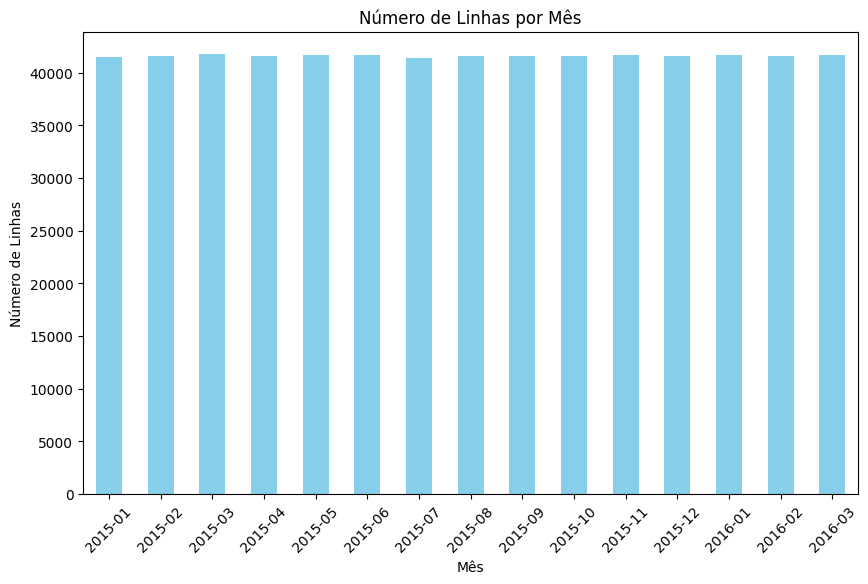

In [11]:
plt.figure(figsize=(10, 6))
linhas_por_mes.plot(kind='bar', color='skyblue')
plt.title('Número de Linhas por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Linhas')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Separando variáveis qualitativas e quantitativas
qualitativas = df.select_dtypes(include=['object', 'category'])
quantitativas = df.select_dtypes(include=['number'])

# Descritiva das variáveis qualitativas
print("\nAnálise descritiva das variáveis qualitativas:")
for col in qualitativas.columns:
    print(f"\nColuna: {col}")
    print(qualitativas[col].value_counts())
    print(f"Valores únicos: {qualitativas[col].nunique()}")
    print(f"Valores ausentes: {qualitativas[col].isna().sum()}")

# Descritiva das variáveis quantitativas
print("\nAnálise descritiva das variáveis quantitativas:")
print(quantitativas.describe())
print("\nValores ausentes nas variáveis quantitativas:")
print(quantitativas.isna().sum())


Análise descritiva das variáveis qualitativas:

Coluna: sexo
sexo
F    396774
M    227269
Name: count, dtype: int64
Valores únicos: 2
Valores ausentes: 0

Coluna: posse_de_veiculo
posse_de_veiculo
N    360466
S    263577
Name: count, dtype: int64
Valores únicos: 2
Valores ausentes: 0

Coluna: posse_de_imovel
posse_de_imovel
S    406154
N    217889
Name: count, dtype: int64
Valores únicos: 2
Valores ausentes: 0

Coluna: tipo_renda
tipo_renda
Assalariado         385740
Empresário          172712
Servidor público     64922
Bolsista               361
Pensionista            308
Name: count, dtype: int64
Valores únicos: 5
Valores ausentes: 0

Coluna: educacao
educacao
Médio                  406901
Superior completo      183239
Superior incompleto     28183
Fundamental              4908
Pós graduação             812
Name: count, dtype: int64
Valores únicos: 5
Valores ausentes: 0

Coluna: estado_civil
estado_civil
Casado      445154
Solteiro     78034
União        49981
Separado     36244
Viú

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [13]:
# Relação entre duas variáveis quantitativas (Correlação e Scatter Plot)
print("\nCorrelação entre variáveis quantitativas:")
correlacao = quantitativas.corr()
print(correlacao)



Correlação entre variáveis quantitativas:
                        level_0     index  qtd_filhos     idade  \
level_0                1.000000 -0.002913   -0.001807  0.000677   
index                 -0.002913  1.000000    0.028275 -0.028635   
qtd_filhos            -0.001807  0.028275    1.000000 -0.292349   
idade                  0.000677 -0.028635   -0.292349  1.000000   
tempo_emprego         -0.001713 -0.034562   -0.075299  0.330063   
qt_pessoas_residencia -0.001965  0.032046    0.902652 -0.258613   
renda                 -0.050979 -0.015248   -0.061659  0.192907   

                       tempo_emprego  qt_pessoas_residencia     renda  
level_0                    -0.001713              -0.001965 -0.050979  
index                      -0.034562               0.032046 -0.015248  
qtd_filhos                 -0.075299               0.902652 -0.061659  
idade                       0.330063              -0.258613  0.192907  
tempo_emprego               1.000000              -0.066361 

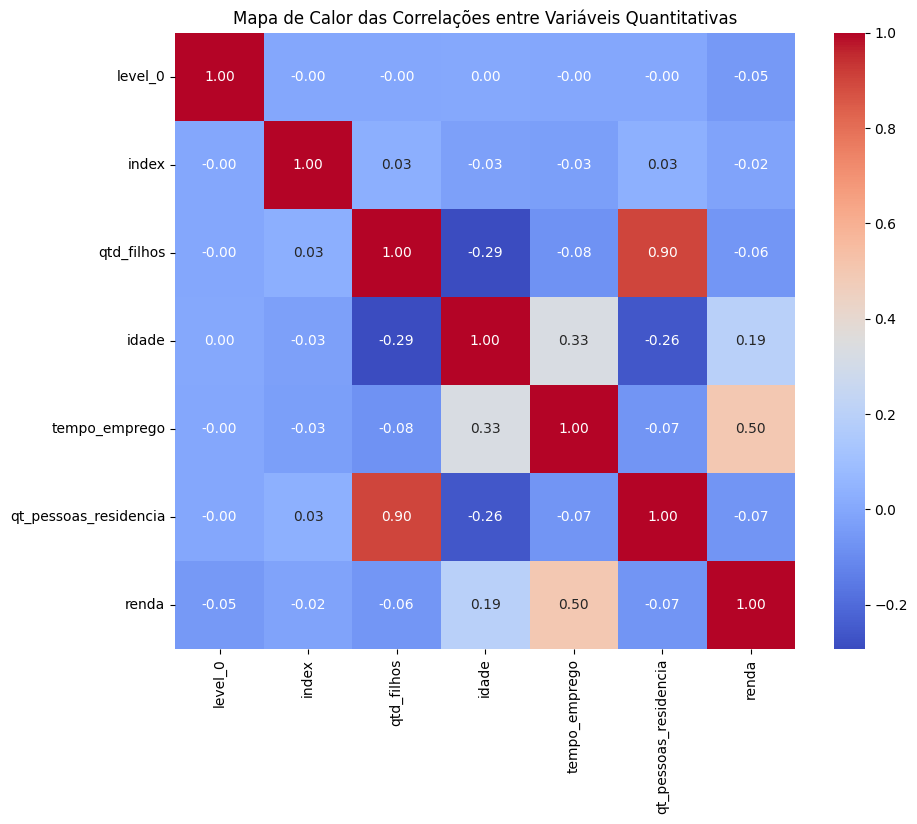

In [14]:
# Mapa de calor das correlações
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor das Correlações entre Variáveis Quantitativas')
plt.show()

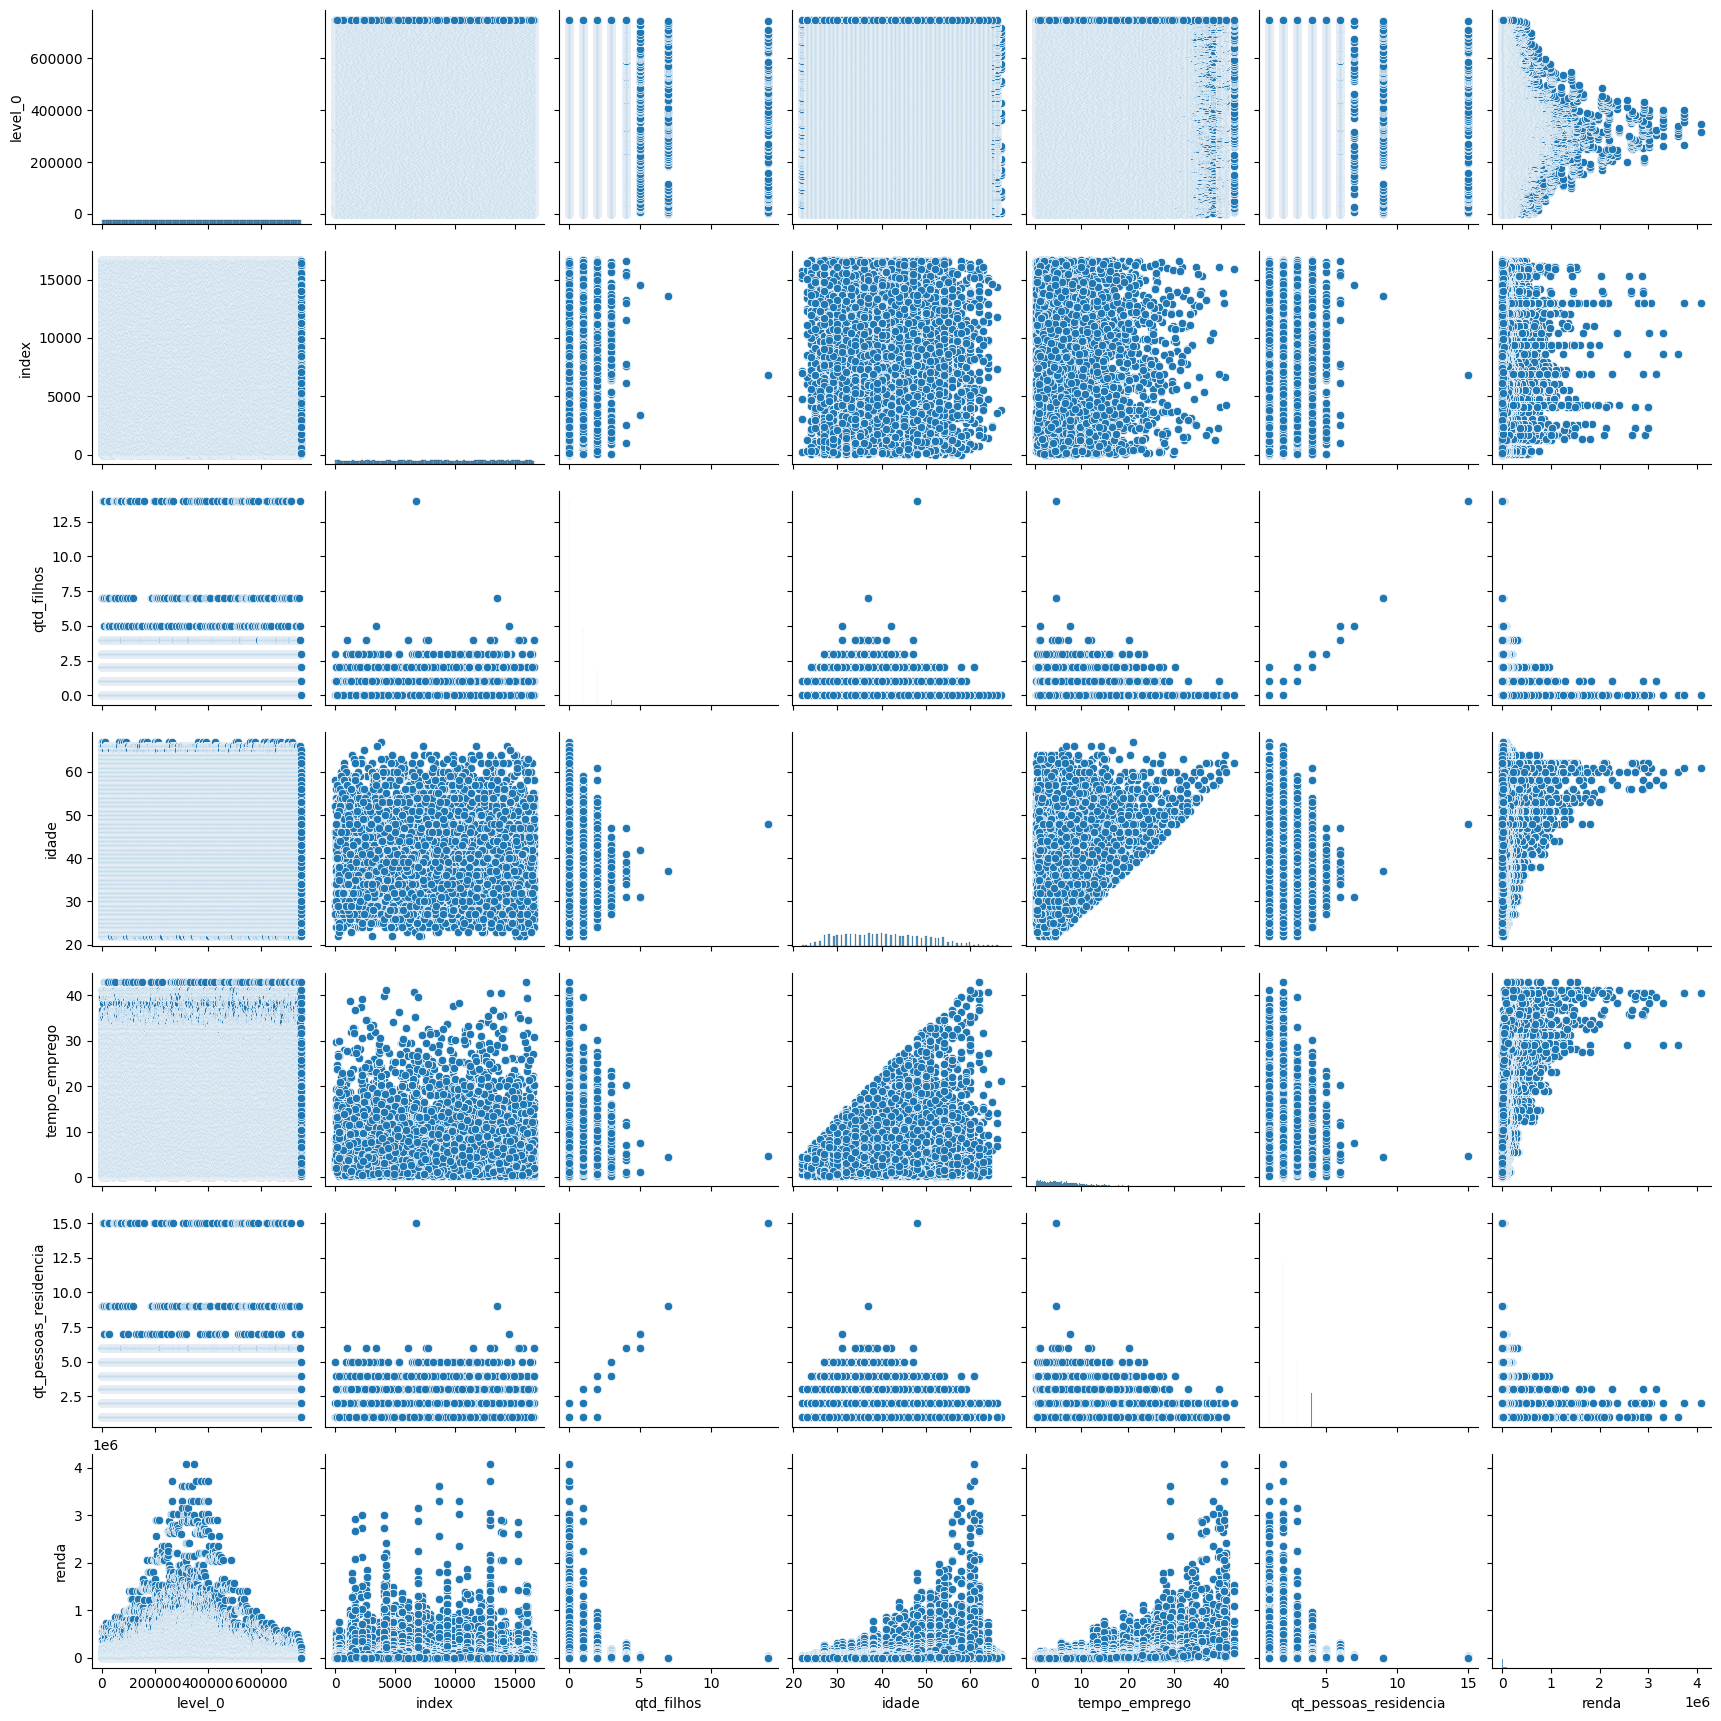

In [15]:
# Scatter plot para pares de variáveis quantitativas
sns.pairplot(quantitativas)
plt.show()



Análise bivariada de variáveis qualitativas:

Tabela de contingência entre sexo e posse_de_veiculo:
posse_de_veiculo       N       S
sexo                            
F                 280117  116657
M                  80349  146920


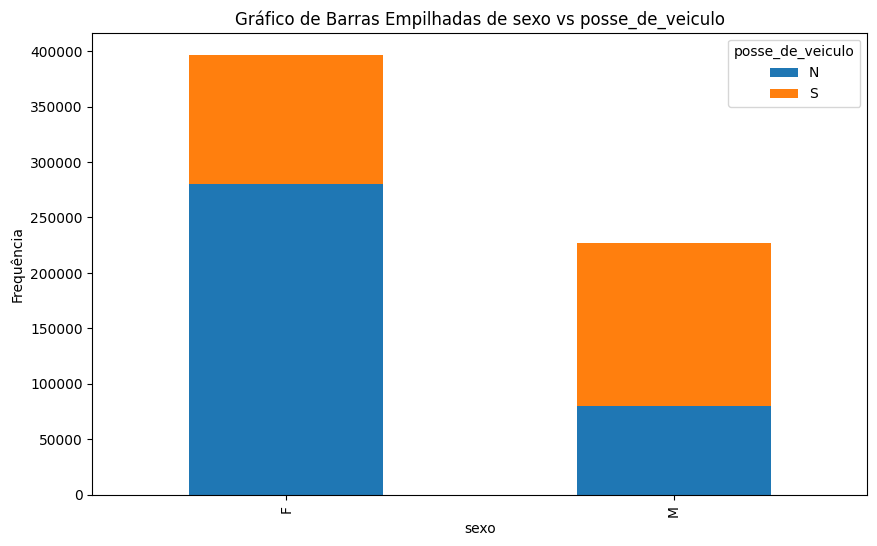


Tabela de contingência entre sexo e posse_de_imovel:
posse_de_imovel       N       S
sexo                           
F                132843  263931
M                 85046  142223


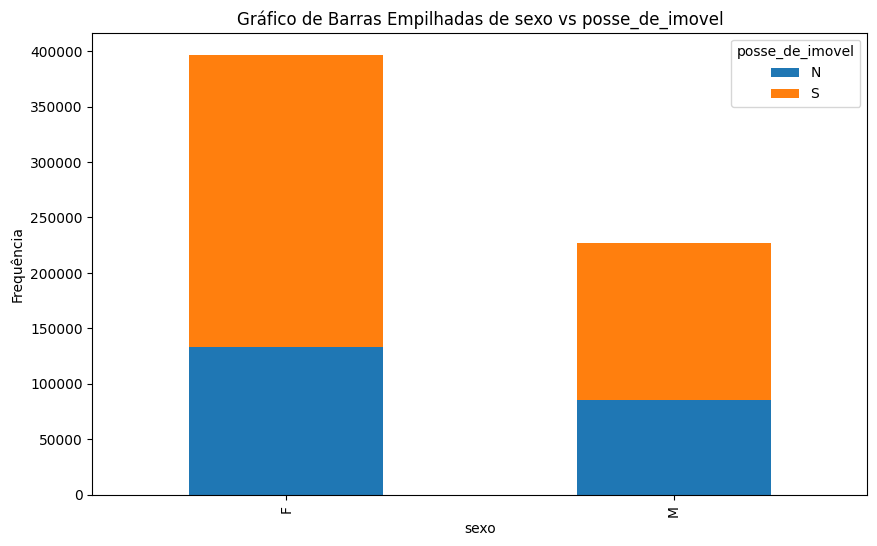


Tabela de contingência entre sexo e tipo_renda:
tipo_renda  Assalariado  Bolsista  Empresário  Pensionista  Servidor público
sexo                                                                        
F                235395       361      113774          210             47034
M                150345         0       58938           98             17888


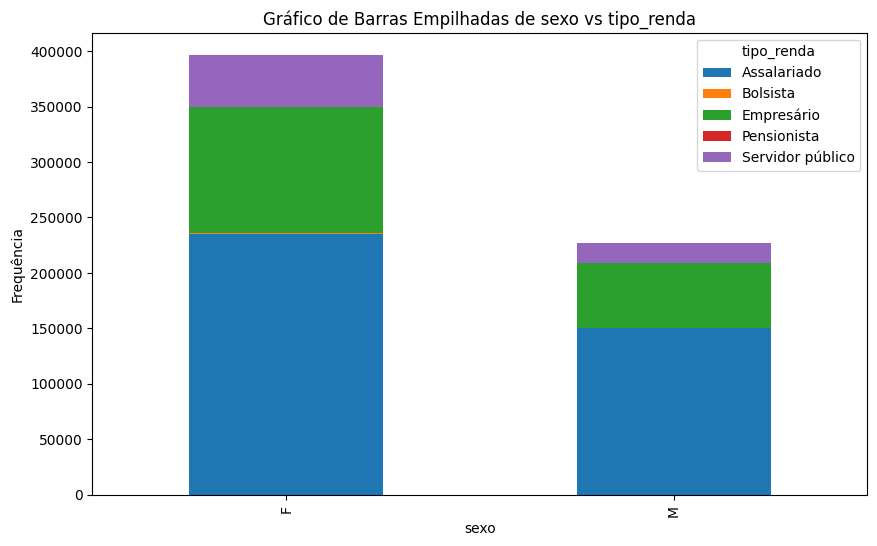


Tabela de contingência entre sexo e educacao:
educacao  Fundamental   Médio  Pós graduação  Superior completo  \
sexo                                                              
F                2288  254919            591             121796   
M                2620  151982            221              61443   

educacao  Superior incompleto  
sexo                           
F                       17180  
M                       11003  


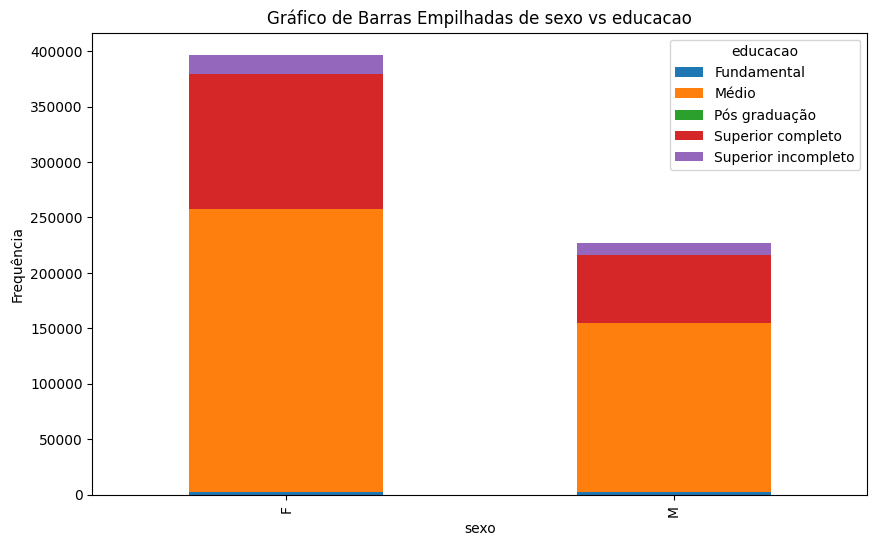


Tabela de contingência entre sexo e estado_civil:
estado_civil  Casado  Separado  Solteiro  União  Viúvo
sexo                                                  
F             266438     27962     52705  35362  14307
M             178716      8282     25329  14619    323


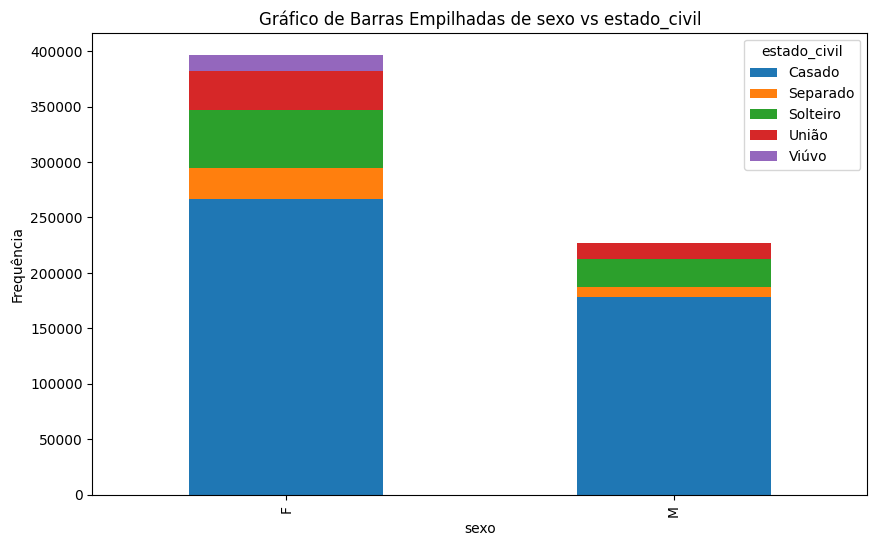


Tabela de contingência entre sexo e tipo_residencia:
tipo_residencia  Aluguel    Casa  Com os pais  Comunitário  Estúdio  \
sexo                                                                  
F                   4741  356781        18345         1748     1614   
M                   4981  196541        14798         1542     3141   

tipo_residencia  Governamental  
sexo                            
F                        13545  
M                         6266  


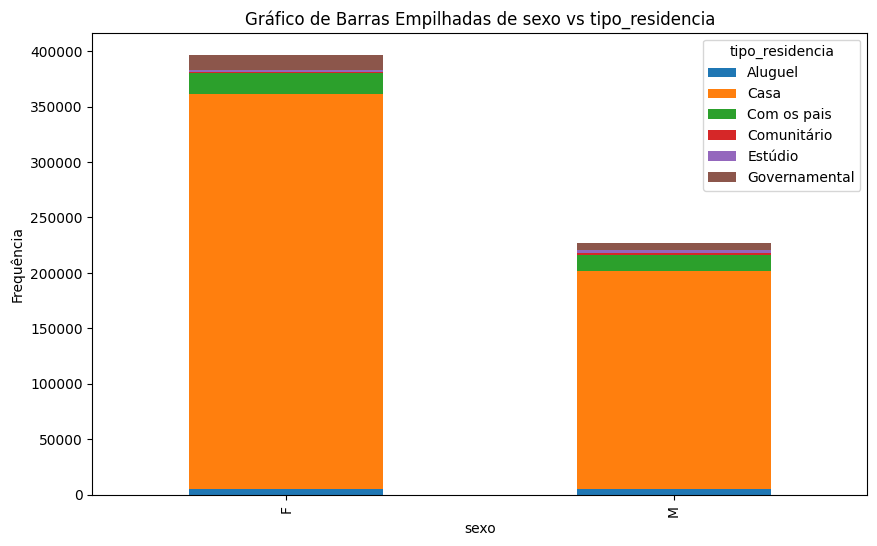


Tabela de contingência entre posse_de_veiculo e sexo:
sexo                   F       M
posse_de_veiculo                
N                 280117   80349
S                 116657  146920


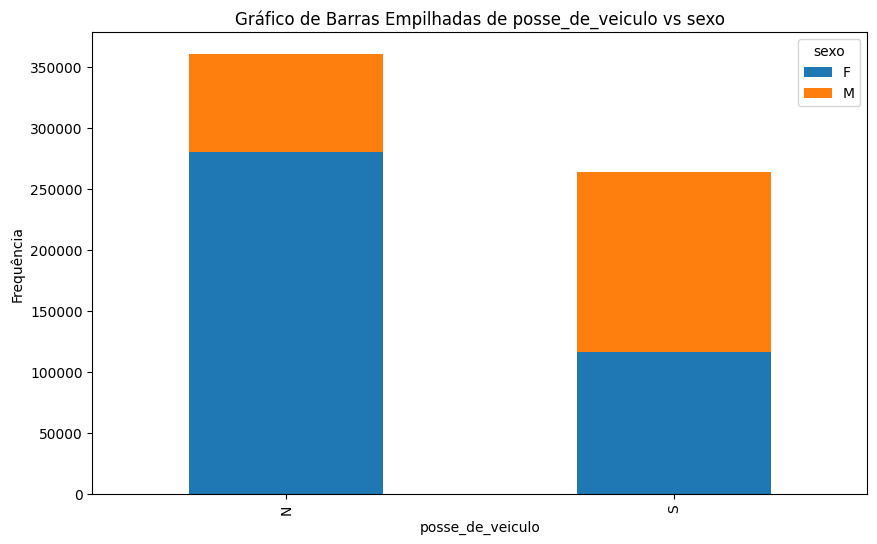


Tabela de contingência entre posse_de_veiculo e posse_de_imovel:
posse_de_imovel        N       S
posse_de_veiculo                
N                 125475  234991
S                  92414  171163


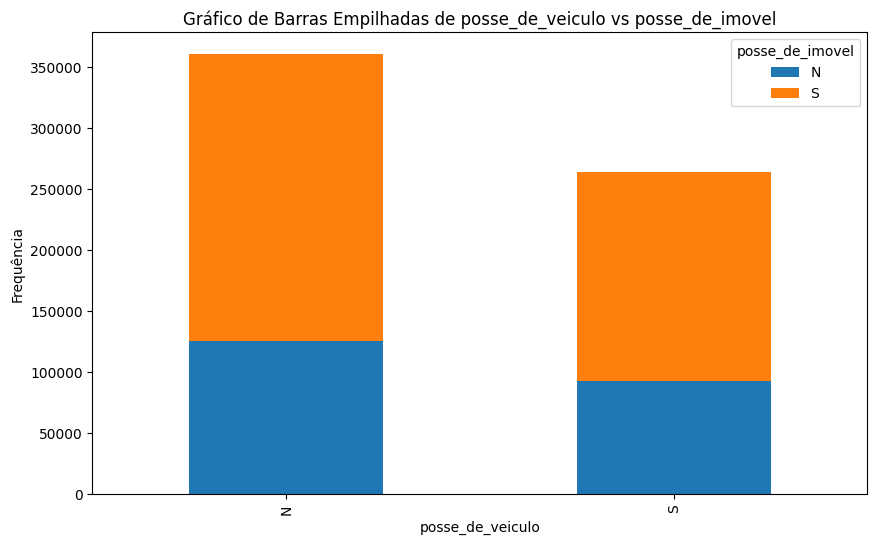


Tabela de contingência entre posse_de_veiculo e tipo_renda:
tipo_renda        Assalariado  Bolsista  Empresário  Pensionista  \
posse_de_veiculo                                                   
N                      222372       361       97806          122   
S                      163368         0       74906          186   

tipo_renda        Servidor público  
posse_de_veiculo                    
N                            39805  
S                            25117  


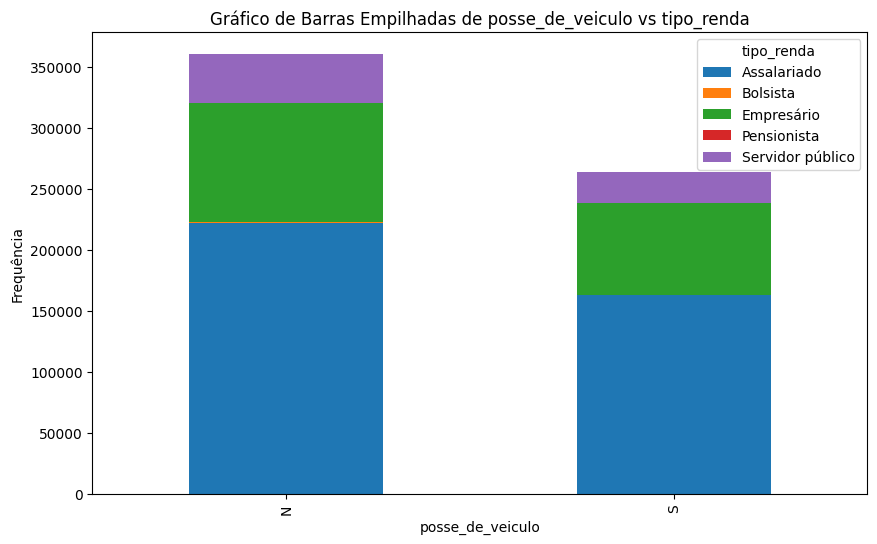


Tabela de contingência entre posse_de_veiculo e educacao:
educacao          Fundamental   Médio  Pós graduação  Superior completo  \
posse_de_veiculo                                                          
N                        2919  248340            280              93370   
S                        1989  158561            532              89869   

educacao          Superior incompleto  
posse_de_veiculo                       
N                               15557  
S                               12626  


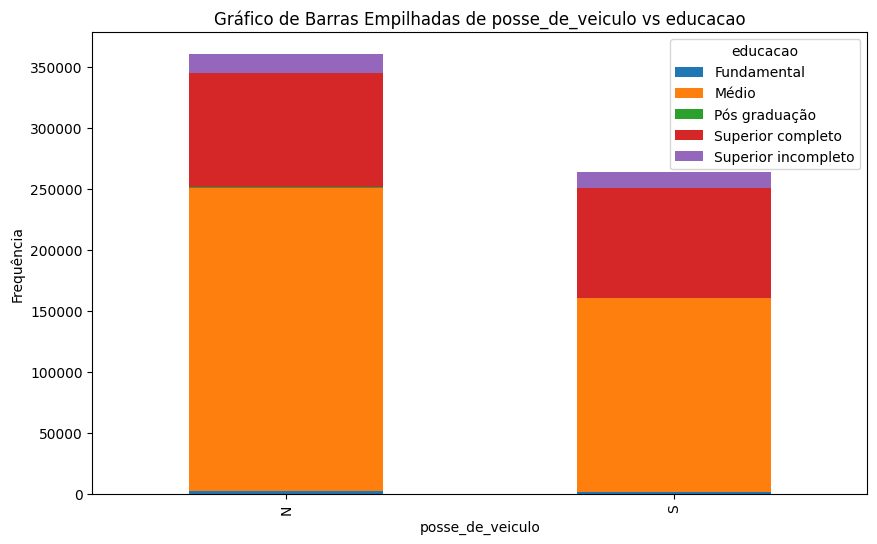


Tabela de contingência entre posse_de_veiculo e estado_civil:
estado_civil      Casado  Separado  Solteiro  União  Viúvo
posse_de_veiculo                                          
N                 235708     27029     53515  32978  11236
S                 209446      9215     24519  17003   3394


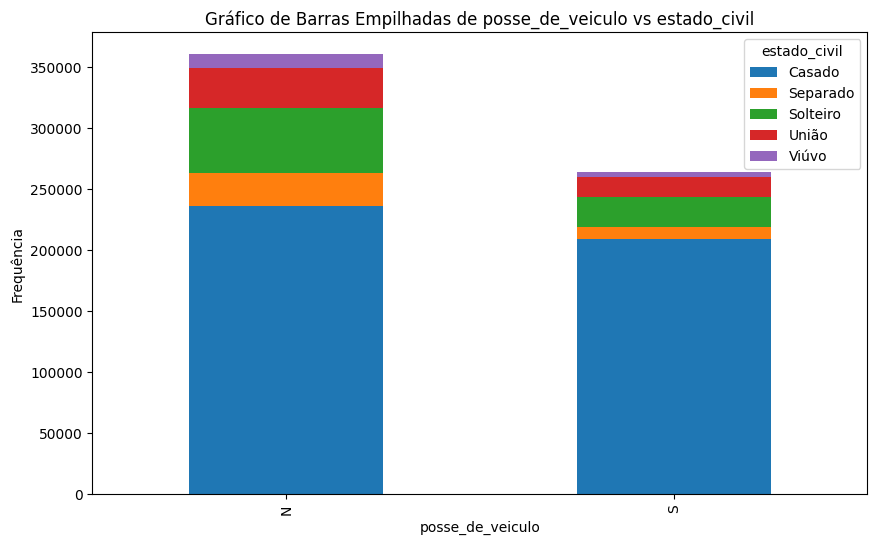


Tabela de contingência entre posse_de_veiculo e tipo_residencia:
tipo_residencia   Aluguel    Casa  Com os pais  Comunitário  Estúdio  \
posse_de_veiculo                                                       
N                    5395  321002        18552         1316     1876   
S                    4327  232320        14591         1974     2879   

tipo_residencia   Governamental  
posse_de_veiculo                 
N                         12325  
S                          7486  


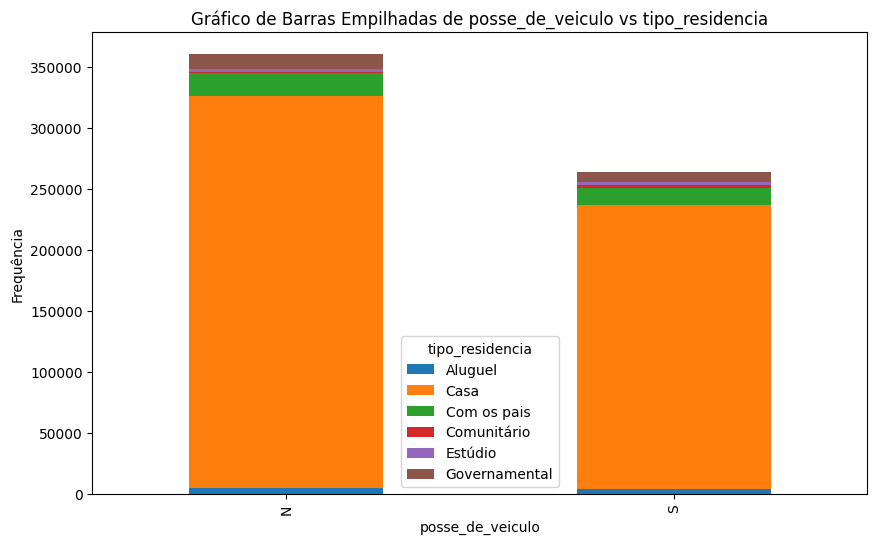


Tabela de contingência entre posse_de_imovel e sexo:
sexo                  F       M
posse_de_imovel                
N                132843   85046
S                263931  142223


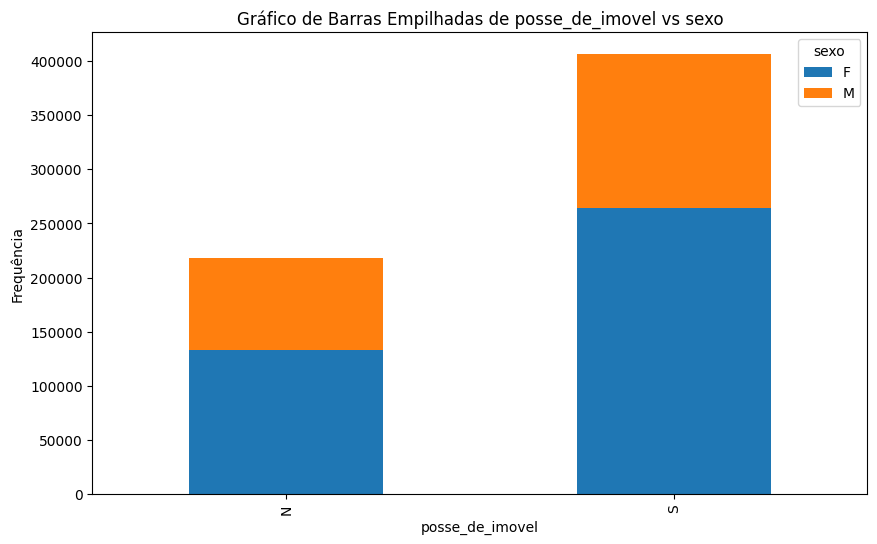


Tabela de contingência entre posse_de_imovel e posse_de_veiculo:
posse_de_veiculo       N       S
posse_de_imovel                 
N                 125475   92414
S                 234991  171163


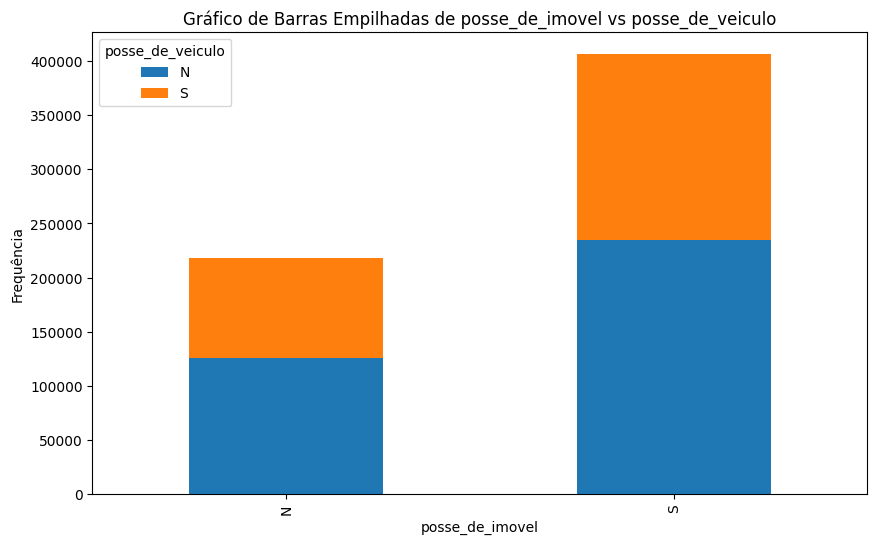


Tabela de contingência entre posse_de_imovel e tipo_renda:
tipo_renda       Assalariado  Bolsista  Empresário  Pensionista  \
posse_de_imovel                                                   
N                     135512         0       58972          191   
S                     250228       361      113740          117   

tipo_renda       Servidor público  
posse_de_imovel                    
N                           23214  
S                           41708  


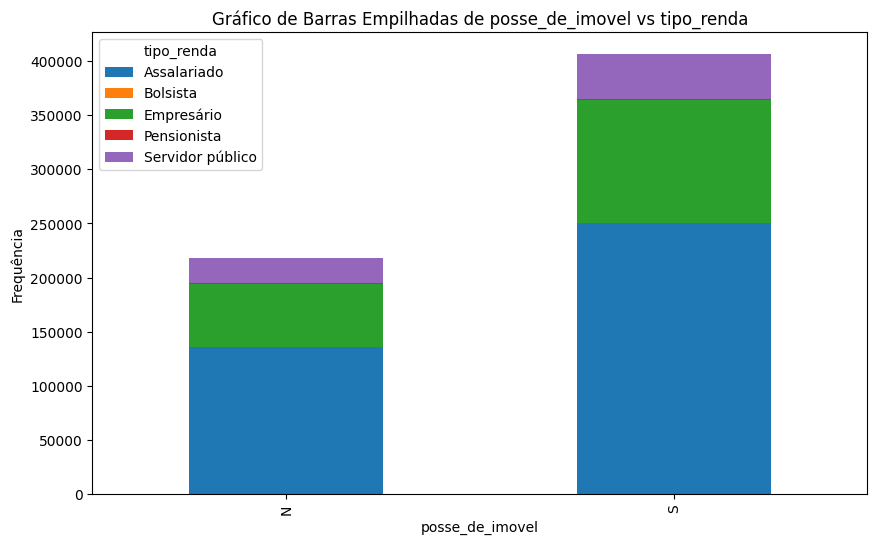


Tabela de contingência entre posse_de_imovel e educacao:
educacao         Fundamental   Médio  Pós graduação  Superior completo  \
posse_de_imovel                                                          
N                       1412  141452              0              62266   
S                       3496  265449            812             120973   

educacao         Superior incompleto  
posse_de_imovel                       
N                              12759  
S                              15424  


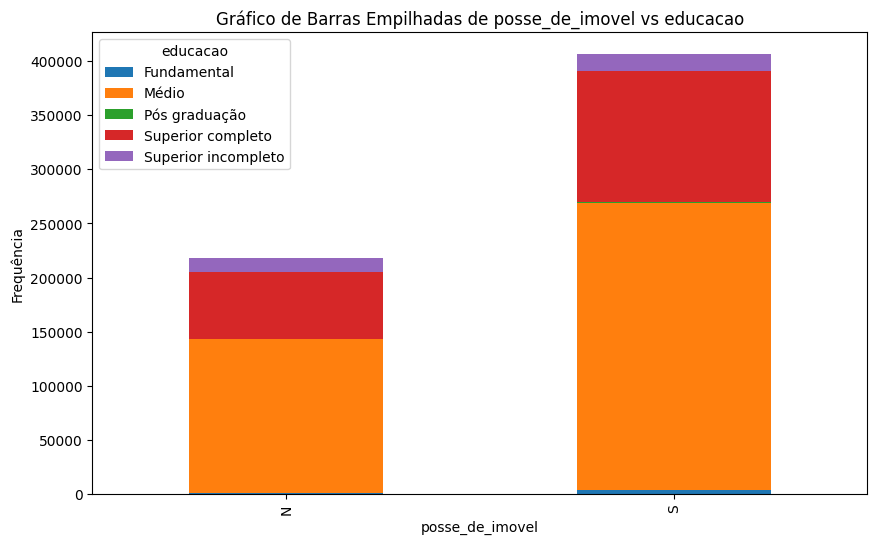


Tabela de contingência entre posse_de_imovel e estado_civil:
estado_civil     Casado  Separado  Solteiro  União  Viúvo
posse_de_imovel                                          
N                154065     13571     26171  20011   4071
S                291089     22673     51863  29970  10559


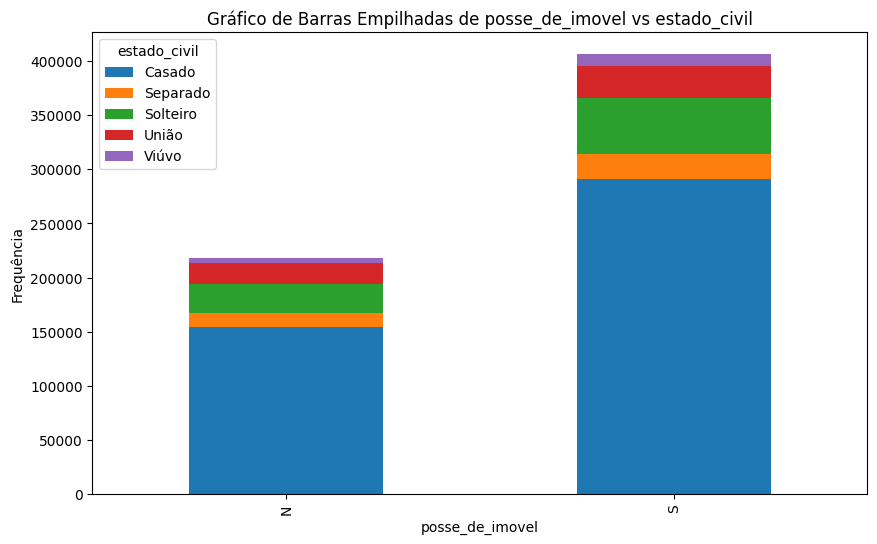


Tabela de contingência entre posse_de_imovel e tipo_residencia:
tipo_residencia  Aluguel    Casa  Com os pais  Comunitário  Estúdio  \
posse_de_imovel                                                       
N                   4408  173944        22189         1550     2545   
S                   5314  379378        10954         1740     2210   

tipo_residencia  Governamental  
posse_de_imovel                 
N                        13253  
S                         6558  


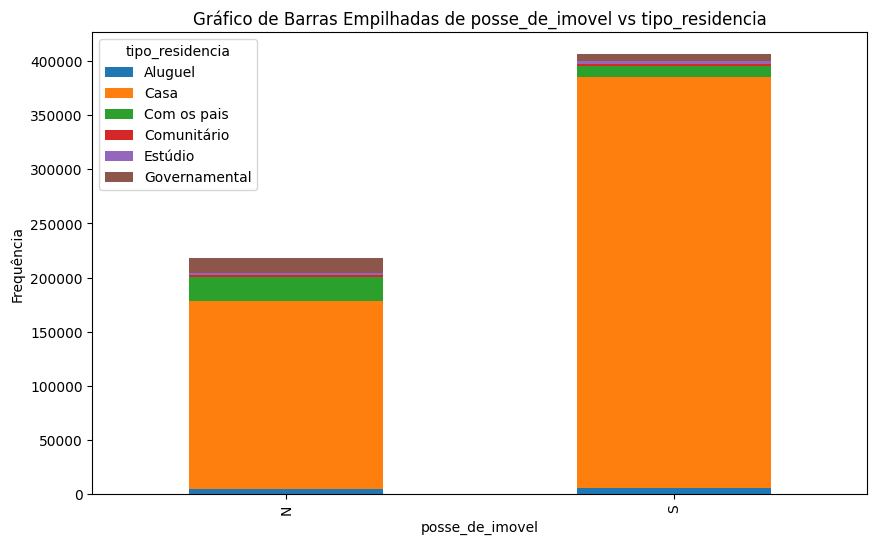


Tabela de contingência entre tipo_renda e sexo:
sexo                   F       M
tipo_renda                      
Assalariado       235395  150345
Bolsista             361       0
Empresário        113774   58938
Pensionista          210      98
Servidor público   47034   17888


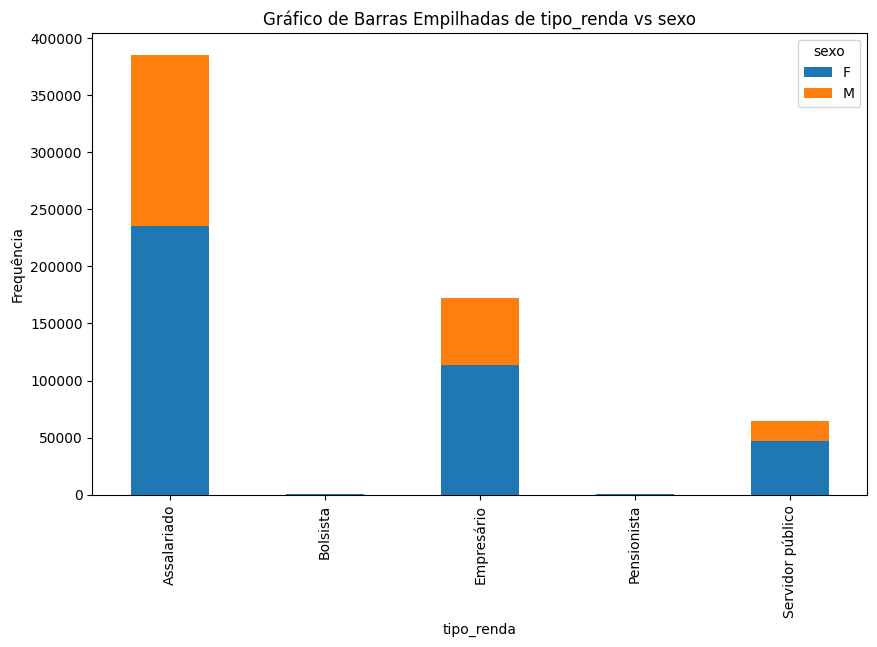


Tabela de contingência entre tipo_renda e posse_de_veiculo:
posse_de_veiculo       N       S
tipo_renda                      
Assalariado       222372  163368
Bolsista             361       0
Empresário         97806   74906
Pensionista          122     186
Servidor público   39805   25117


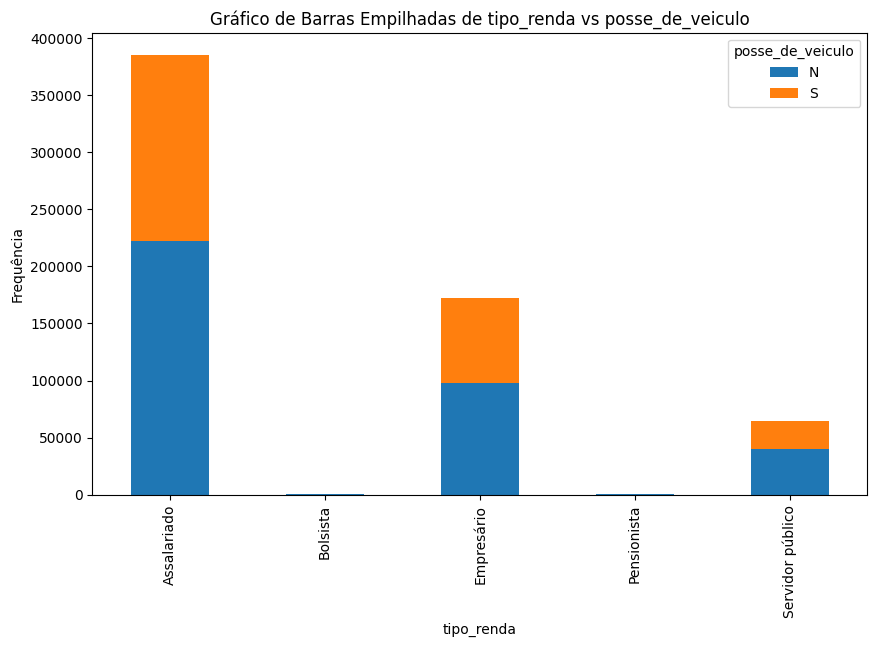


Tabela de contingência entre tipo_renda e posse_de_imovel:
posse_de_imovel        N       S
tipo_renda                      
Assalariado       135512  250228
Bolsista               0     361
Empresário         58972  113740
Pensionista          191     117
Servidor público   23214   41708


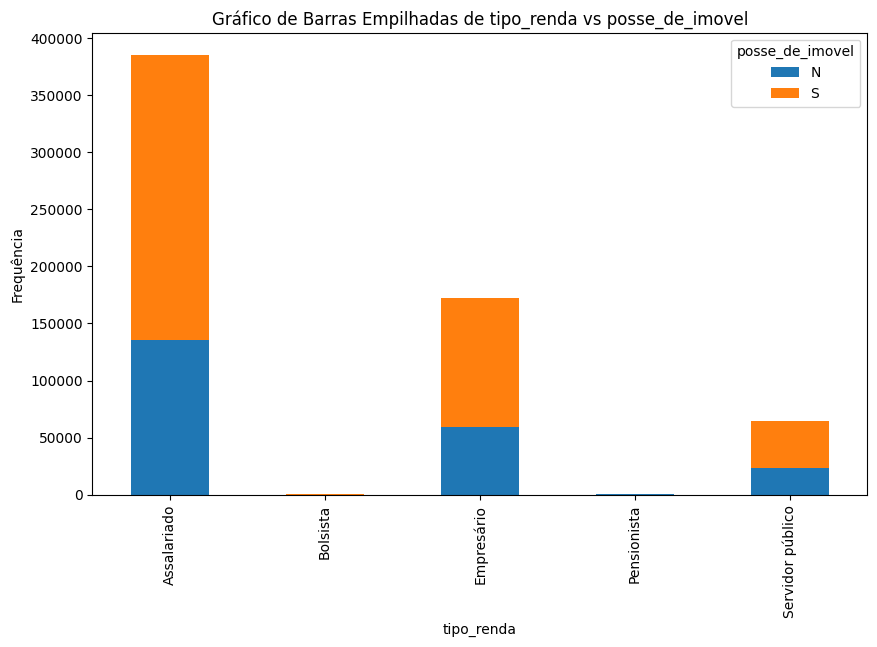


Tabela de contingência entre tipo_renda e educacao:
educacao          Fundamental   Médio  Pós graduação  Superior completo  \
tipo_renda                                                                
Assalariado              3911  269981            403              95156   
Bolsista                    0       0              0                361   
Empresário                688  102504            409              59422   
Pensionista                 0      39              0                269   
Servidor público          309   34377              0              28031   

educacao          Superior incompleto  
tipo_renda                             
Assalariado                     16289  
Bolsista                            0  
Empresário                       9689  
Pensionista                         0  
Servidor público                 2205  


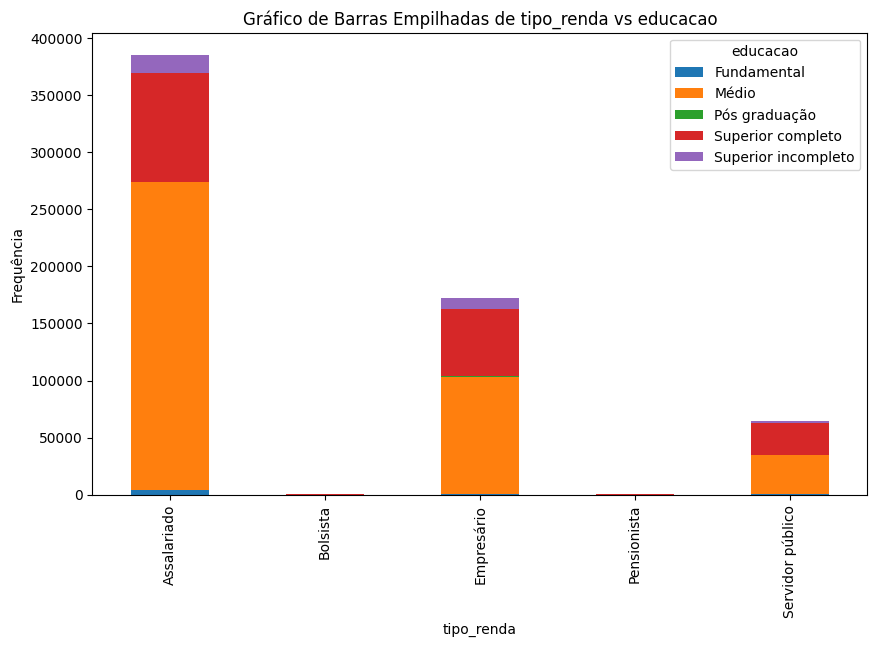


Tabela de contingência entre tipo_renda e estado_civil:
estado_civil      Casado  Separado  Solteiro  União  Viúvo
tipo_renda                                                
Assalariado       278959     22762     45274  28761   9984
Bolsista             361         0         0      0      0
Empresário        118413     10429     25134  16260   2476
Pensionista          169         0       139      0      0
Servidor público   47252      3053      7487   4960   2170


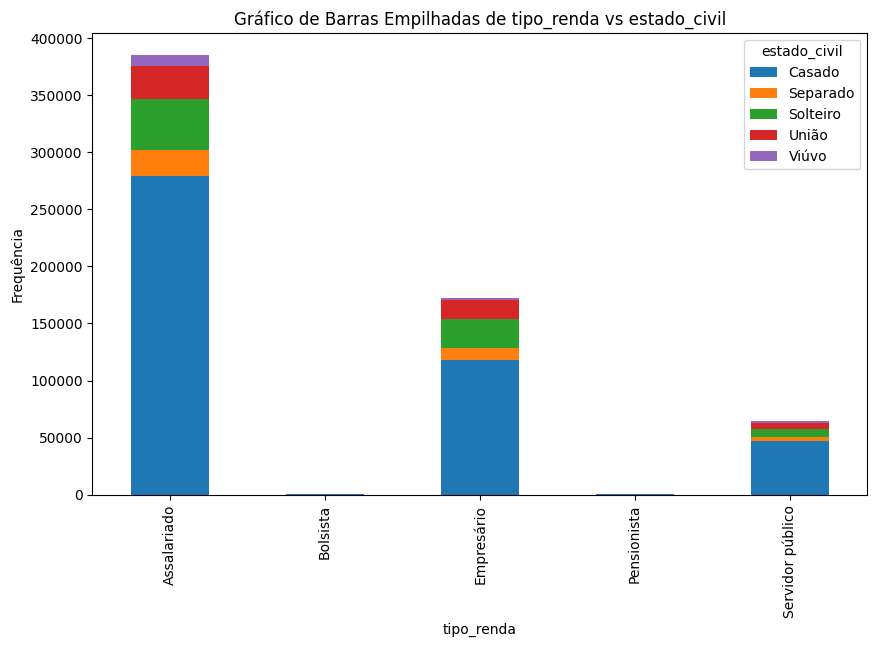


Tabela de contingência entre tipo_renda e tipo_residencia:
tipo_residencia   Aluguel    Casa  Com os pais  Comunitário  Estúdio  \
tipo_renda                                                             
Assalariado          6408  341268        21238         2539     2089   
Bolsista                0     361            0            0        0   
Empresário           2545  154727         8511          307     1449   
Pensionista             0     308            0            0        0   
Servidor público      769   56658         3394          444     1217   

tipo_residencia   Governamental  
tipo_renda                       
Assalariado               12198  
Bolsista                      0  
Empresário                 5173  
Pensionista                   0  
Servidor público           2440  


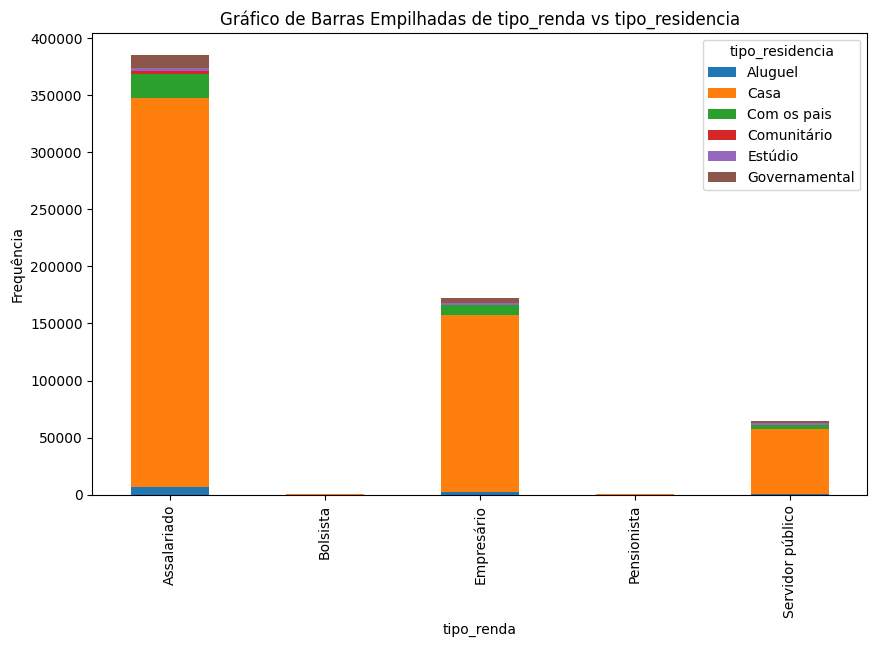


Tabela de contingência entre educacao e sexo:
sexo                      F       M
educacao                           
Fundamental            2288    2620
Médio                254919  151982
Pós graduação           591     221
Superior completo    121796   61443
Superior incompleto   17180   11003


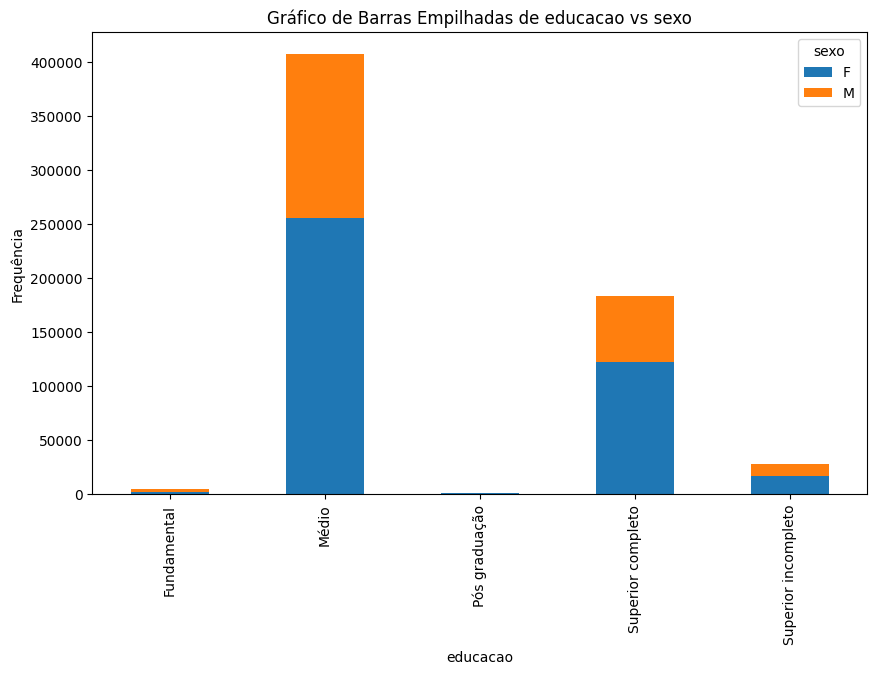


Tabela de contingência entre educacao e posse_de_veiculo:
posse_de_veiculo          N       S
educacao                           
Fundamental            2919    1989
Médio                248340  158561
Pós graduação           280     532
Superior completo     93370   89869
Superior incompleto   15557   12626


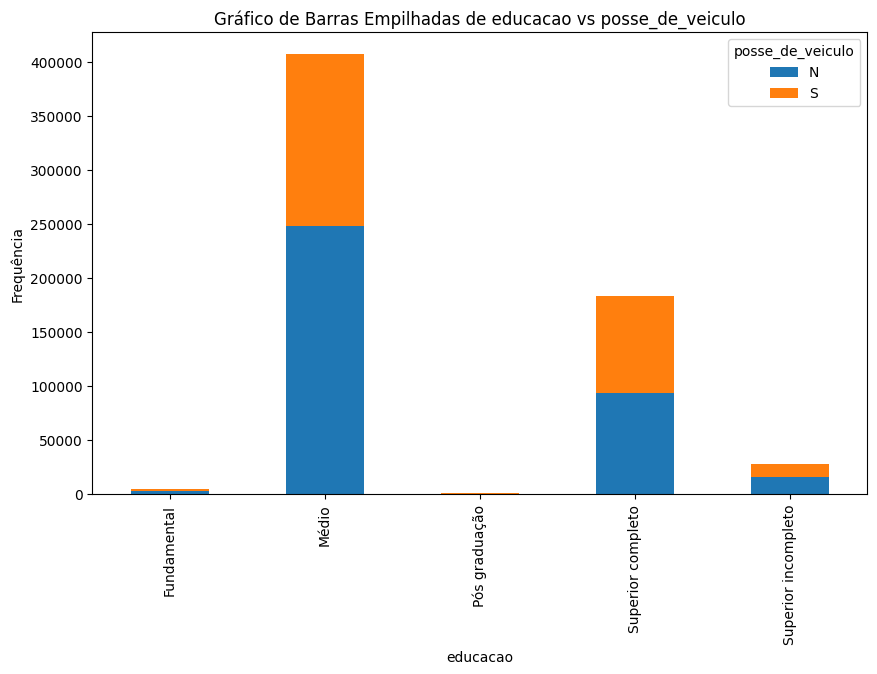


Tabela de contingência entre educacao e posse_de_imovel:
posse_de_imovel           N       S
educacao                           
Fundamental            1412    3496
Médio                141452  265449
Pós graduação             0     812
Superior completo     62266  120973
Superior incompleto   12759   15424


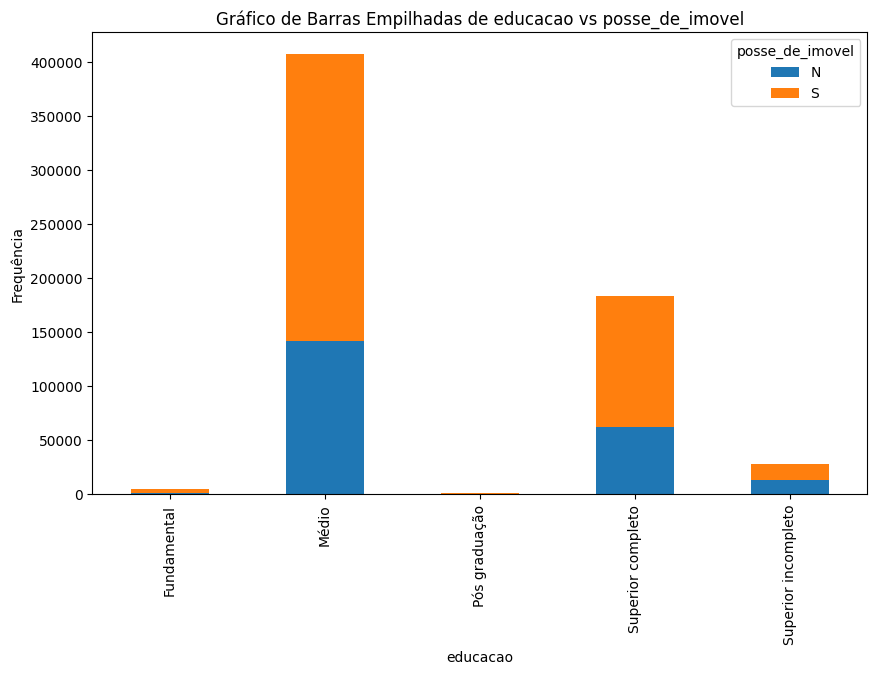


Tabela de contingência entre educacao e tipo_renda:
tipo_renda           Assalariado  Bolsista  Empresário  Pensionista  \
educacao                                                              
Fundamental                 3911         0         688            0   
Médio                     269981         0      102504           39   
Pós graduação                403         0         409            0   
Superior completo          95156       361       59422          269   
Superior incompleto        16289         0        9689            0   

tipo_renda           Servidor público  
educacao                               
Fundamental                       309  
Médio                           34377  
Pós graduação                       0  
Superior completo               28031  
Superior incompleto              2205  


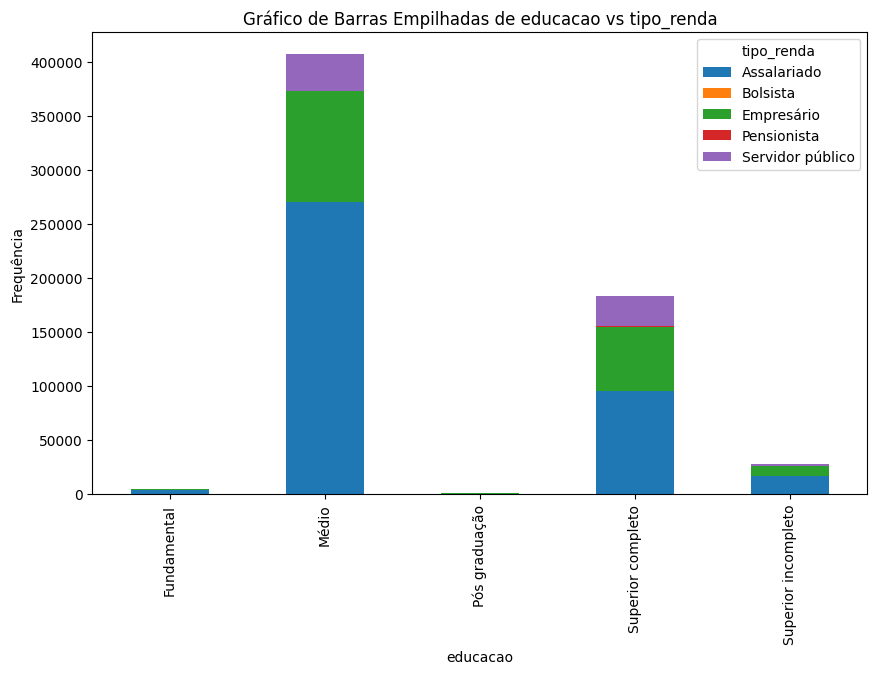


Tabela de contingência entre educacao e estado_civil:
estado_civil         Casado  Separado  Solteiro  União  Viúvo
educacao                                                     
Fundamental            3301       403       307    573    324
Médio                292076     23463     47203  34019  10140
Pós graduação           581         0       184     47      0
Superior completo    130117     11494     25142  12444   4042
Superior incompleto   19079       884      5198   2898    124


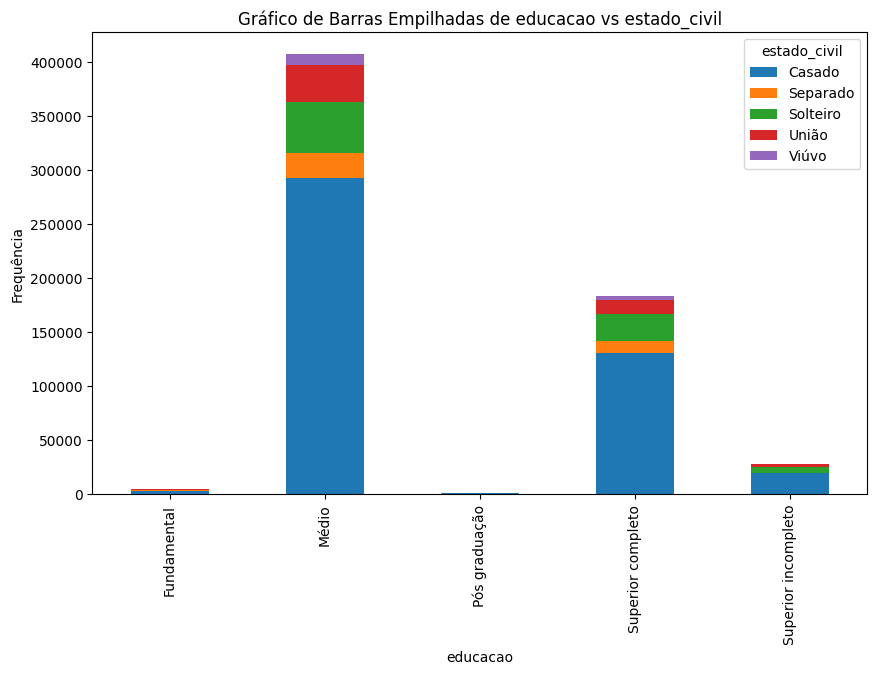


Tabela de contingência entre educacao e tipo_residencia:
tipo_residencia      Aluguel    Casa  Com os pais  Comunitário  Estúdio  \
educacao                                                                  
Fundamental               83    3818          479          230        0   
Médio                   6978  361360        18832         1064     2650   
Pós graduação              0     812            0            0        0   
Superior completo       1857  163685        10933         1667     1905   
Superior incompleto      804   23647         2899          329      200   

tipo_residencia      Governamental  
educacao                            
Fundamental                    298  
Médio                        16017  
Pós graduação                    0  
Superior completo             3192  
Superior incompleto            304  


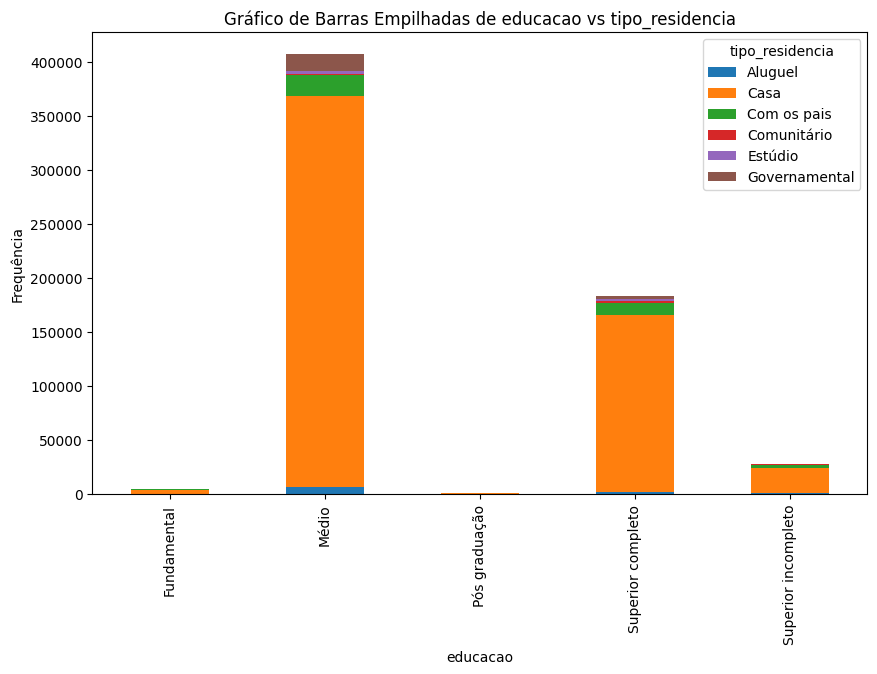


Tabela de contingência entre estado_civil e sexo:
sexo               F       M
estado_civil                
Casado        266438  178716
Separado       27962    8282
Solteiro       52705   25329
União          35362   14619
Viúvo          14307     323


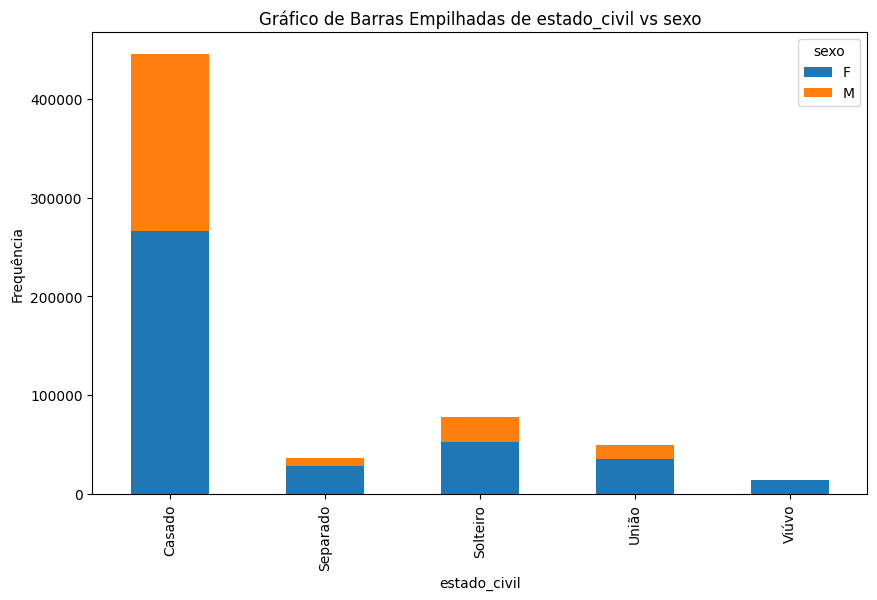


Tabela de contingência entre estado_civil e posse_de_veiculo:
posse_de_veiculo       N       S
estado_civil                    
Casado            235708  209446
Separado           27029    9215
Solteiro           53515   24519
União              32978   17003
Viúvo              11236    3394


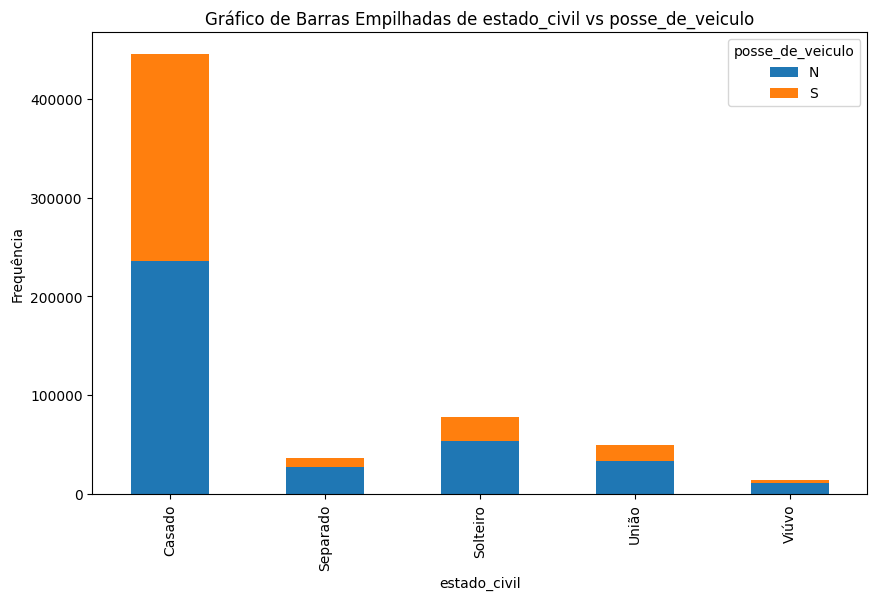


Tabela de contingência entre estado_civil e posse_de_imovel:
posse_de_imovel       N       S
estado_civil                   
Casado           154065  291089
Separado          13571   22673
Solteiro          26171   51863
União             20011   29970
Viúvo              4071   10559


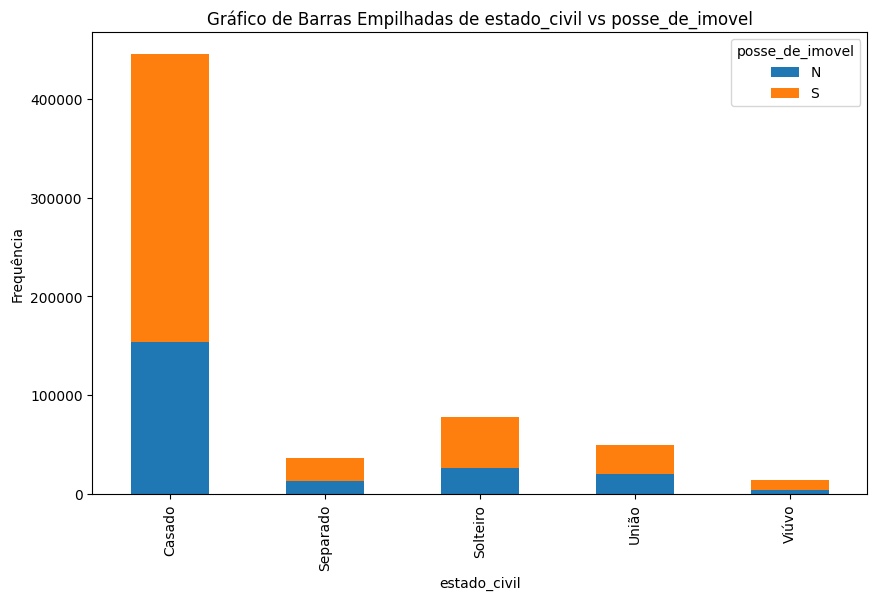


Tabela de contingência entre estado_civil e tipo_renda:
tipo_renda    Assalariado  Bolsista  Empresário  Pensionista  Servidor público
estado_civil                                                                  
Casado             278959       361      118413          169             47252
Separado            22762         0       10429            0              3053
Solteiro            45274         0       25134          139              7487
União               28761         0       16260            0              4960
Viúvo                9984         0        2476            0              2170


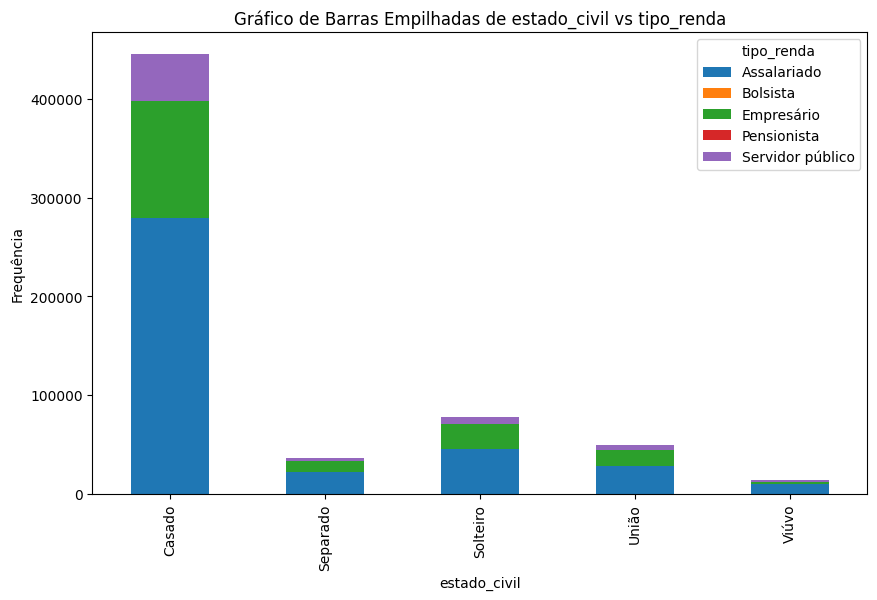


Tabela de contingência entre estado_civil e educacao:
educacao      Fundamental   Médio  Pós graduação  Superior completo  \
estado_civil                                                          
Casado               3301  292076            581             130117   
Separado              403   23463              0              11494   
Solteiro              307   47203            184              25142   
União                 573   34019             47              12444   
Viúvo                 324   10140              0               4042   

educacao      Superior incompleto  
estado_civil                       
Casado                      19079  
Separado                      884  
Solteiro                     5198  
União                        2898  
Viúvo                         124  


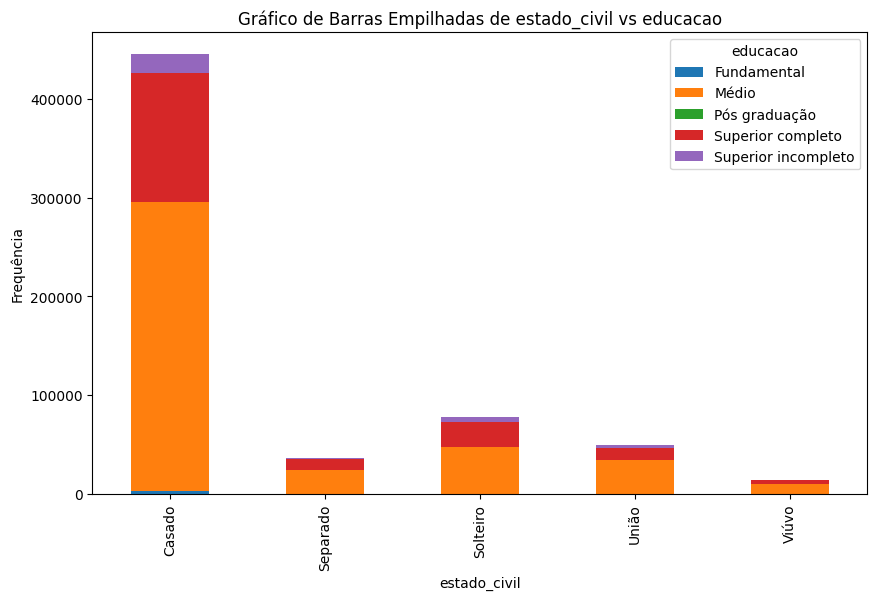


Tabela de contingência entre estado_civil e tipo_residencia:
tipo_residencia  Aluguel    Casa  Com os pais  Comunitário  Estúdio  \
estado_civil                                                          
Casado              6050  397810        21552         2566     3146   
Separado             250   32038         2229          128      455   
Solteiro            2791   65817         5637          363      590   
União                537   44074         3619           45      564   
Viúvo                 94   13583          106          188        0   

tipo_residencia  Governamental  
estado_civil                    
Casado                   14030  
Separado                  1144  
Solteiro                  2836  
União                     1142  
Viúvo                      659  


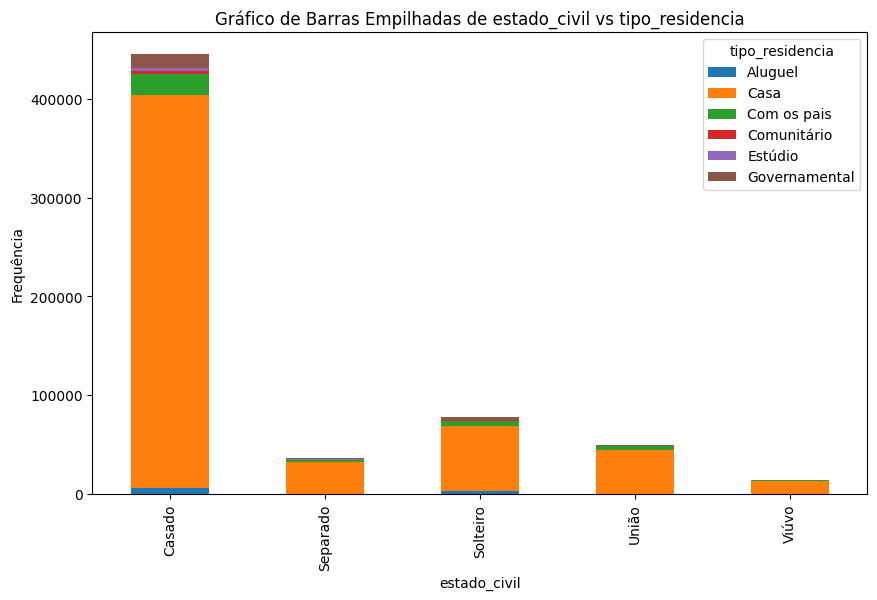


Tabela de contingência entre tipo_residencia e sexo:
sexo                  F       M
tipo_residencia                
Aluguel            4741    4981
Casa             356781  196541
Com os pais       18345   14798
Comunitário        1748    1542
Estúdio            1614    3141
Governamental     13545    6266


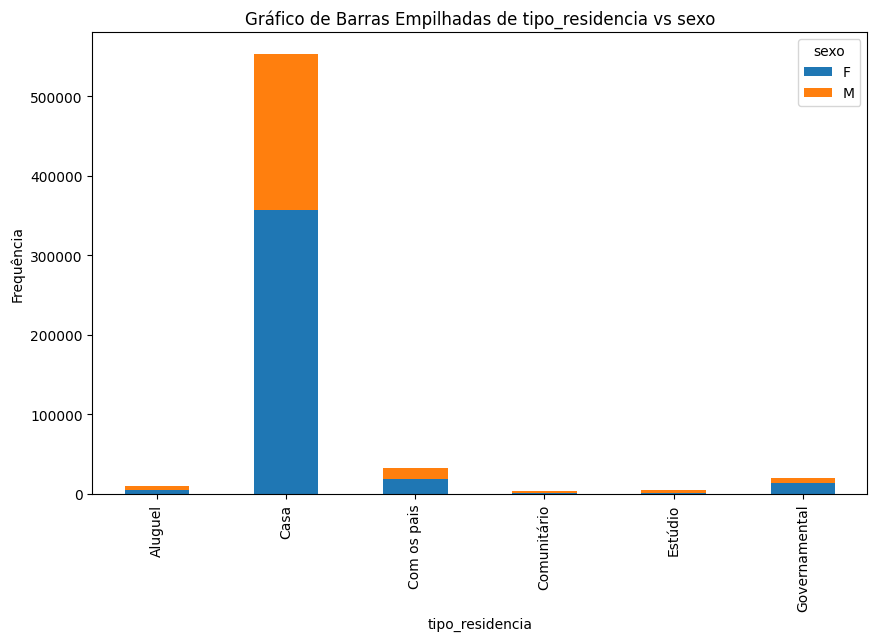


Tabela de contingência entre tipo_residencia e posse_de_veiculo:
posse_de_veiculo       N       S
tipo_residencia                 
Aluguel             5395    4327
Casa              321002  232320
Com os pais        18552   14591
Comunitário         1316    1974
Estúdio             1876    2879
Governamental      12325    7486


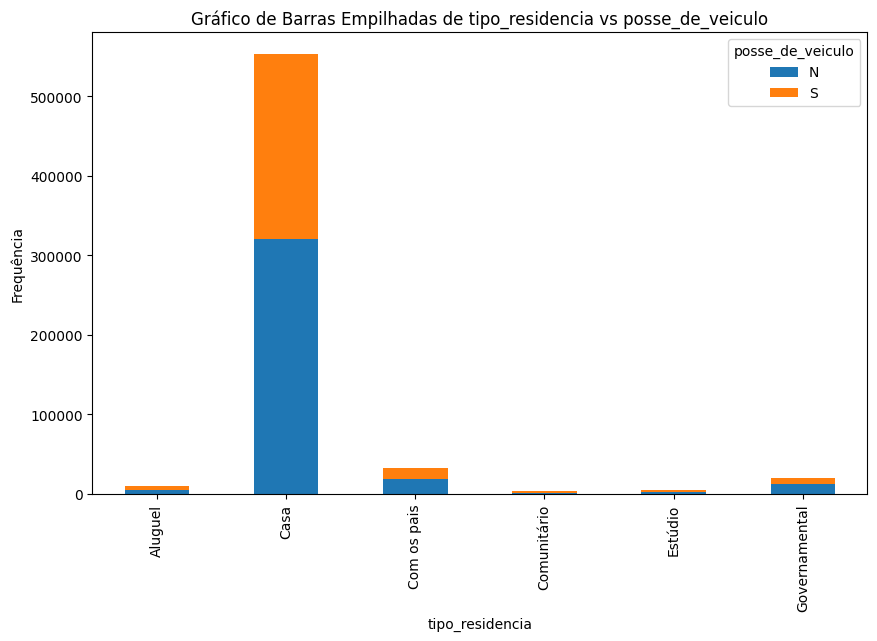


Tabela de contingência entre tipo_residencia e posse_de_imovel:
posse_de_imovel       N       S
tipo_residencia                
Aluguel            4408    5314
Casa             173944  379378
Com os pais       22189   10954
Comunitário        1550    1740
Estúdio            2545    2210
Governamental     13253    6558


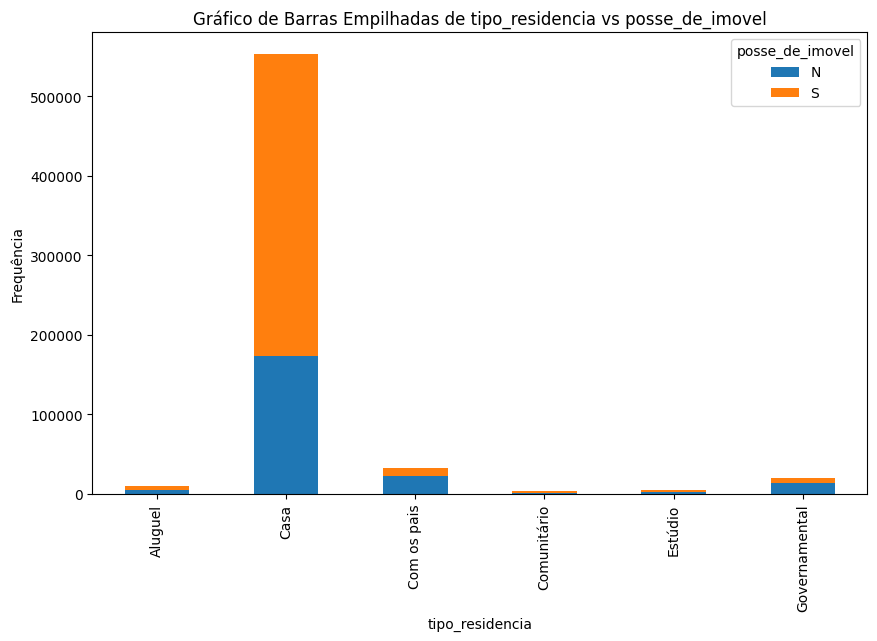


Tabela de contingência entre tipo_residencia e tipo_renda:
tipo_renda       Assalariado  Bolsista  Empresário  Pensionista  \
tipo_residencia                                                   
Aluguel                 6408         0        2545            0   
Casa                  341268       361      154727          308   
Com os pais            21238         0        8511            0   
Comunitário             2539         0         307            0   
Estúdio                 2089         0        1449            0   
Governamental          12198         0        5173            0   

tipo_renda       Servidor público  
tipo_residencia                    
Aluguel                       769  
Casa                        56658  
Com os pais                  3394  
Comunitário                   444  
Estúdio                      1217  
Governamental                2440  


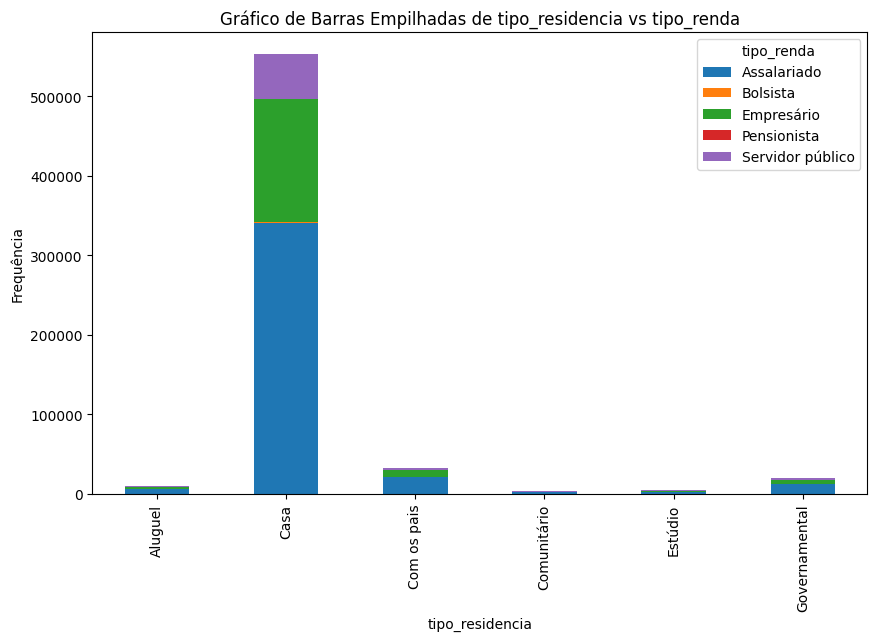


Tabela de contingência entre tipo_residencia e educacao:
educacao         Fundamental   Médio  Pós graduação  Superior completo  \
tipo_residencia                                                          
Aluguel                   83    6978              0               1857   
Casa                    3818  361360            812             163685   
Com os pais              479   18832              0              10933   
Comunitário              230    1064              0               1667   
Estúdio                    0    2650              0               1905   
Governamental            298   16017              0               3192   

educacao         Superior incompleto  
tipo_residencia                       
Aluguel                          804  
Casa                           23647  
Com os pais                     2899  
Comunitário                      329  
Estúdio                          200  
Governamental                    304  


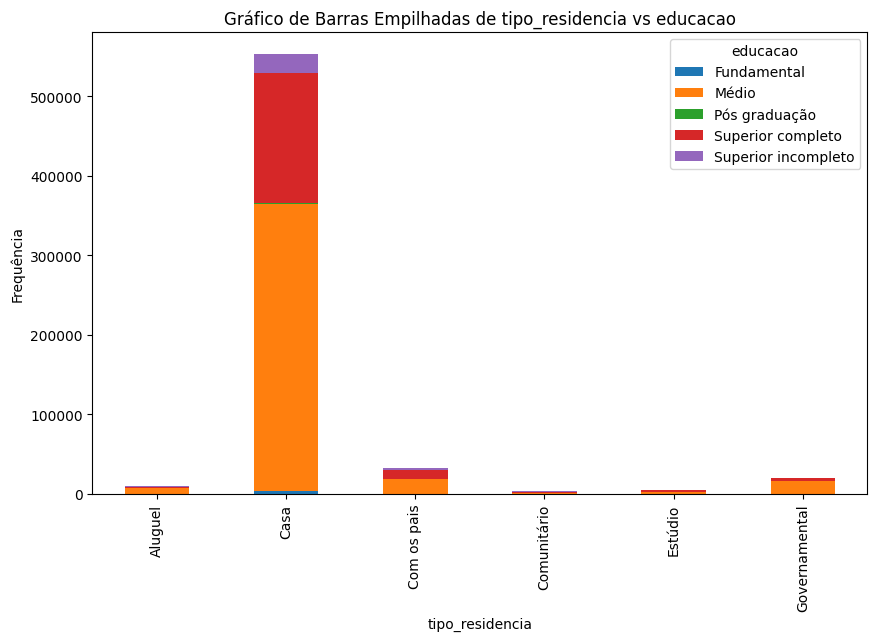


Tabela de contingência entre tipo_residencia e estado_civil:
estado_civil     Casado  Separado  Solteiro  União  Viúvo
tipo_residencia                                          
Aluguel            6050       250      2791    537     94
Casa             397810     32038     65817  44074  13583
Com os pais       21552      2229      5637   3619    106
Comunitário        2566       128       363     45    188
Estúdio            3146       455       590    564      0
Governamental     14030      1144      2836   1142    659


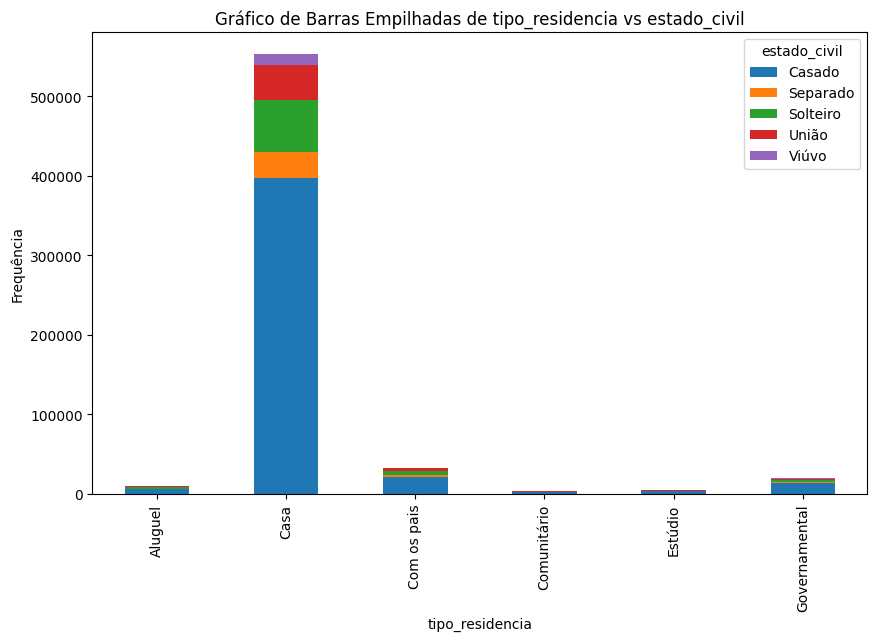

In [16]:
# Relação entre variáveis qualitativas (Tabelas de Contingência e Gráficos de Barras Empilhadas)
print("\nAnálise bivariada de variáveis qualitativas:")
for col1 in qualitativas.columns:
    for col2 in qualitativas.columns:
        if col1 != col2:
            print(f"\nTabela de contingência entre {col1} e {col2}:")
            contingencia = pd.crosstab(df[col1], df[col2])
            print(contingencia)
            # Gráfico de barras empilhadas
            contingencia.plot(kind='bar', stacked=True, figsize=(10, 6))
            plt.title(f'Gráfico de Barras Empilhadas de {col1} vs {col2}')
            plt.xlabel(col1)
            plt.ylabel('Frequência')
            plt.show()


Análise bivariada entre variáveis qualitativas e quantitativas:

Boxplot de level_0 por sexo:


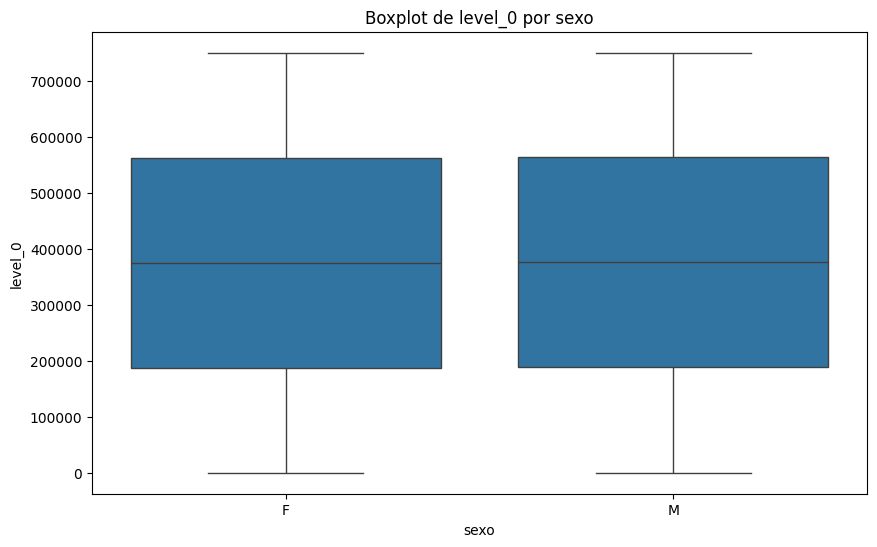


Violin Plot de level_0 por sexo:


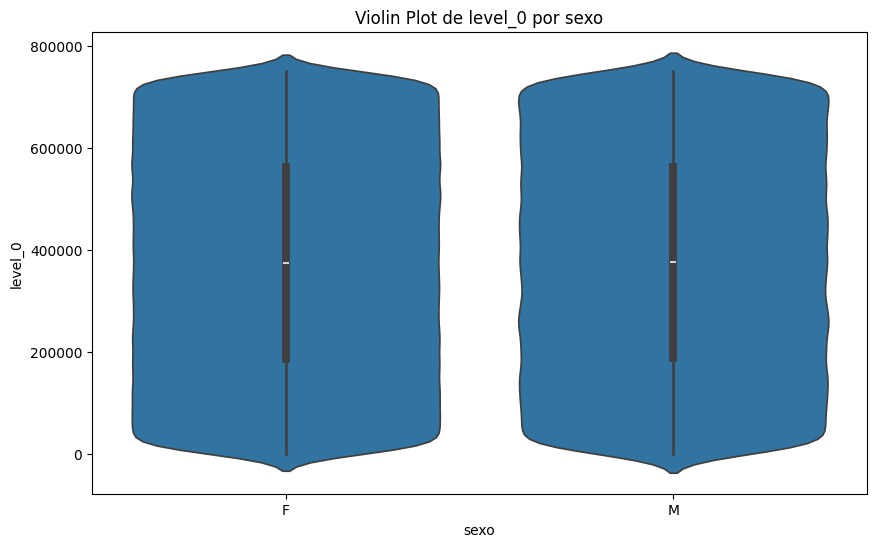


Boxplot de index por sexo:


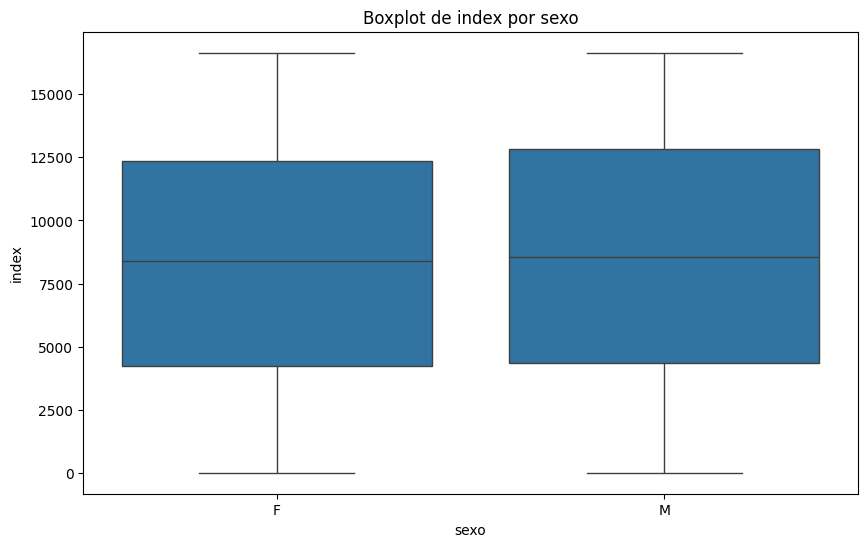


Violin Plot de index por sexo:


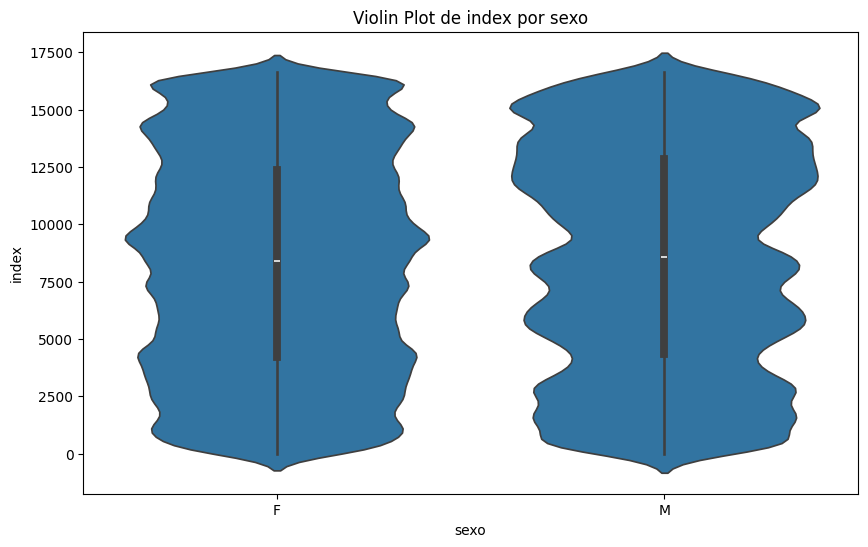


Boxplot de qtd_filhos por sexo:


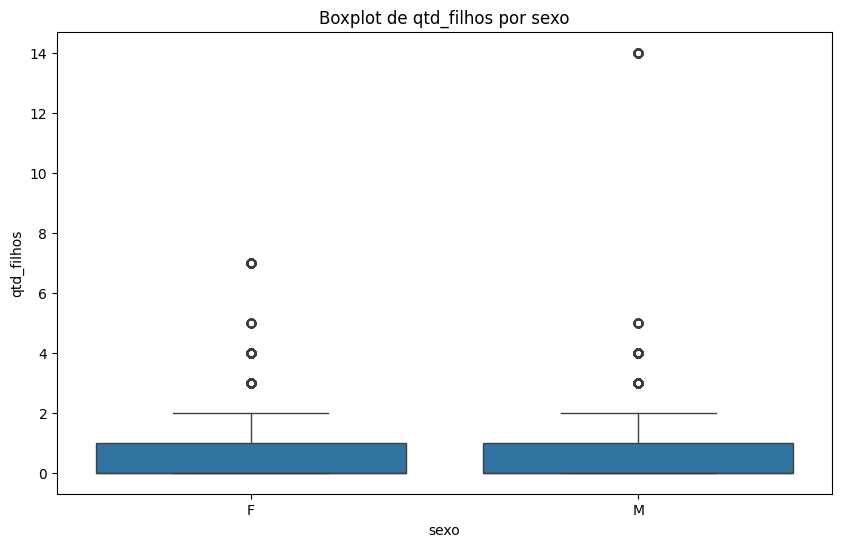


Violin Plot de qtd_filhos por sexo:


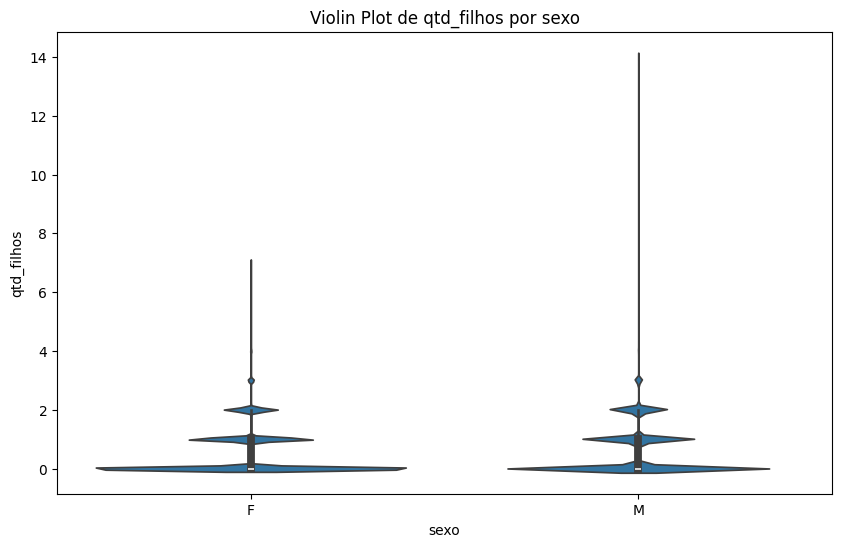


Boxplot de idade por sexo:


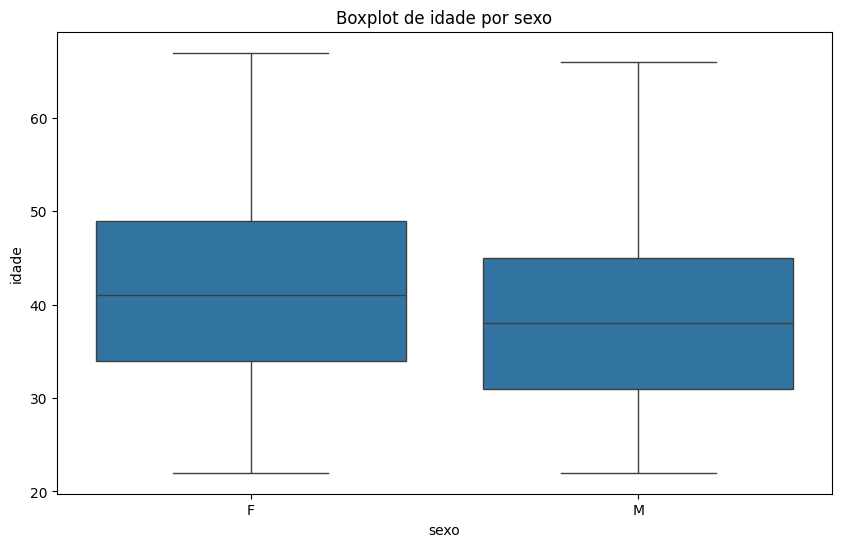


Violin Plot de idade por sexo:


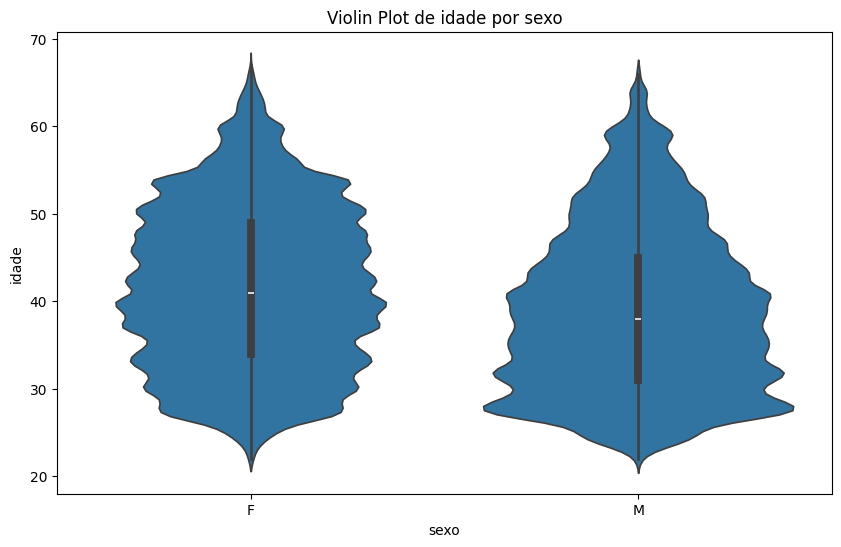


Boxplot de tempo_emprego por sexo:


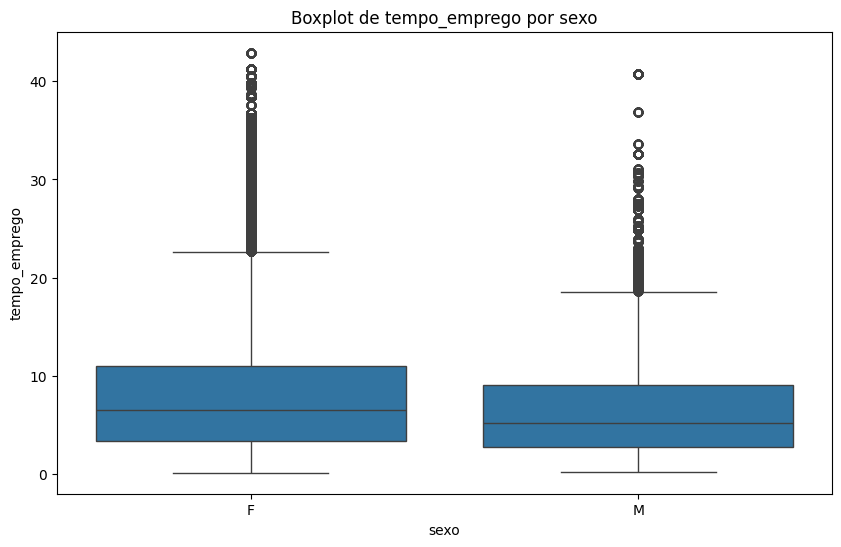


Violin Plot de tempo_emprego por sexo:


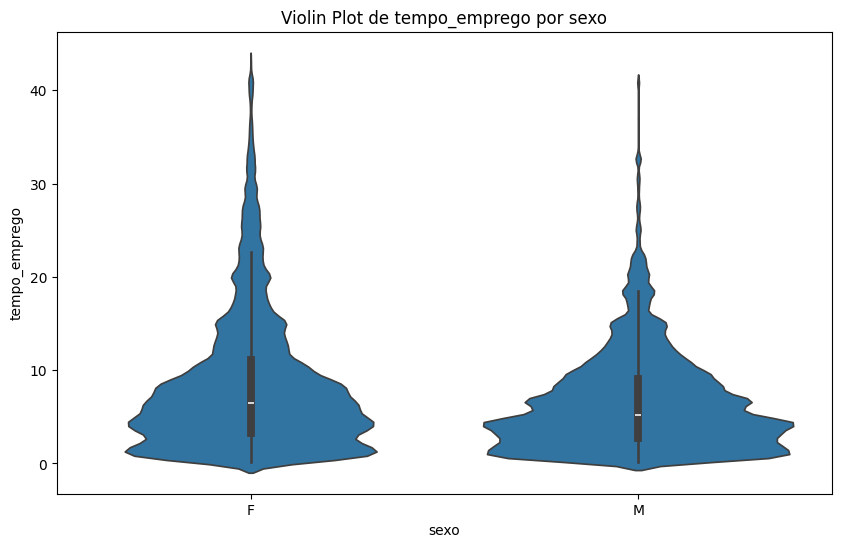


Boxplot de qt_pessoas_residencia por sexo:


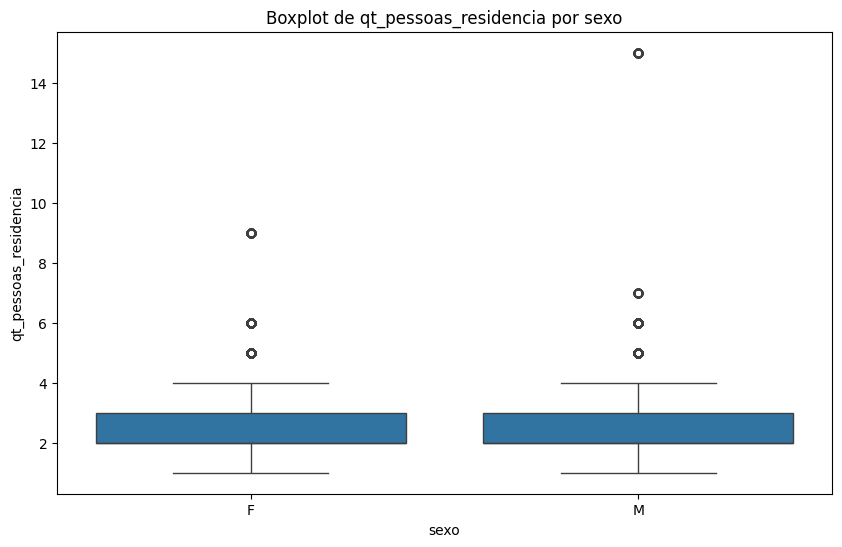


Violin Plot de qt_pessoas_residencia por sexo:


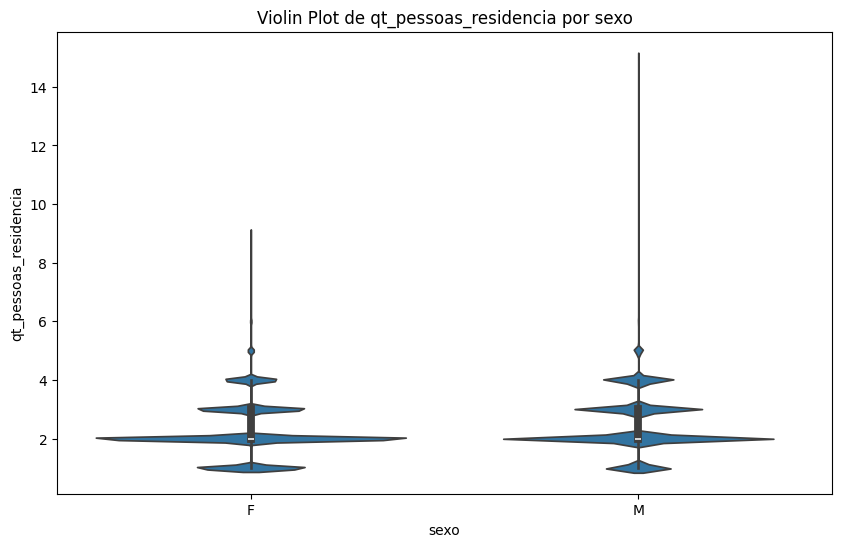


Boxplot de renda por sexo:


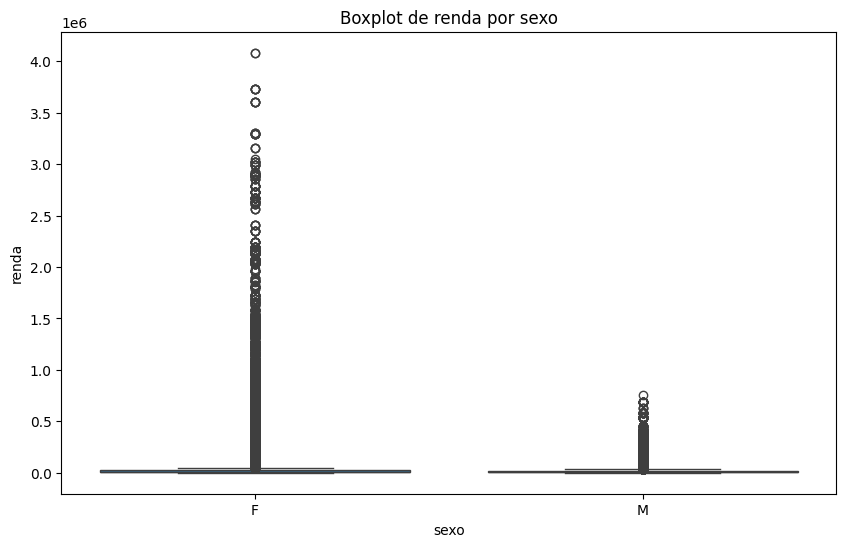


Violin Plot de renda por sexo:


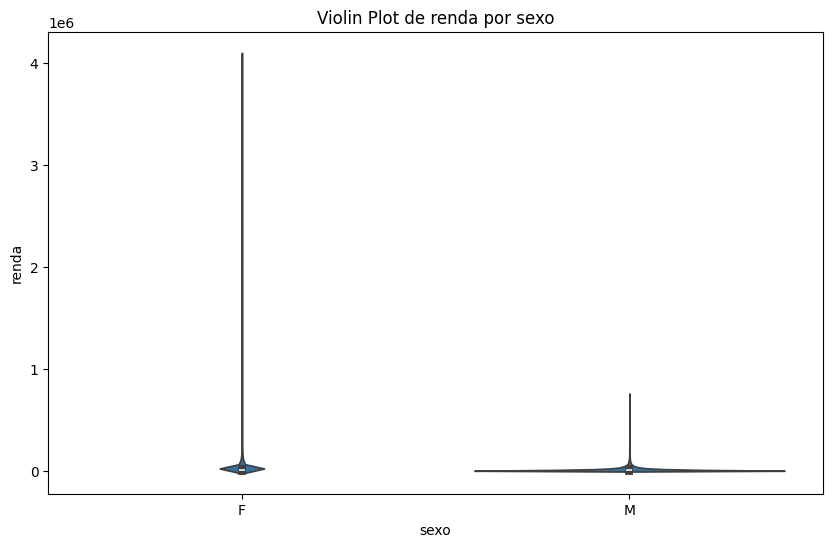


Boxplot de level_0 por posse_de_veiculo:


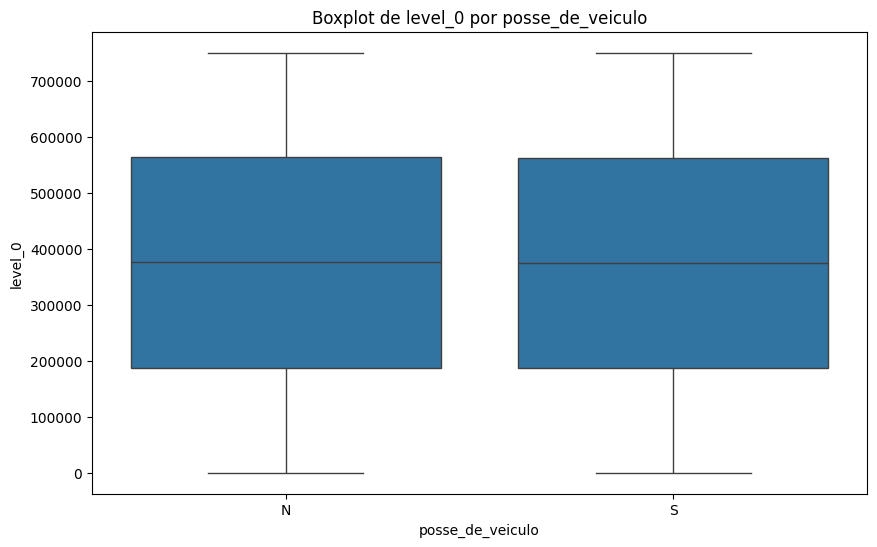


Violin Plot de level_0 por posse_de_veiculo:


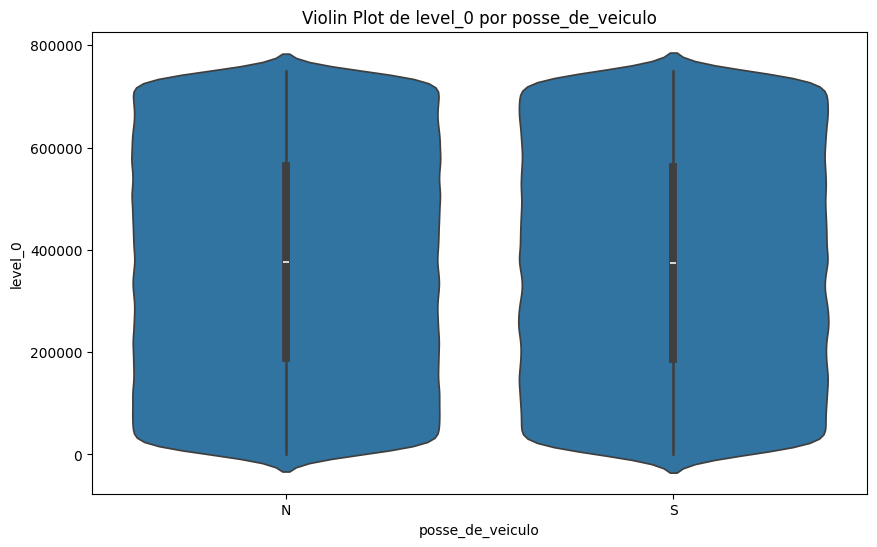


Boxplot de index por posse_de_veiculo:


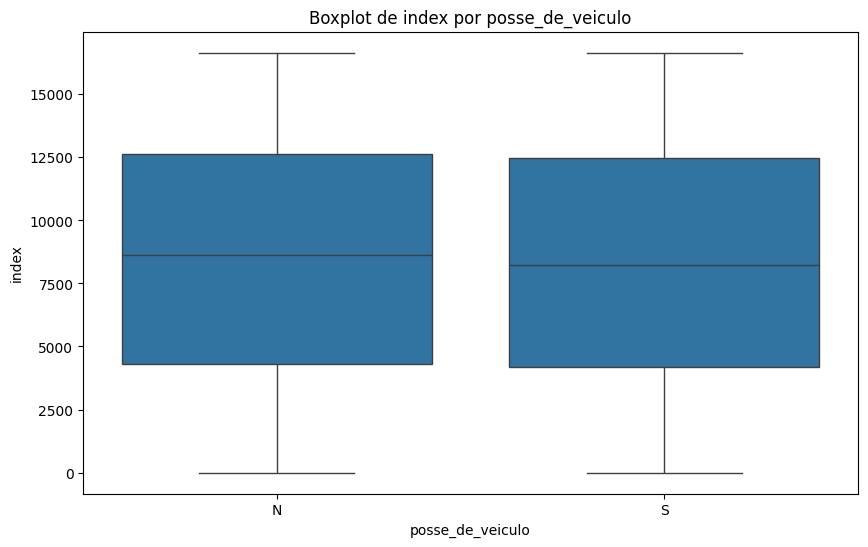


Violin Plot de index por posse_de_veiculo:


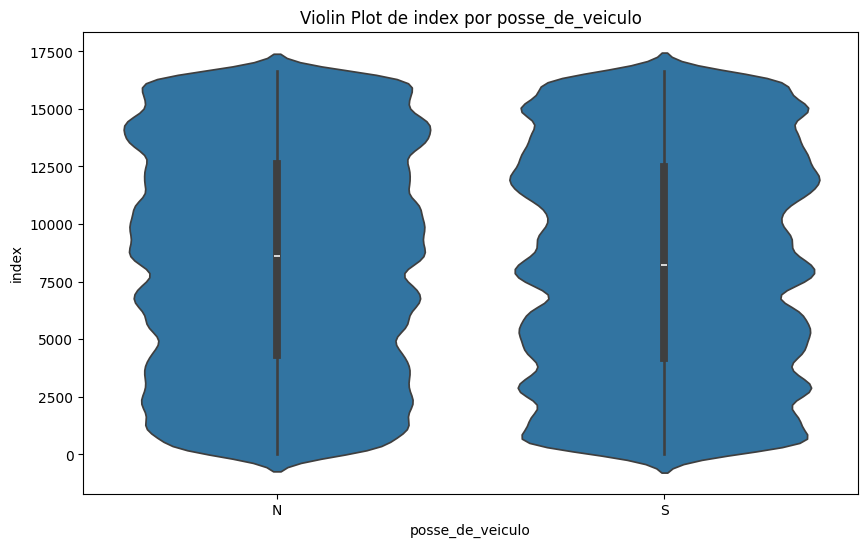


Boxplot de qtd_filhos por posse_de_veiculo:


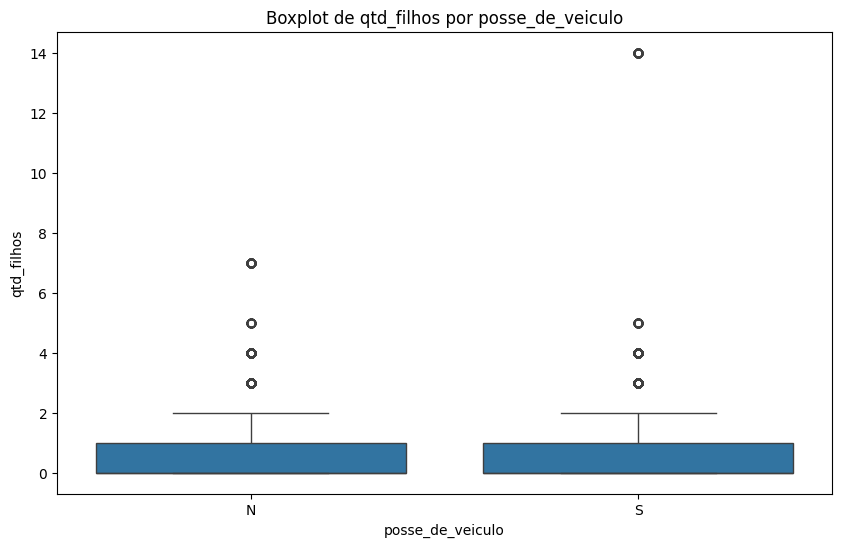


Violin Plot de qtd_filhos por posse_de_veiculo:


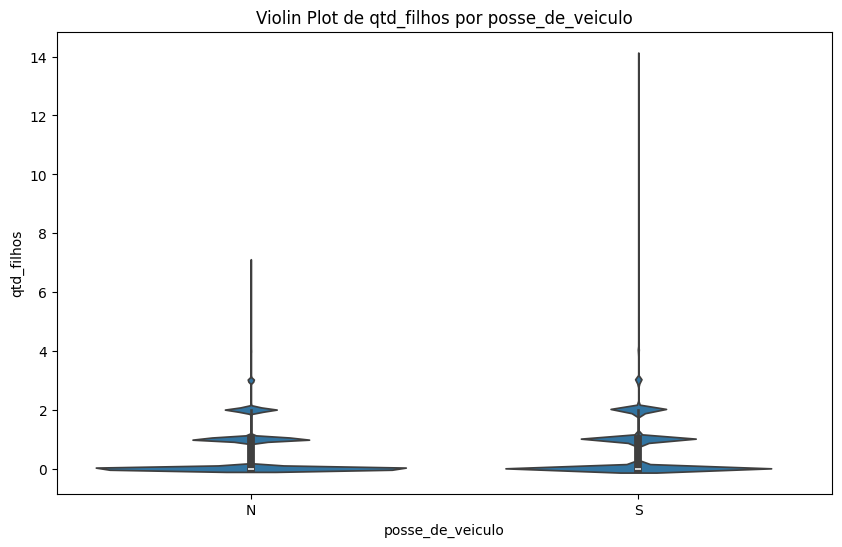


Boxplot de idade por posse_de_veiculo:


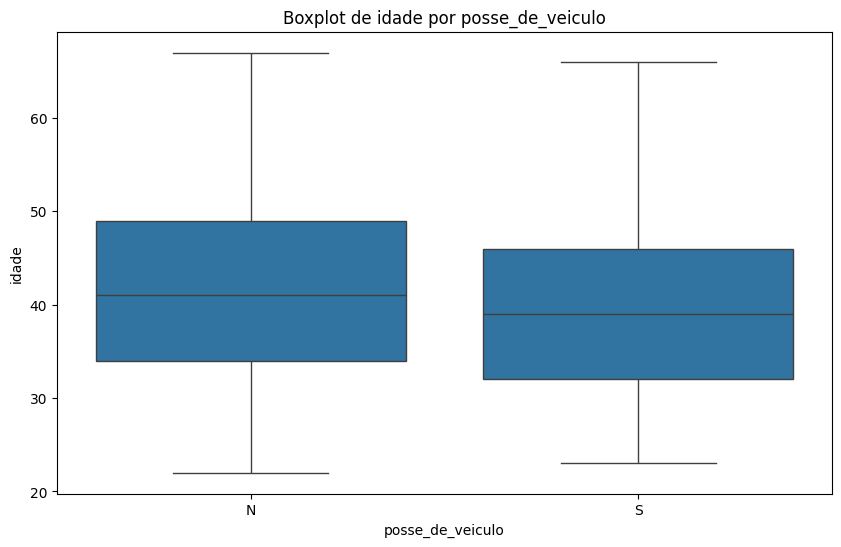


Violin Plot de idade por posse_de_veiculo:


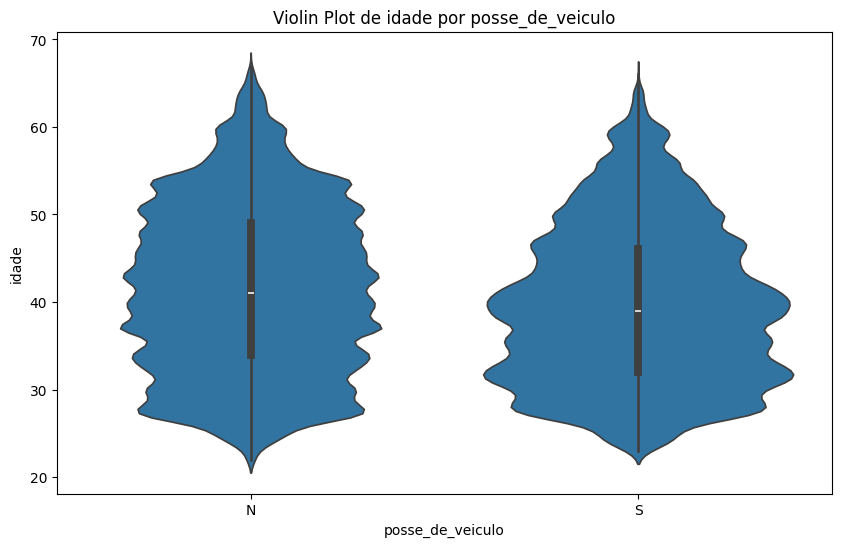


Boxplot de tempo_emprego por posse_de_veiculo:


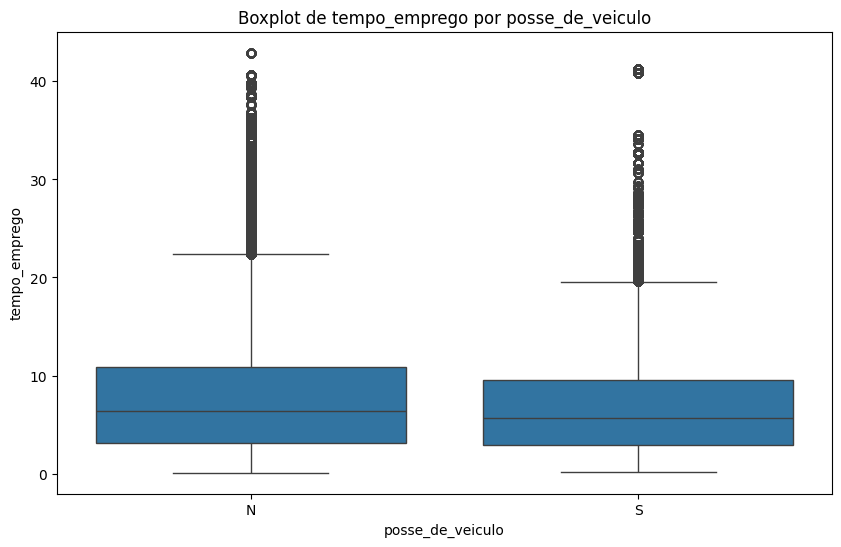


Violin Plot de tempo_emprego por posse_de_veiculo:


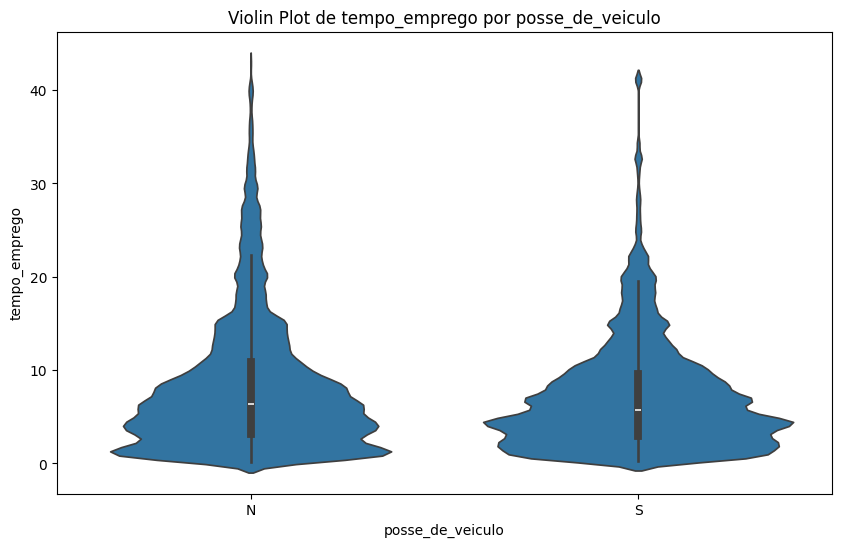


Boxplot de qt_pessoas_residencia por posse_de_veiculo:


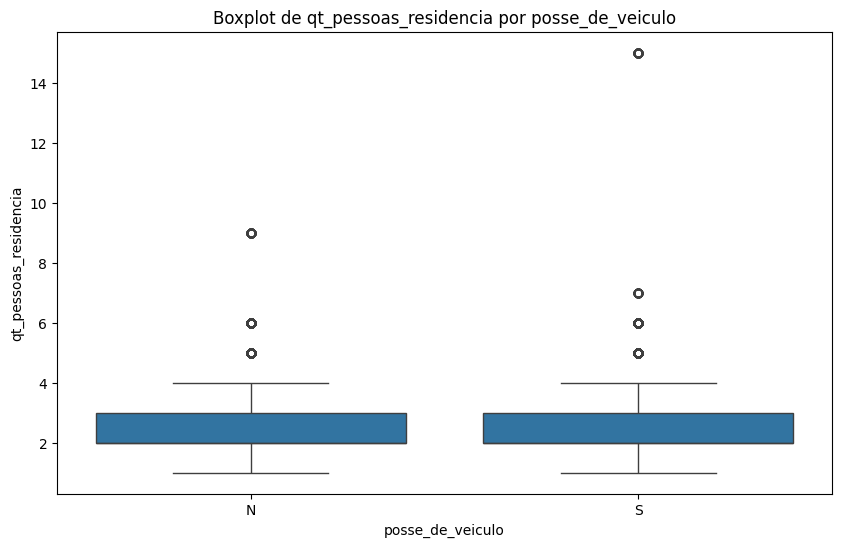


Violin Plot de qt_pessoas_residencia por posse_de_veiculo:


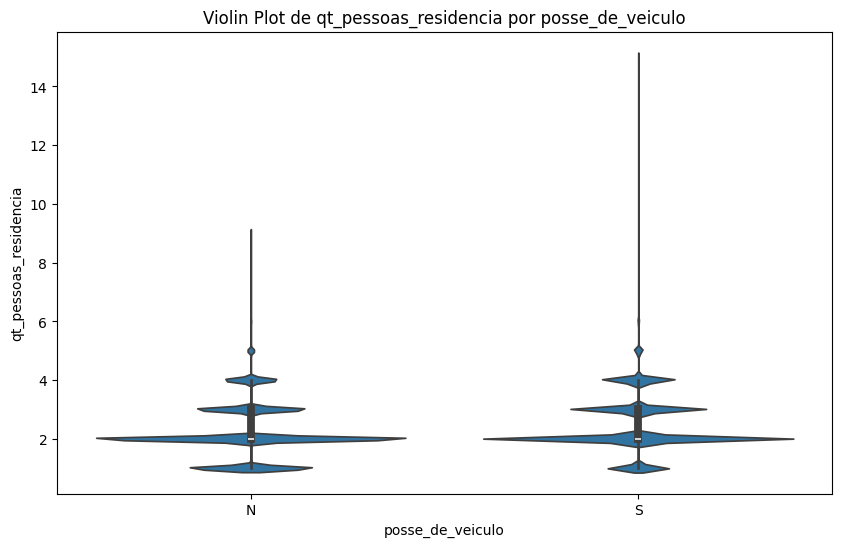


Boxplot de renda por posse_de_veiculo:


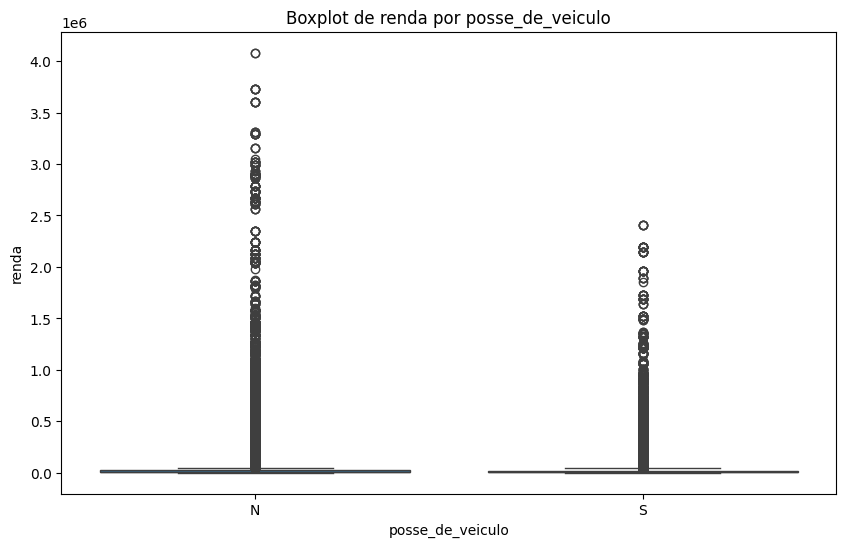


Violin Plot de renda por posse_de_veiculo:


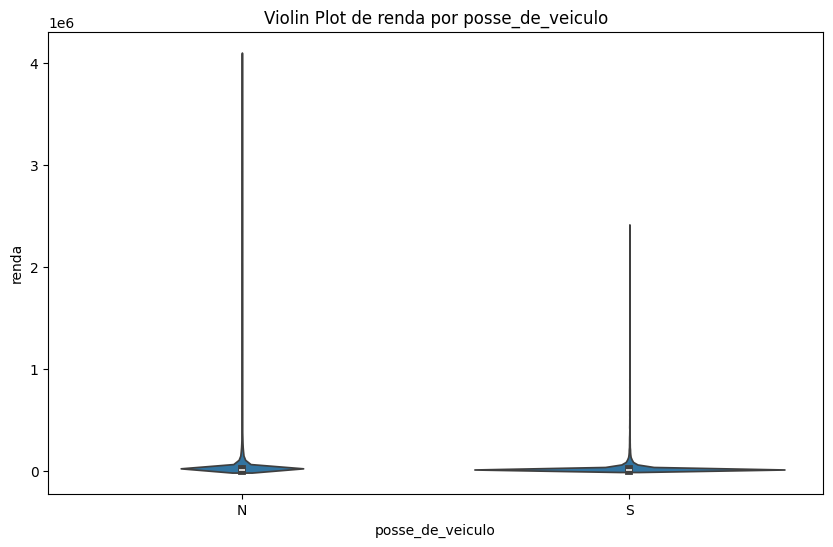


Boxplot de level_0 por posse_de_imovel:


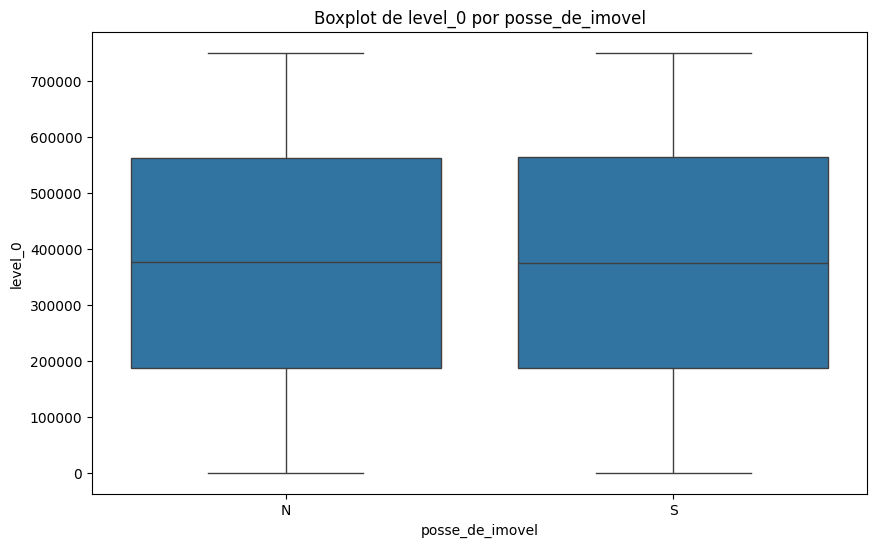


Violin Plot de level_0 por posse_de_imovel:


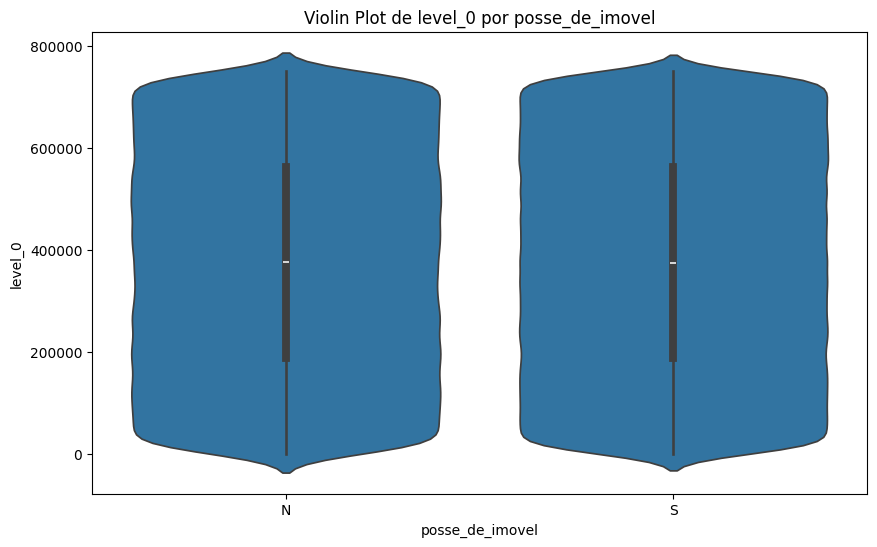


Boxplot de index por posse_de_imovel:


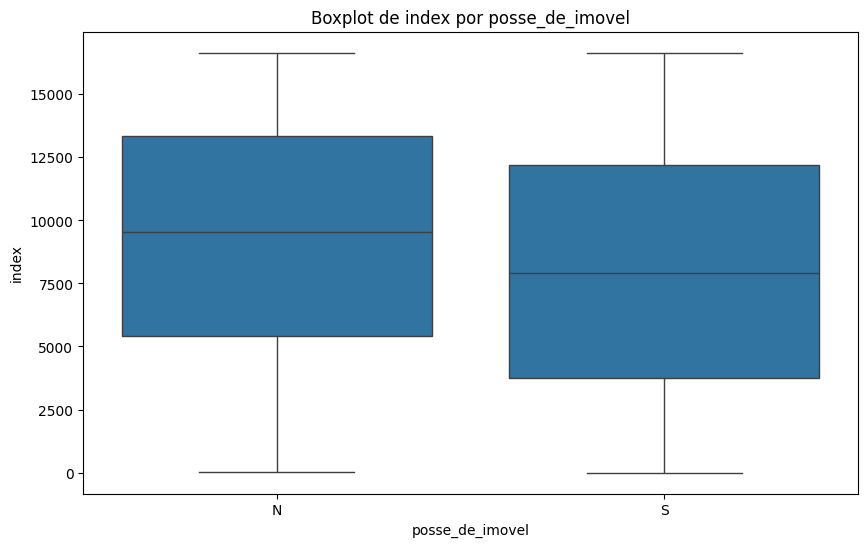


Violin Plot de index por posse_de_imovel:


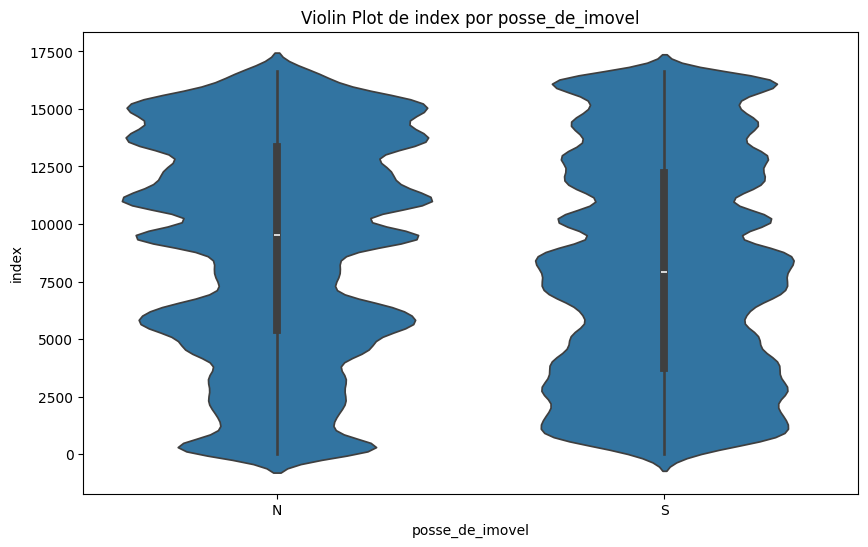


Boxplot de qtd_filhos por posse_de_imovel:


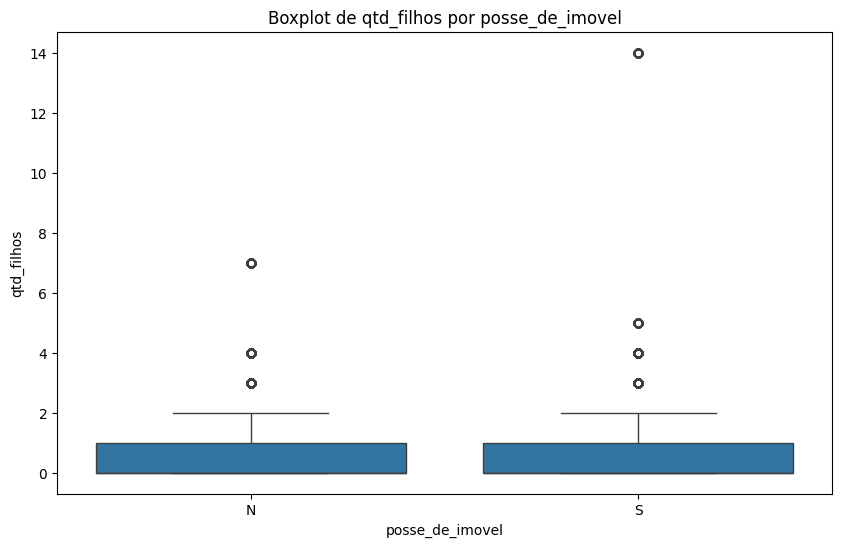


Violin Plot de qtd_filhos por posse_de_imovel:


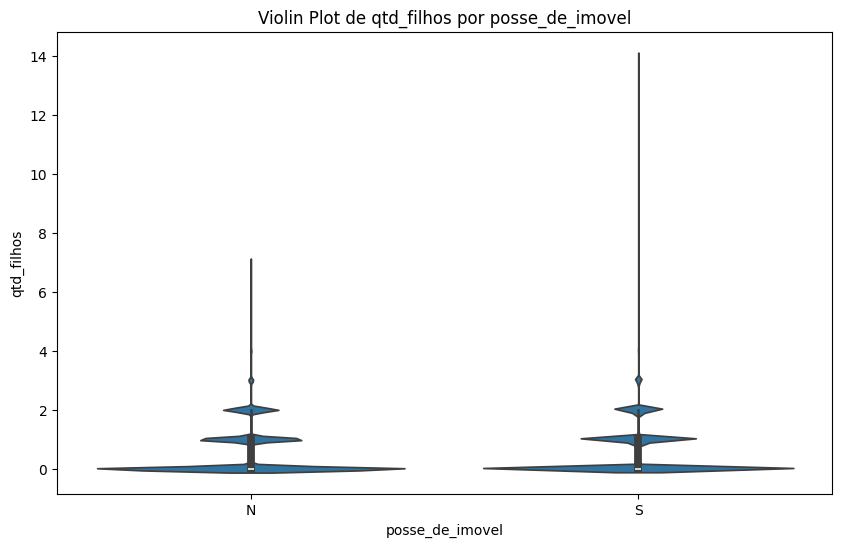


Boxplot de idade por posse_de_imovel:


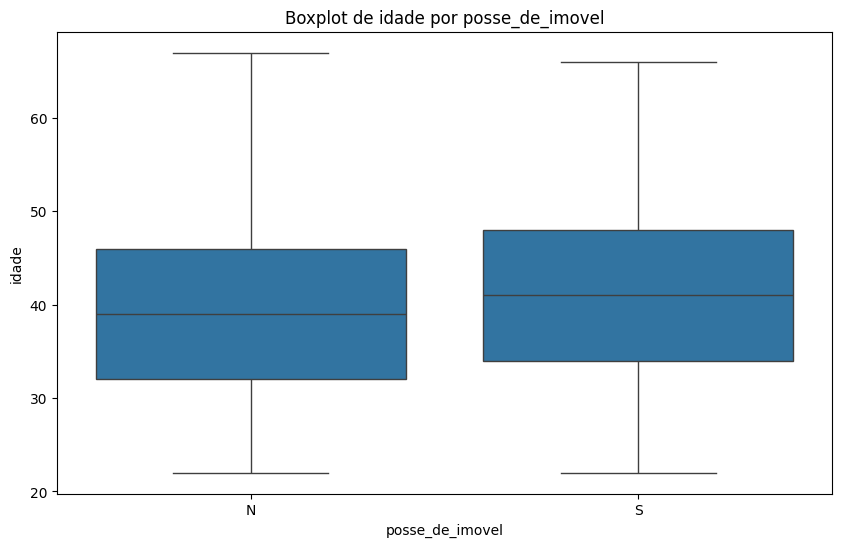


Violin Plot de idade por posse_de_imovel:


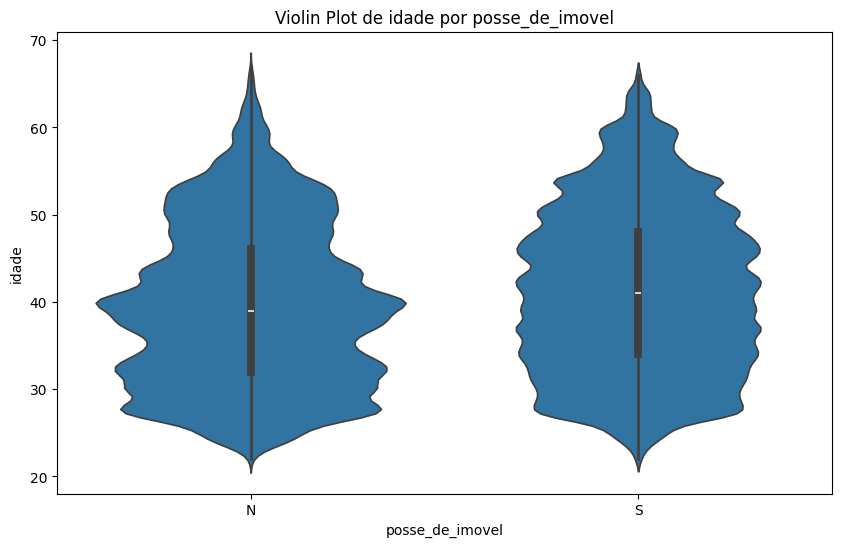


Boxplot de tempo_emprego por posse_de_imovel:


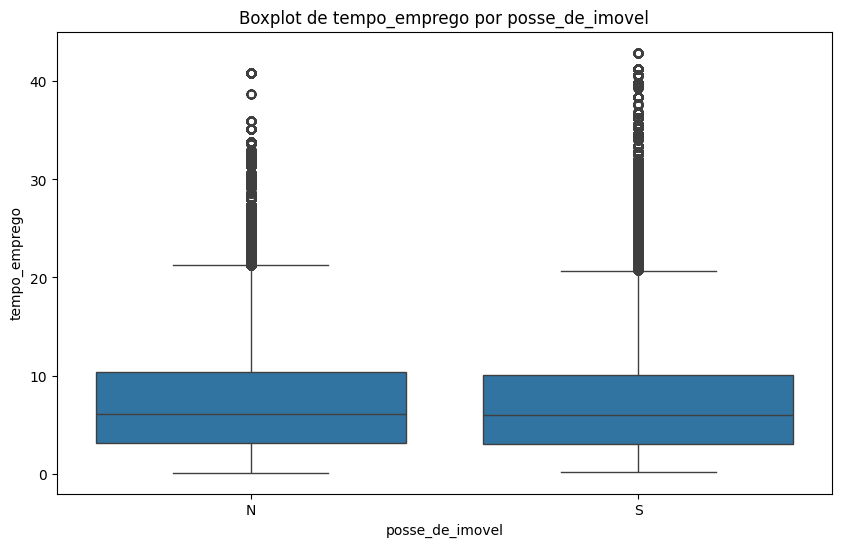


Violin Plot de tempo_emprego por posse_de_imovel:


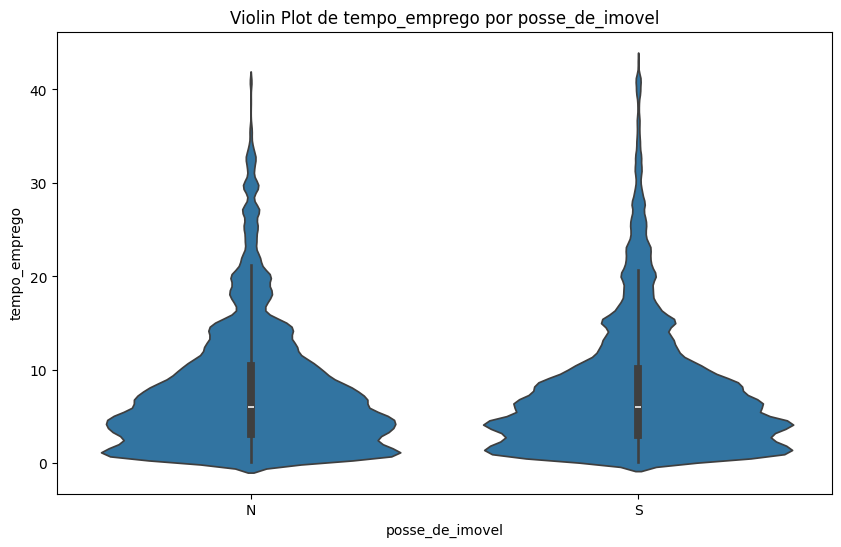


Boxplot de qt_pessoas_residencia por posse_de_imovel:


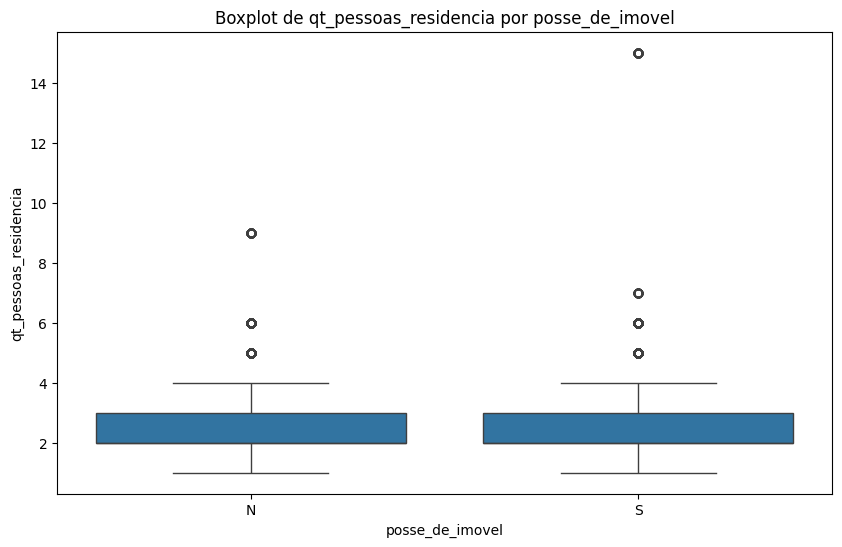


Violin Plot de qt_pessoas_residencia por posse_de_imovel:


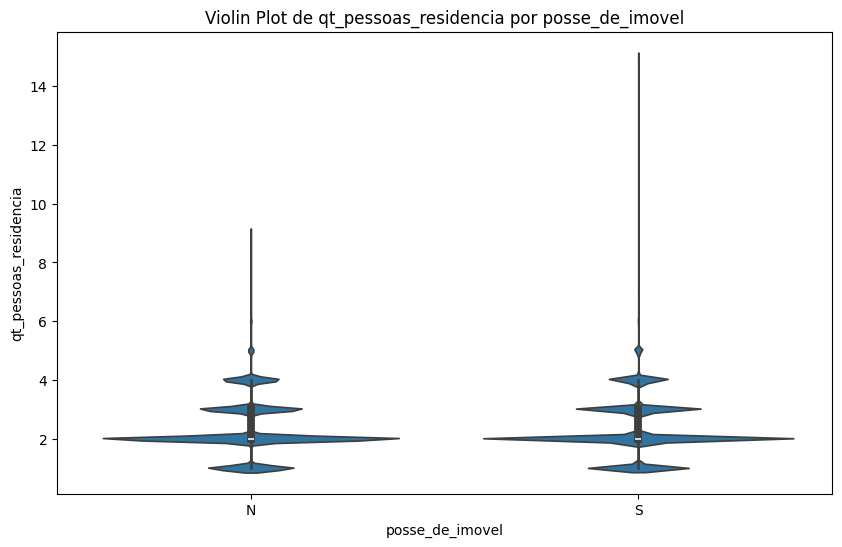


Boxplot de renda por posse_de_imovel:


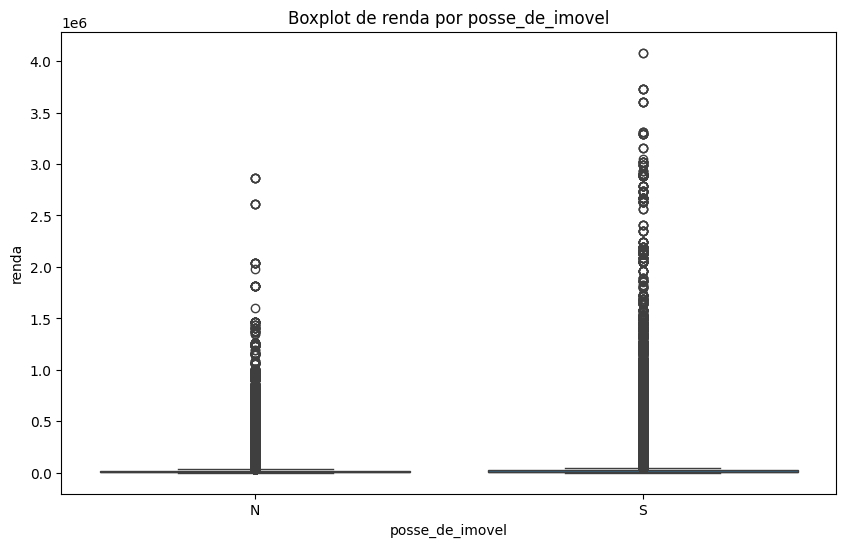


Violin Plot de renda por posse_de_imovel:


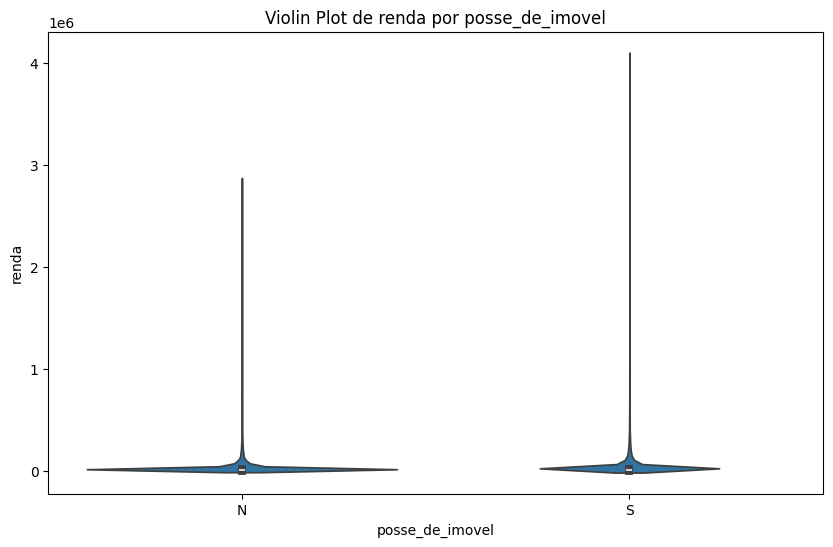


Boxplot de level_0 por tipo_renda:


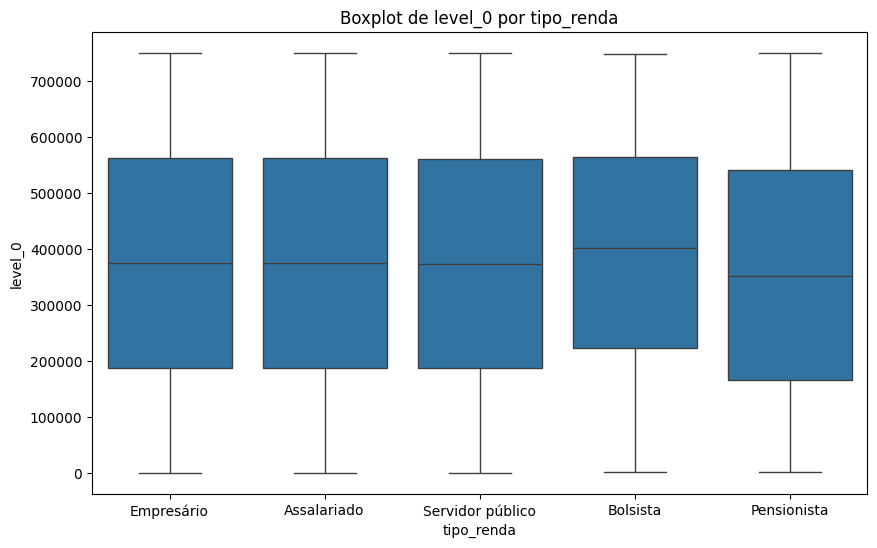


Violin Plot de level_0 por tipo_renda:


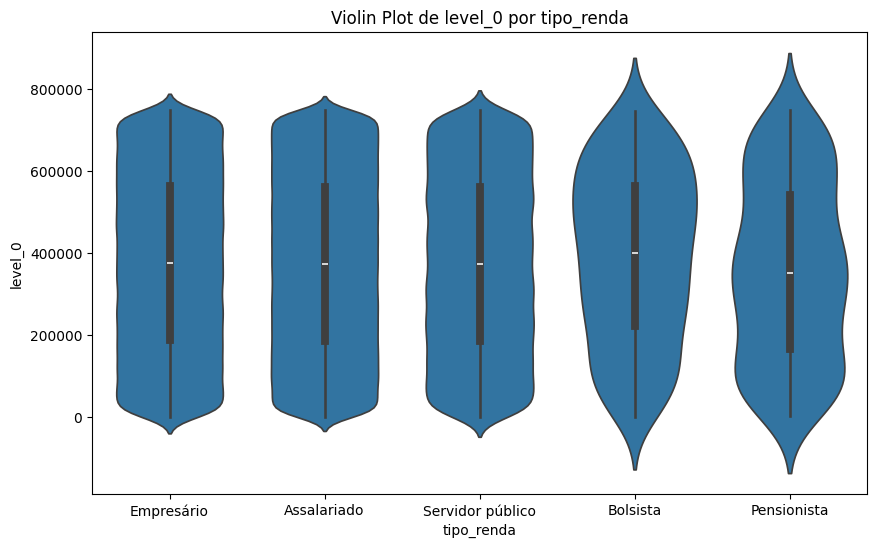


Boxplot de index por tipo_renda:


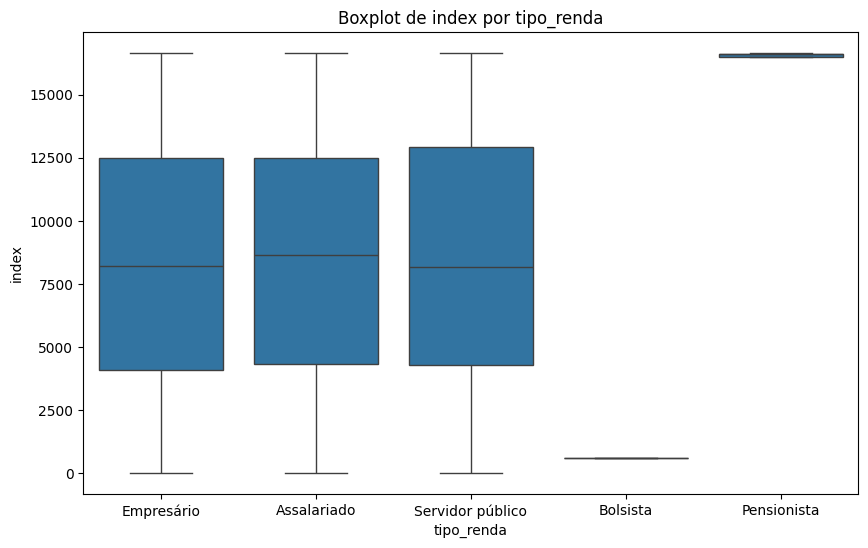


Violin Plot de index por tipo_renda:


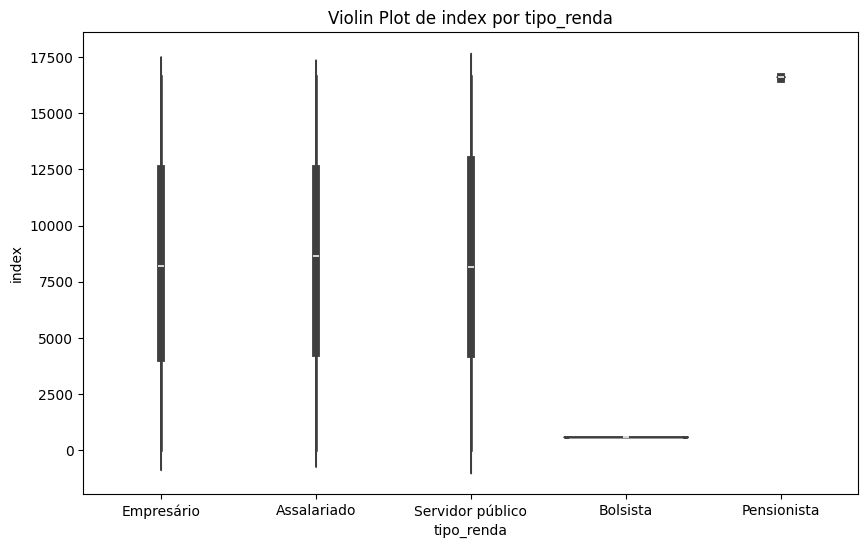


Boxplot de qtd_filhos por tipo_renda:


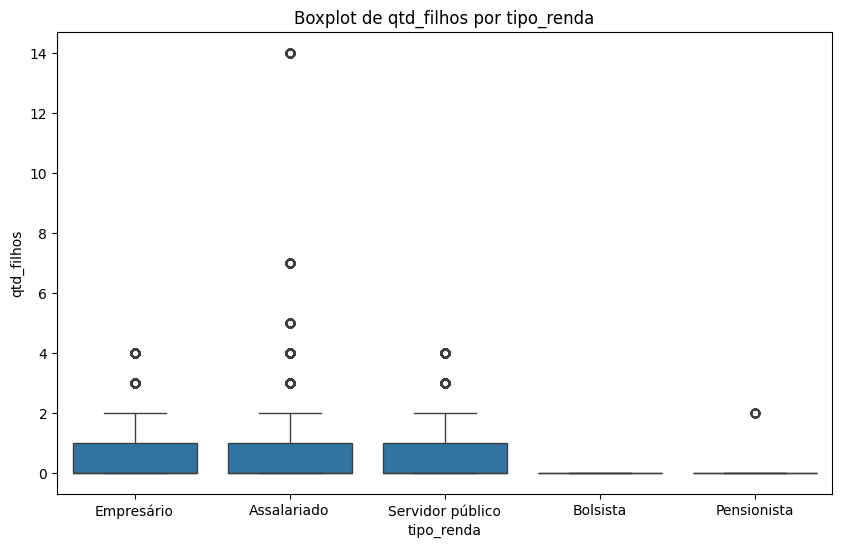


Violin Plot de qtd_filhos por tipo_renda:


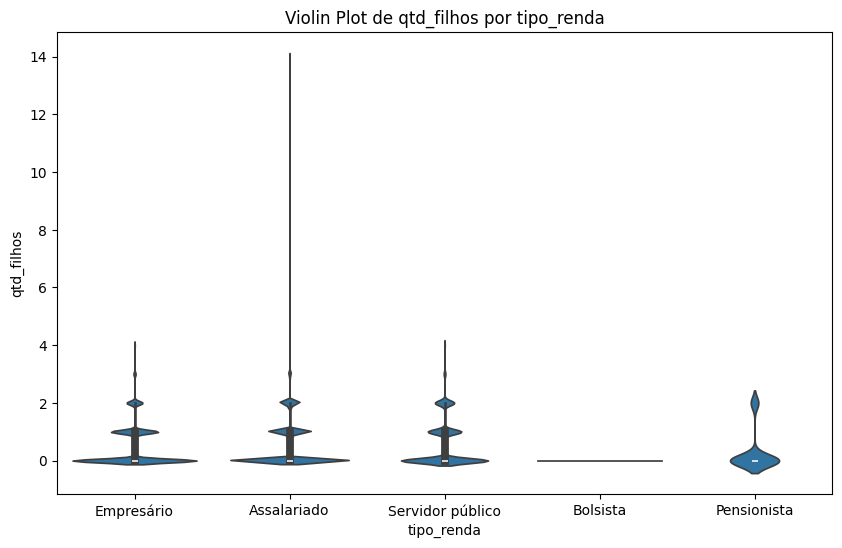


Boxplot de idade por tipo_renda:


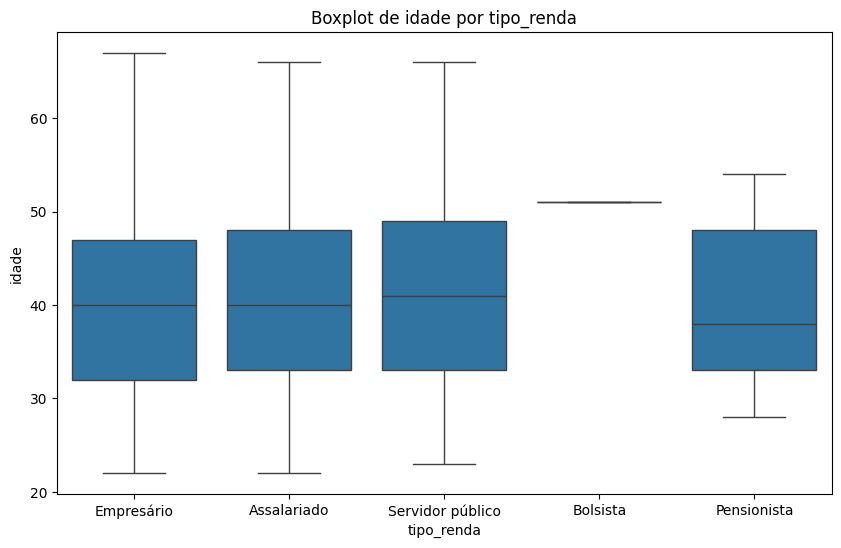


Violin Plot de idade por tipo_renda:


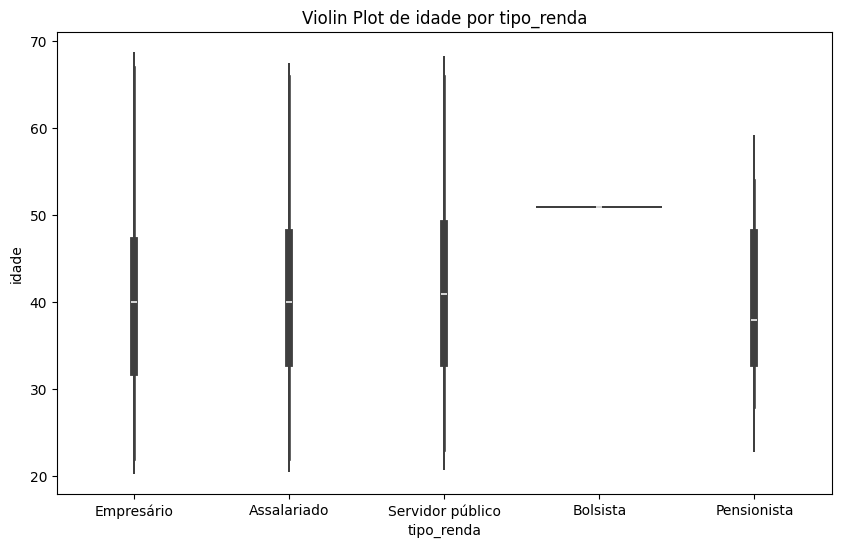


Boxplot de tempo_emprego por tipo_renda:


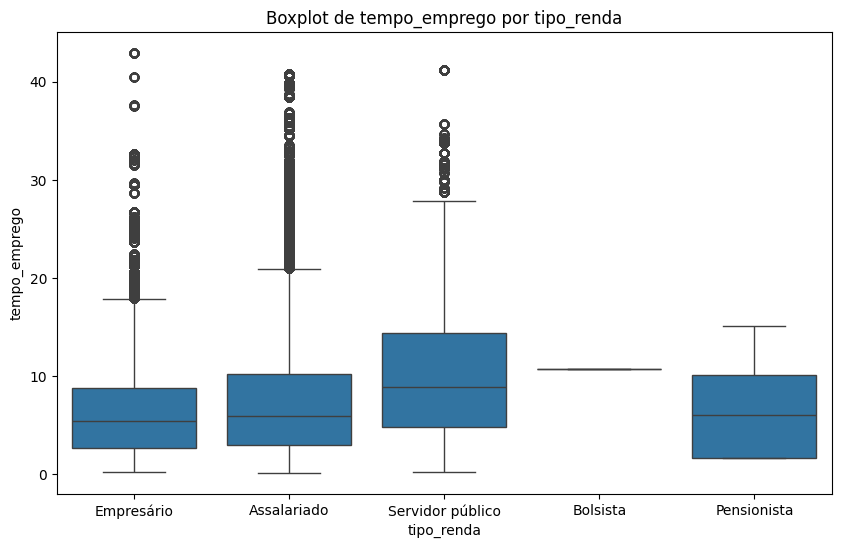


Violin Plot de tempo_emprego por tipo_renda:


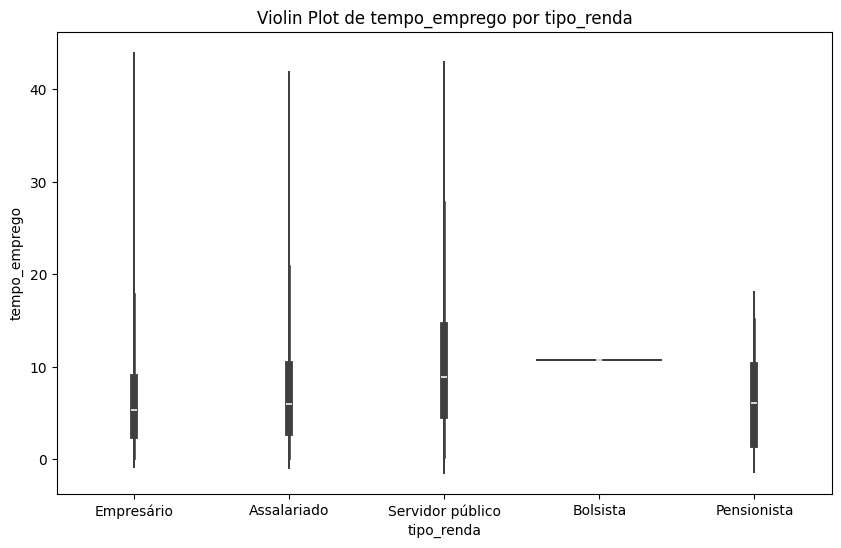


Boxplot de qt_pessoas_residencia por tipo_renda:


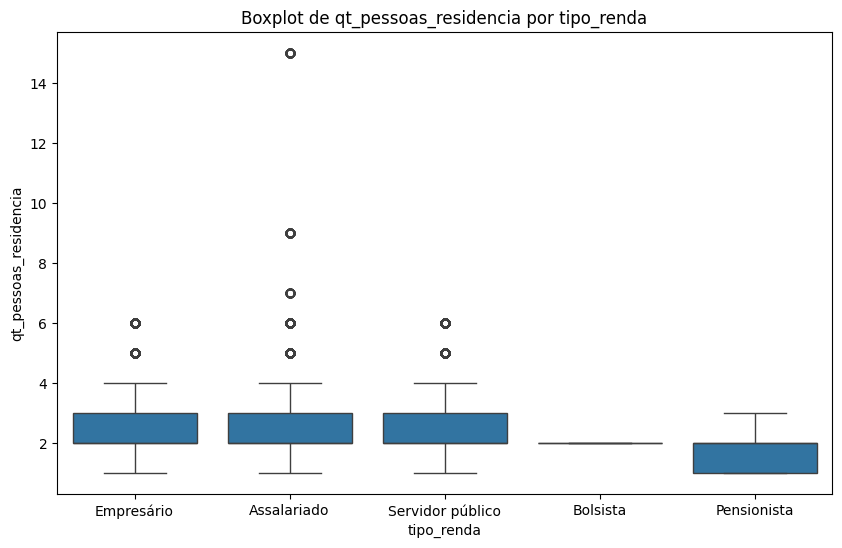


Violin Plot de qt_pessoas_residencia por tipo_renda:


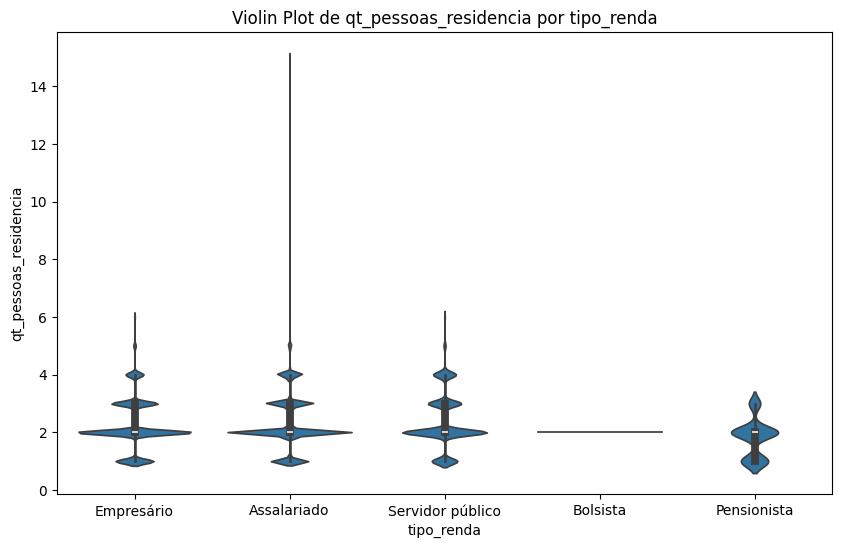


Boxplot de renda por tipo_renda:


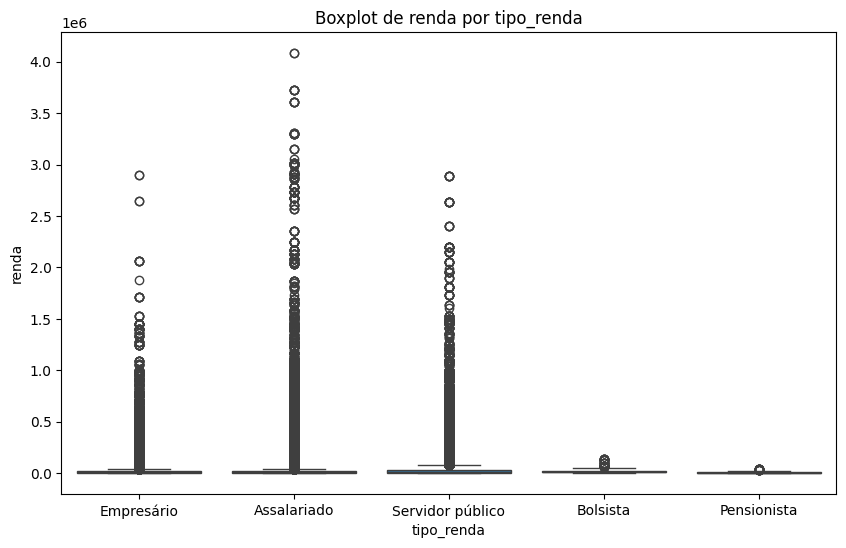


Violin Plot de renda por tipo_renda:


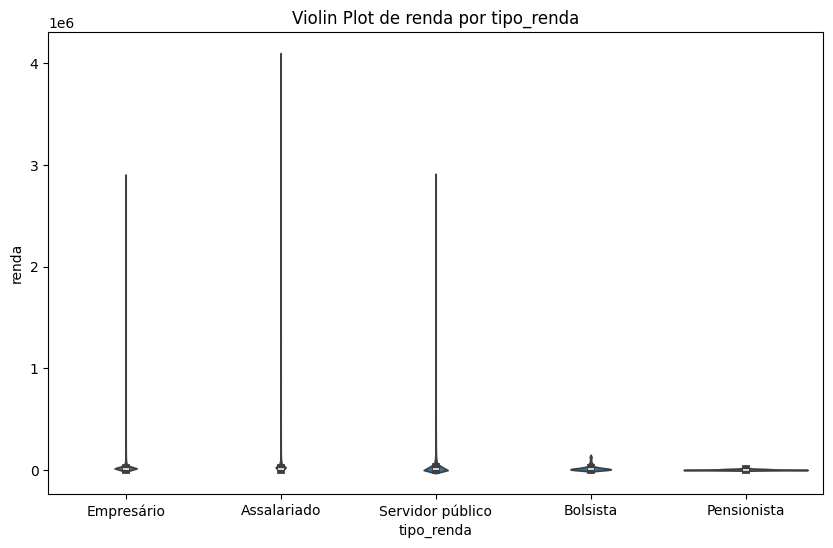


Boxplot de level_0 por educacao:


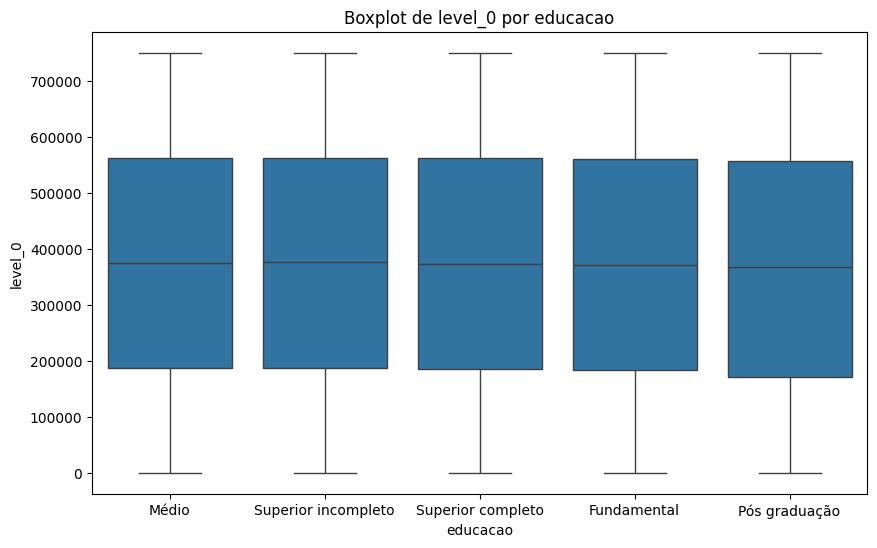


Violin Plot de level_0 por educacao:


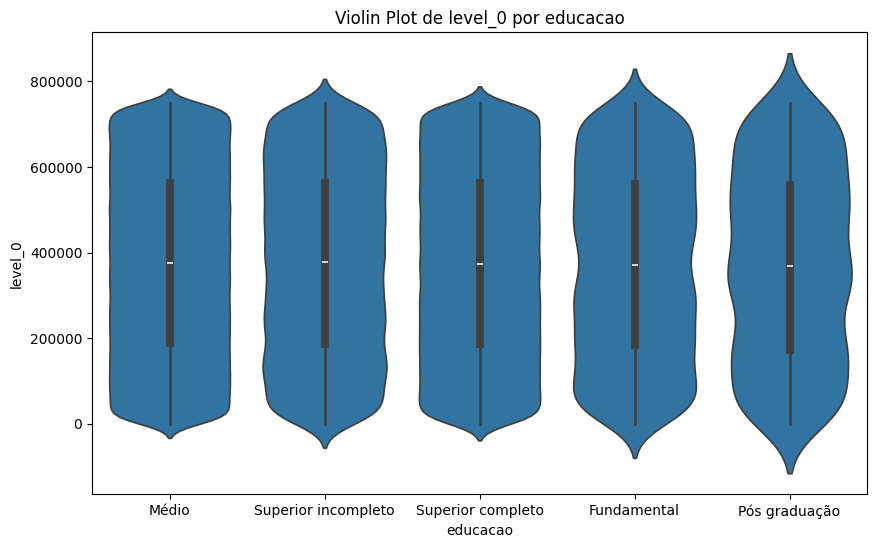


Boxplot de index por educacao:


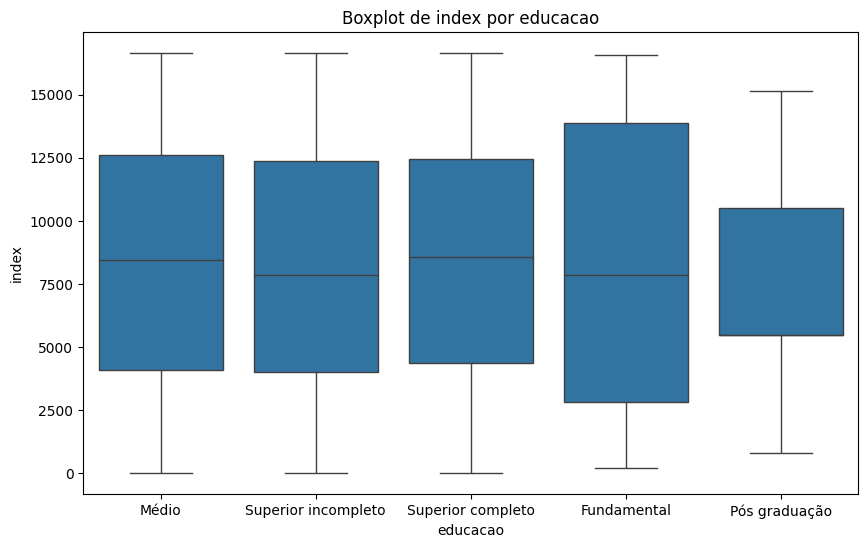


Violin Plot de index por educacao:


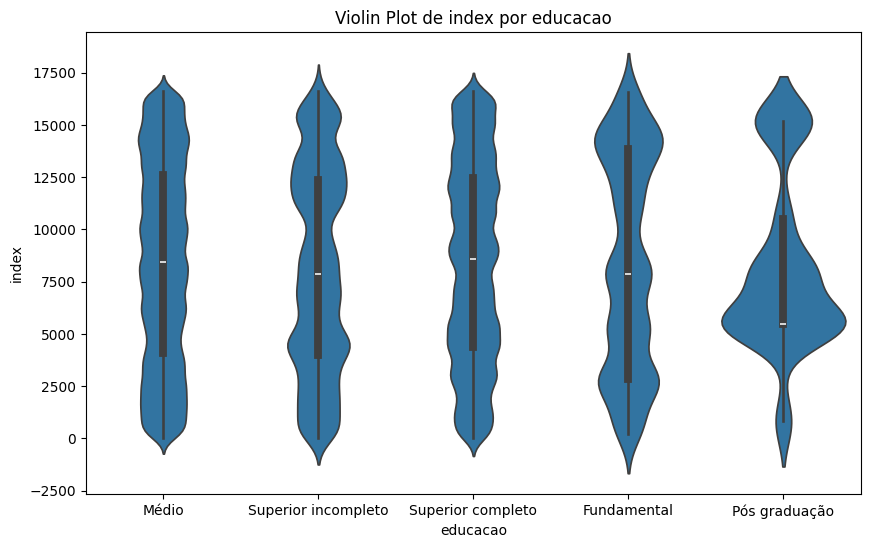


Boxplot de qtd_filhos por educacao:


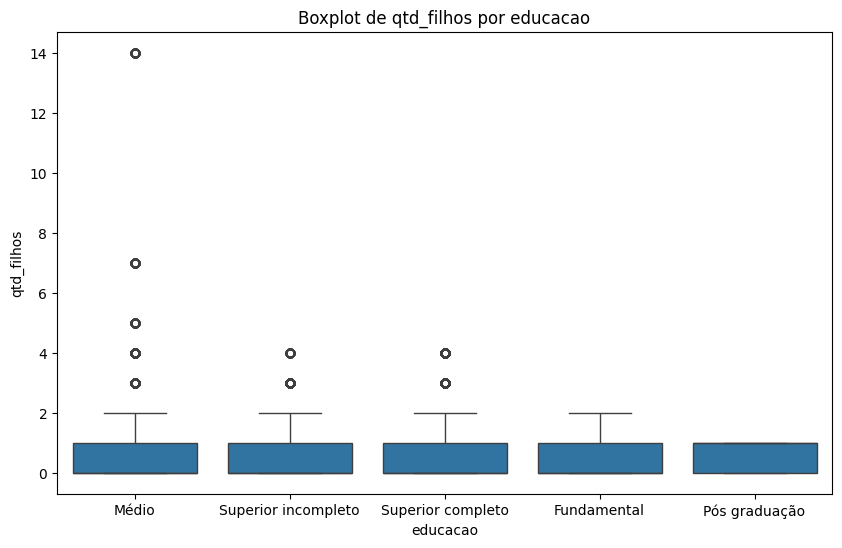


Violin Plot de qtd_filhos por educacao:


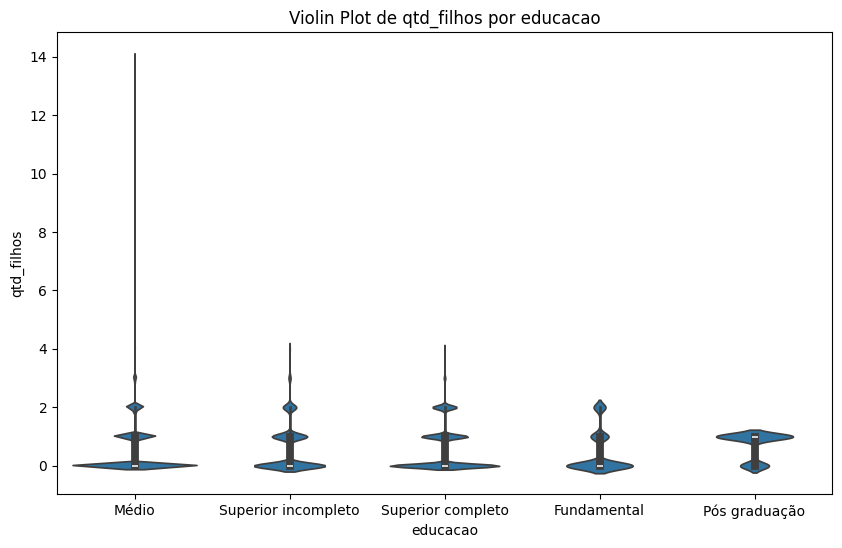


Boxplot de idade por educacao:


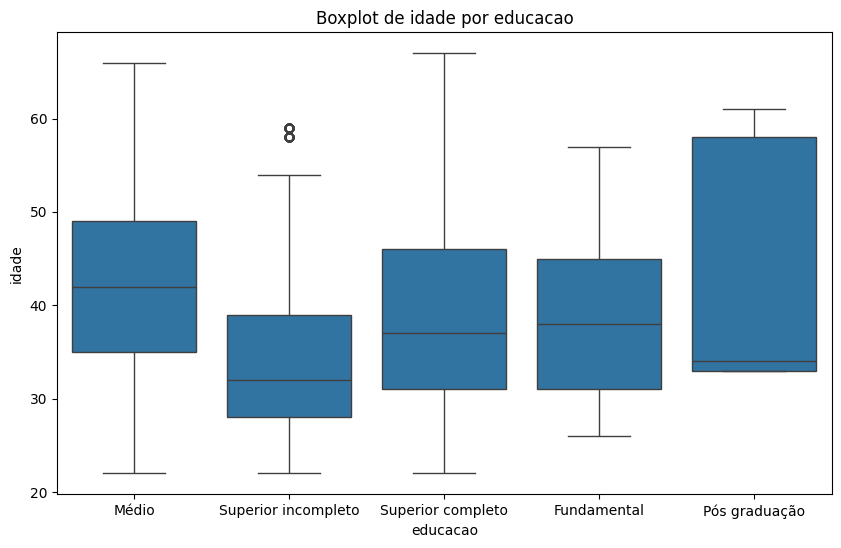


Violin Plot de idade por educacao:


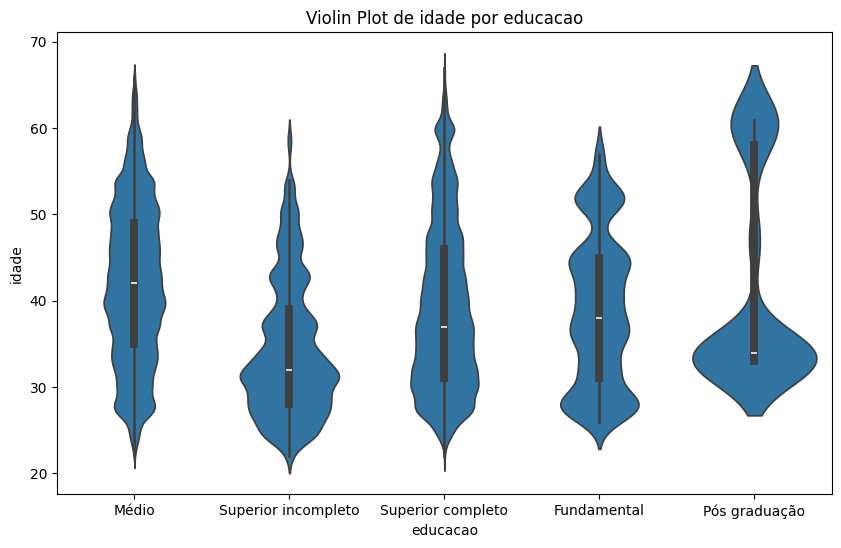


Boxplot de tempo_emprego por educacao:


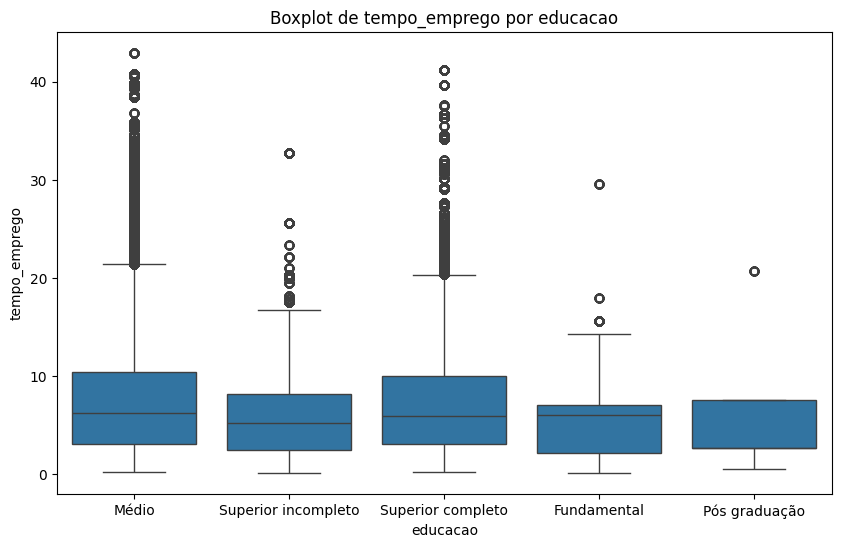


Violin Plot de tempo_emprego por educacao:


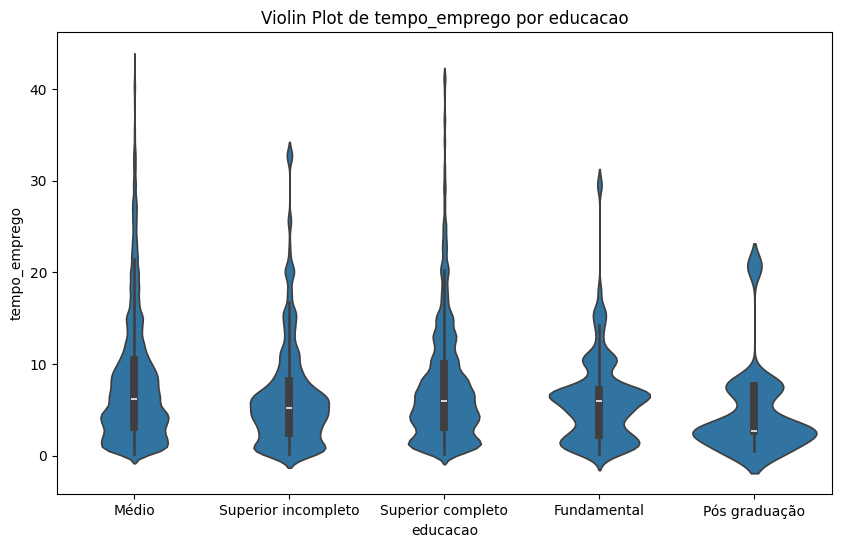


Boxplot de qt_pessoas_residencia por educacao:


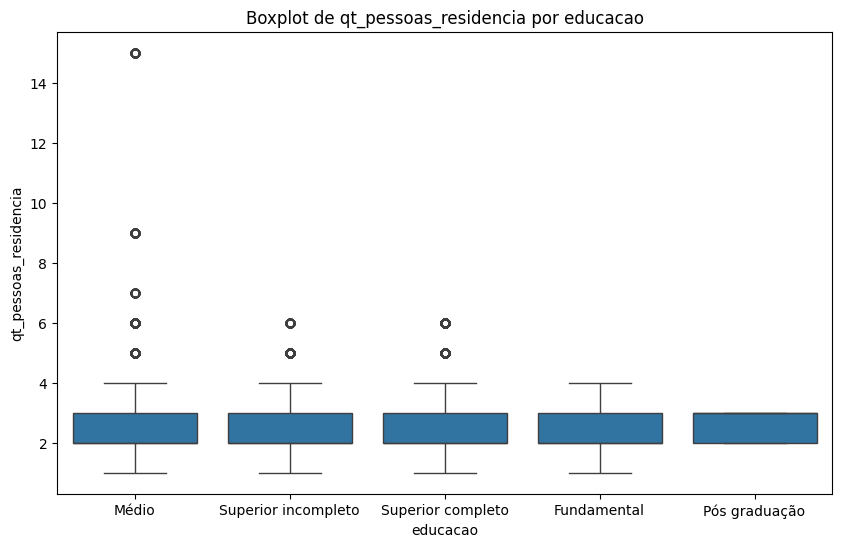


Violin Plot de qt_pessoas_residencia por educacao:


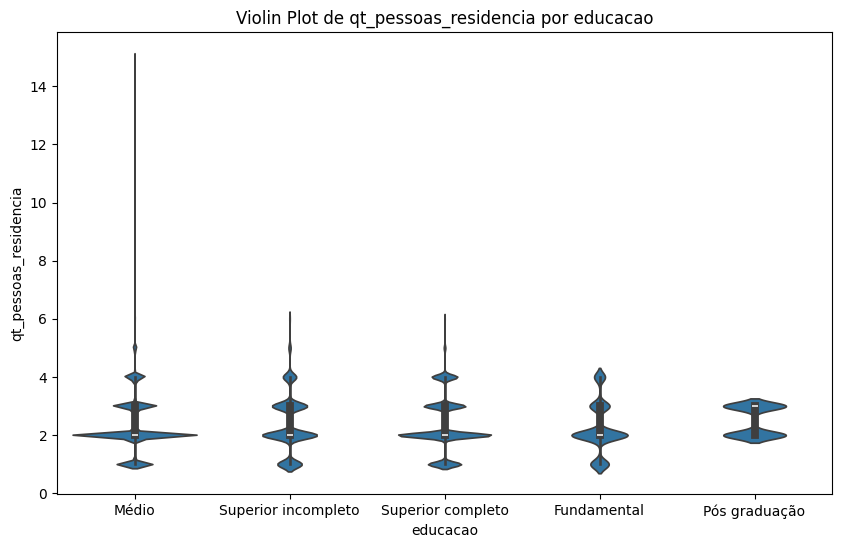


Boxplot de renda por educacao:


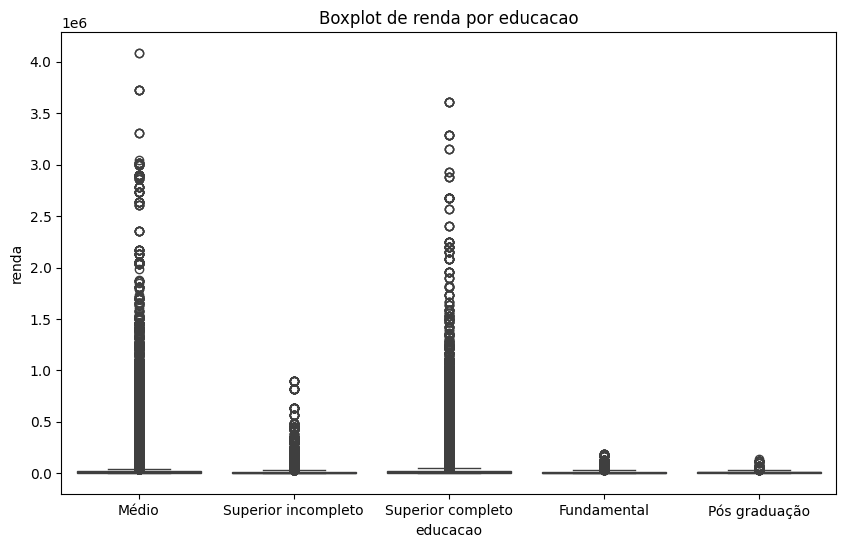


Violin Plot de renda por educacao:


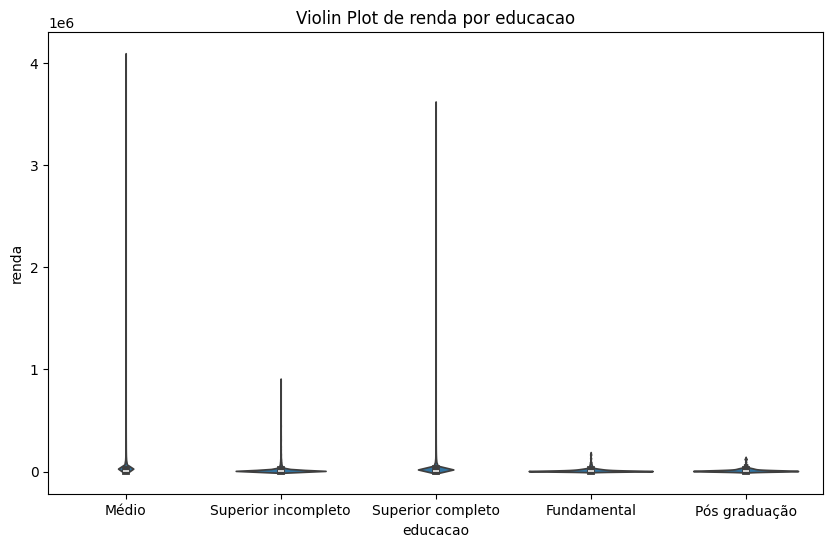


Boxplot de level_0 por estado_civil:


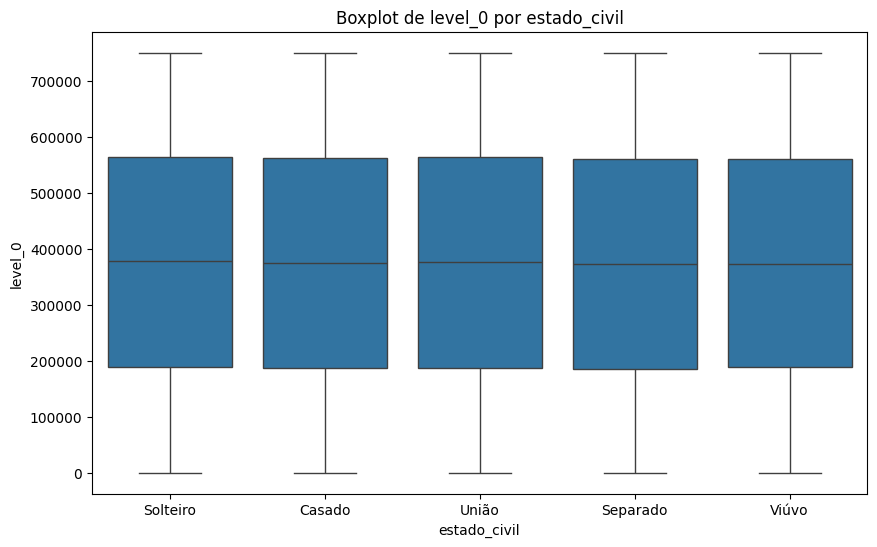


Violin Plot de level_0 por estado_civil:


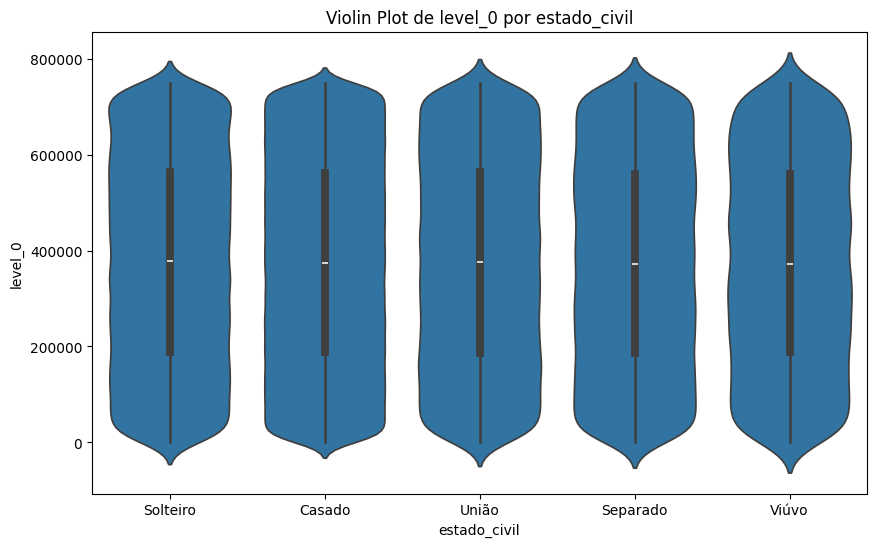


Boxplot de index por estado_civil:


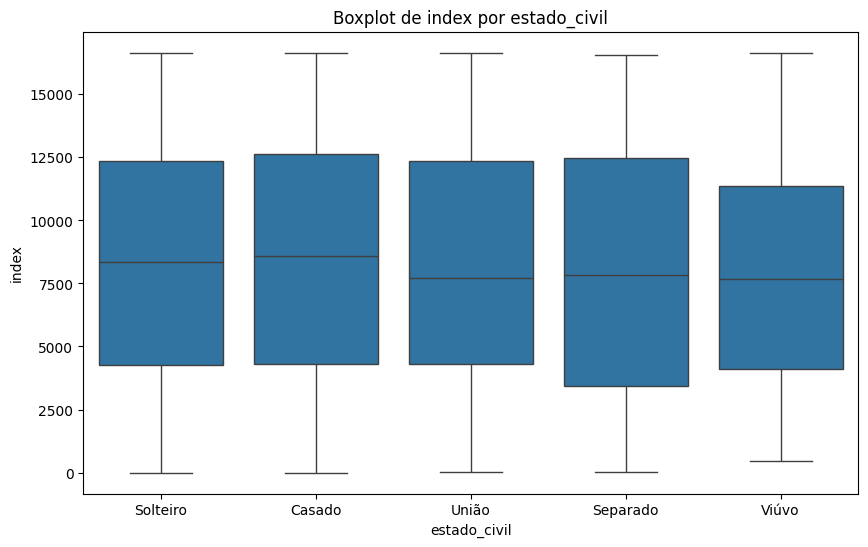


Violin Plot de index por estado_civil:


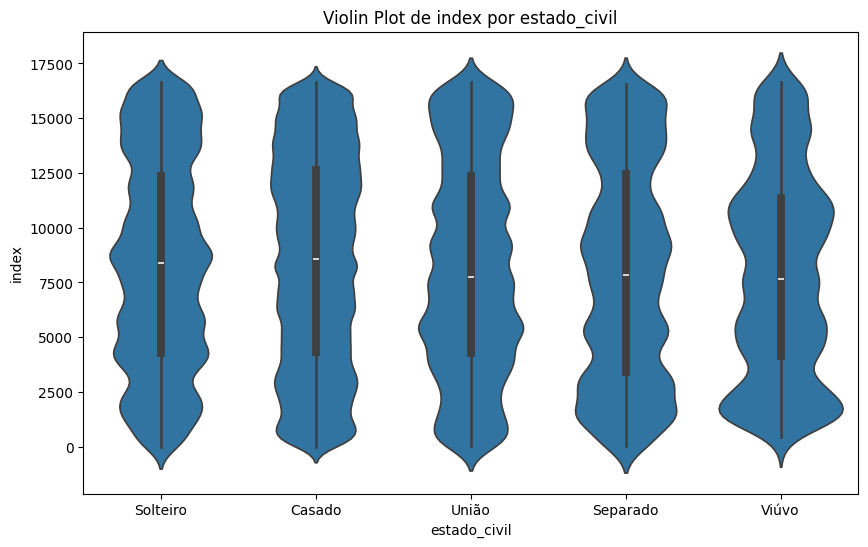


Boxplot de qtd_filhos por estado_civil:


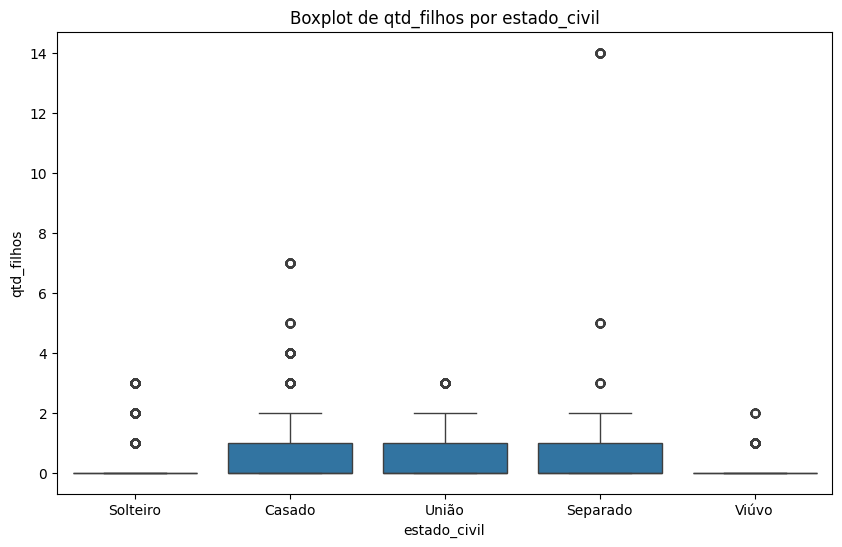


Violin Plot de qtd_filhos por estado_civil:


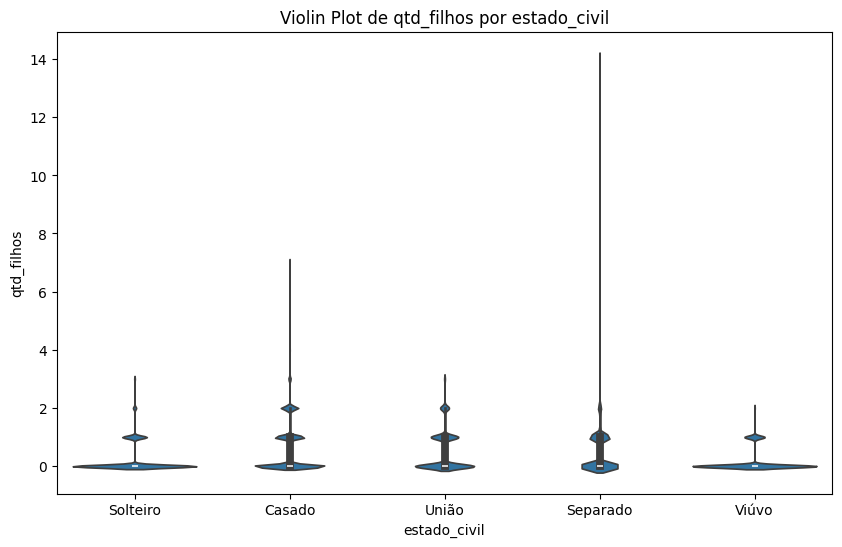


Boxplot de idade por estado_civil:


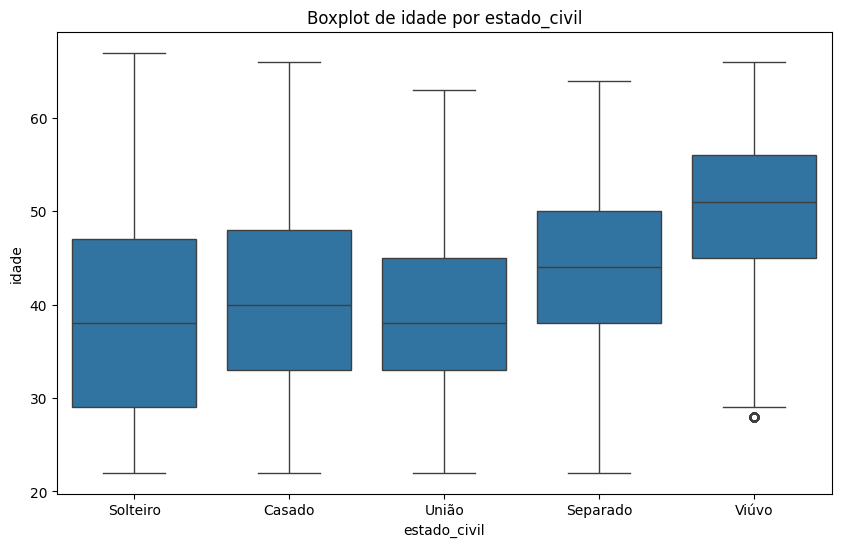


Violin Plot de idade por estado_civil:


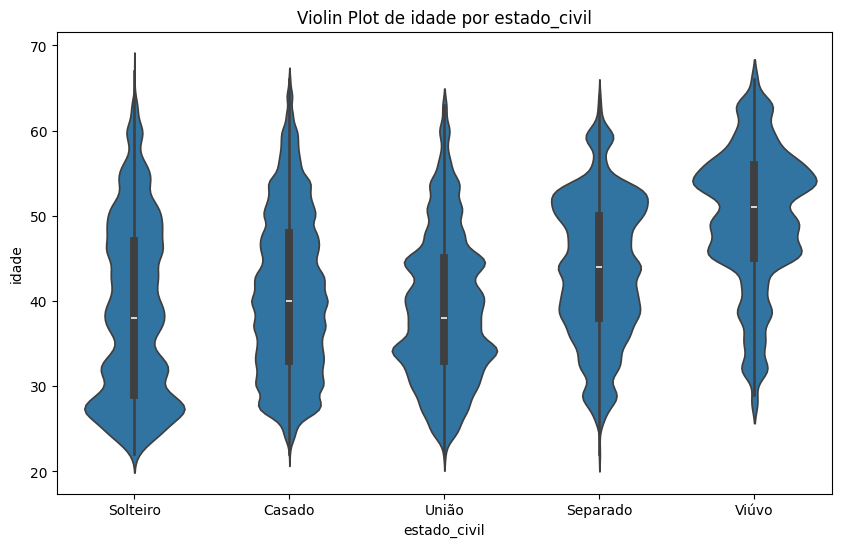


Boxplot de tempo_emprego por estado_civil:


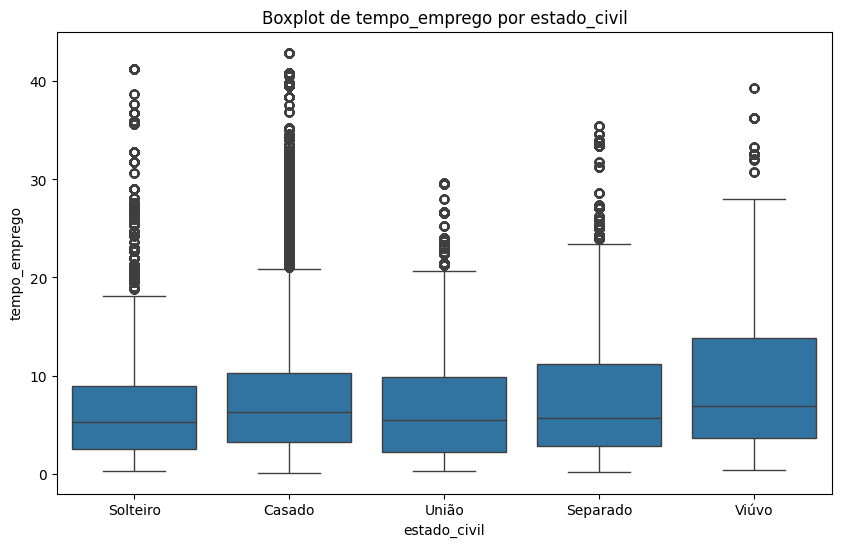


Violin Plot de tempo_emprego por estado_civil:


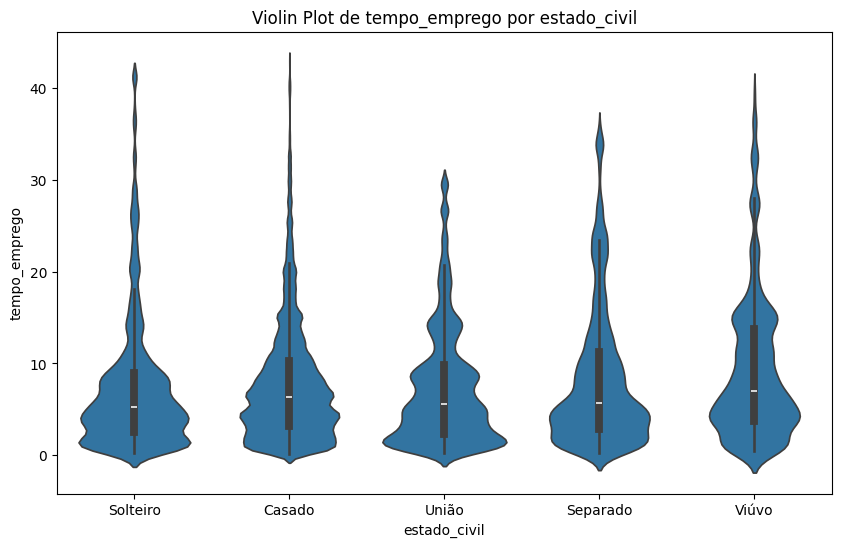


Boxplot de qt_pessoas_residencia por estado_civil:


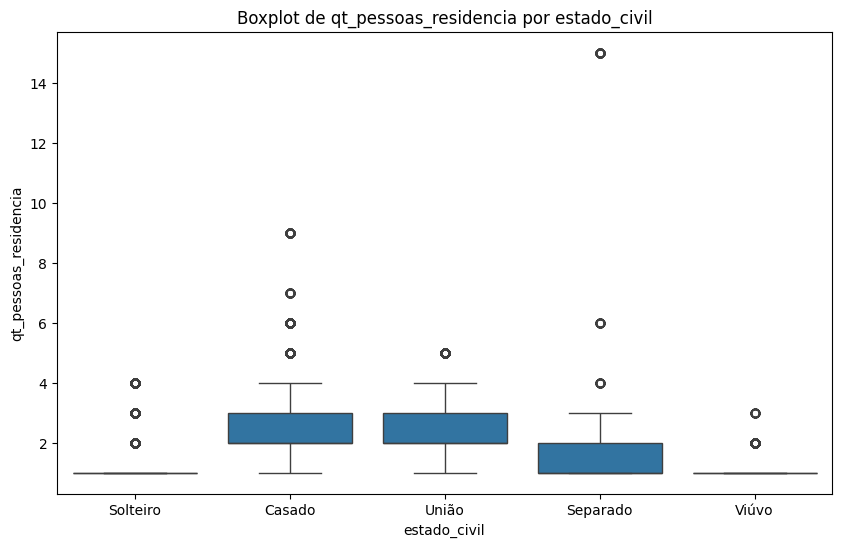


Violin Plot de qt_pessoas_residencia por estado_civil:


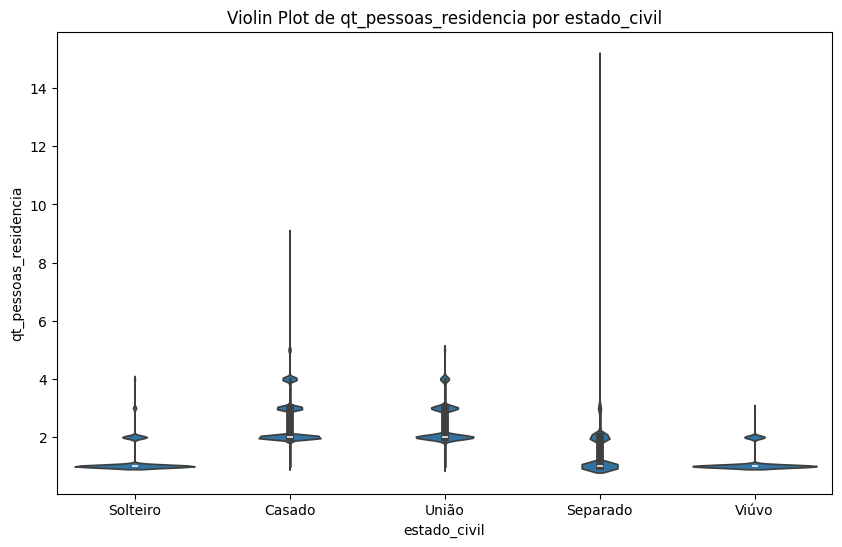


Boxplot de renda por estado_civil:


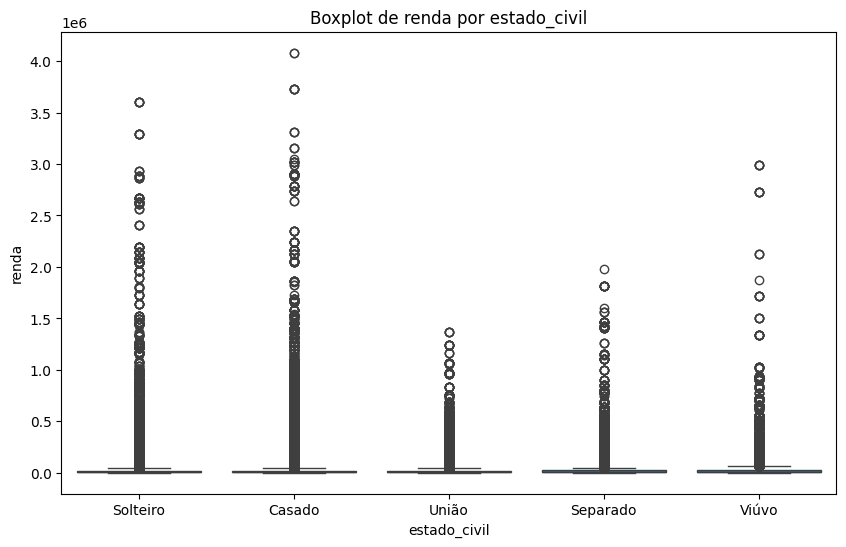


Violin Plot de renda por estado_civil:


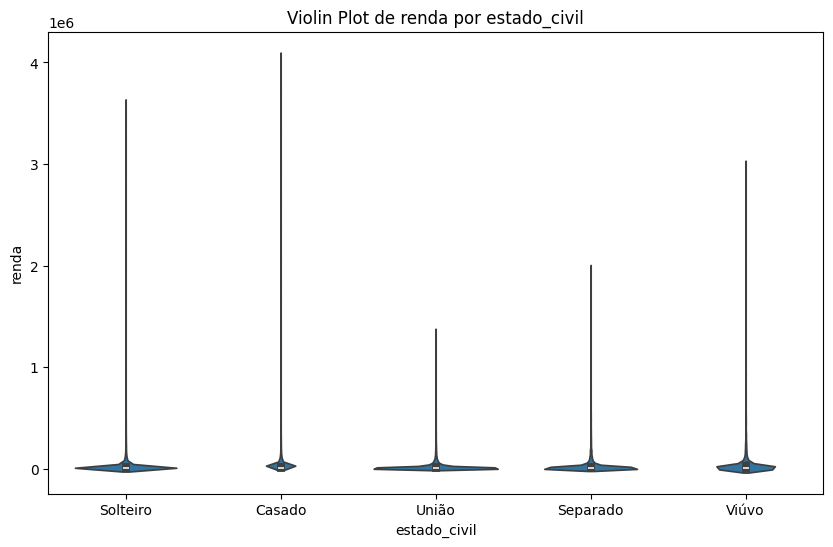


Boxplot de level_0 por tipo_residencia:


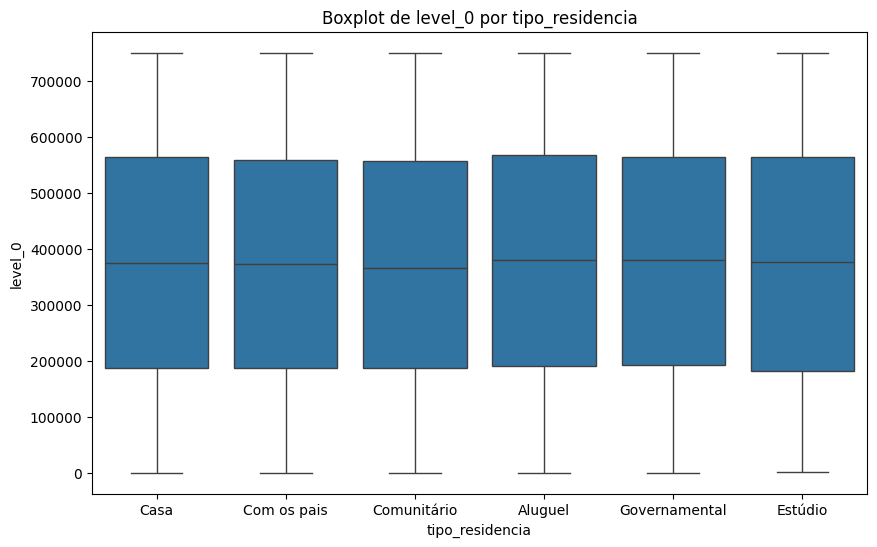


Violin Plot de level_0 por tipo_residencia:


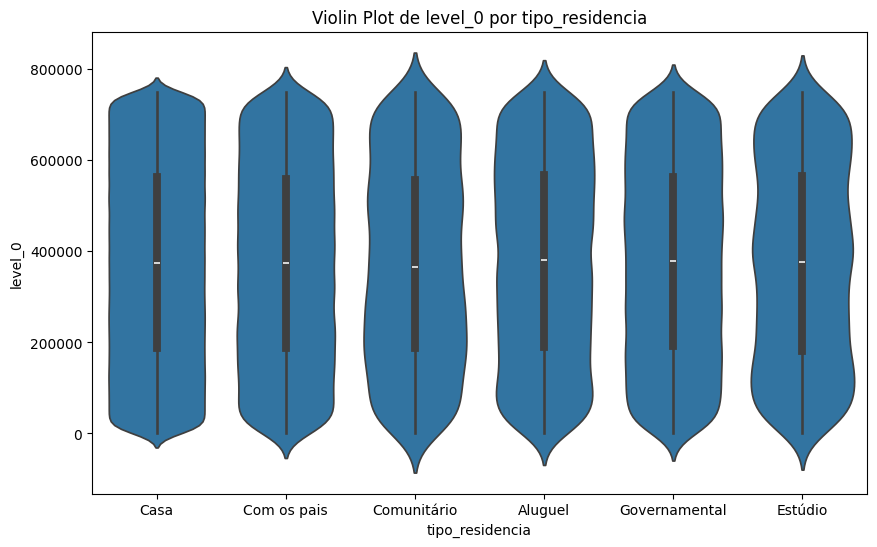


Boxplot de index por tipo_residencia:


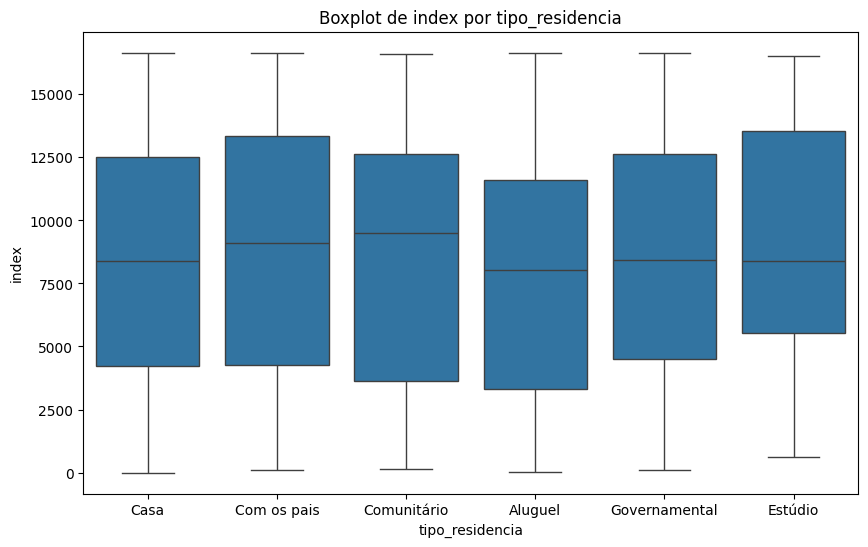


Violin Plot de index por tipo_residencia:


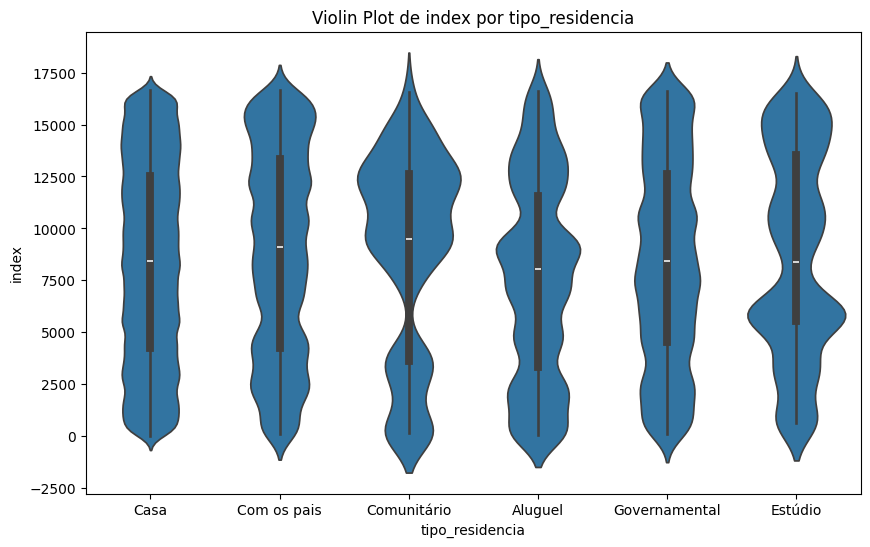


Boxplot de qtd_filhos por tipo_residencia:


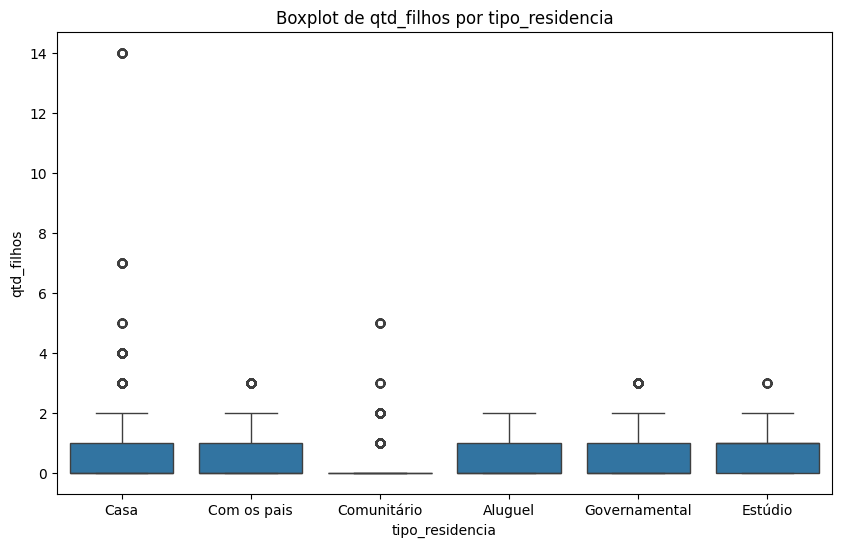


Violin Plot de qtd_filhos por tipo_residencia:


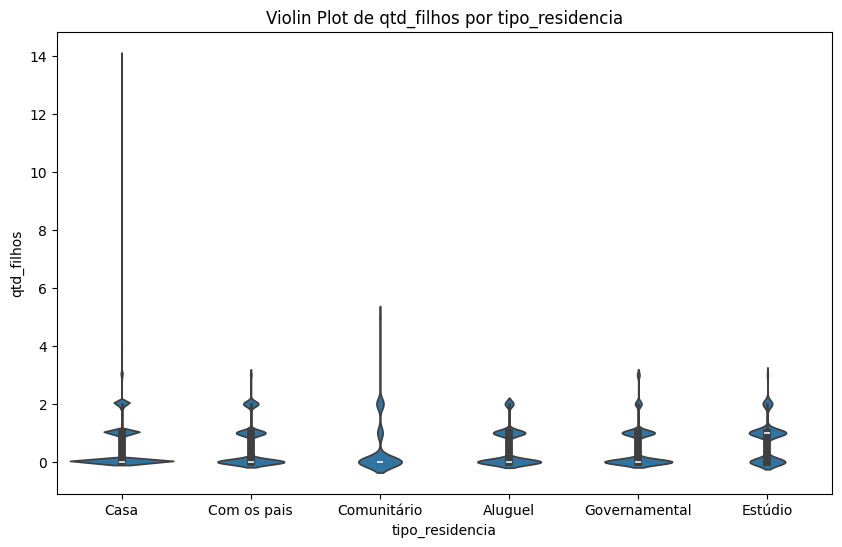


Boxplot de idade por tipo_residencia:


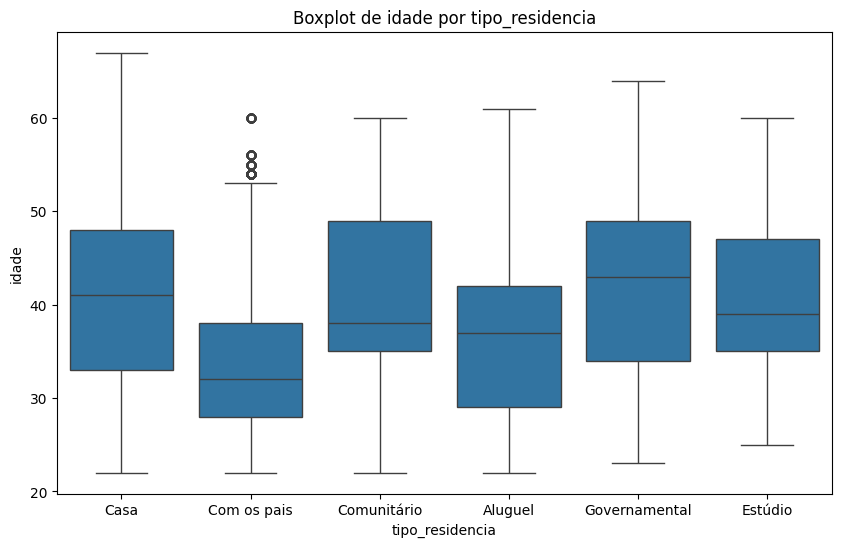


Violin Plot de idade por tipo_residencia:


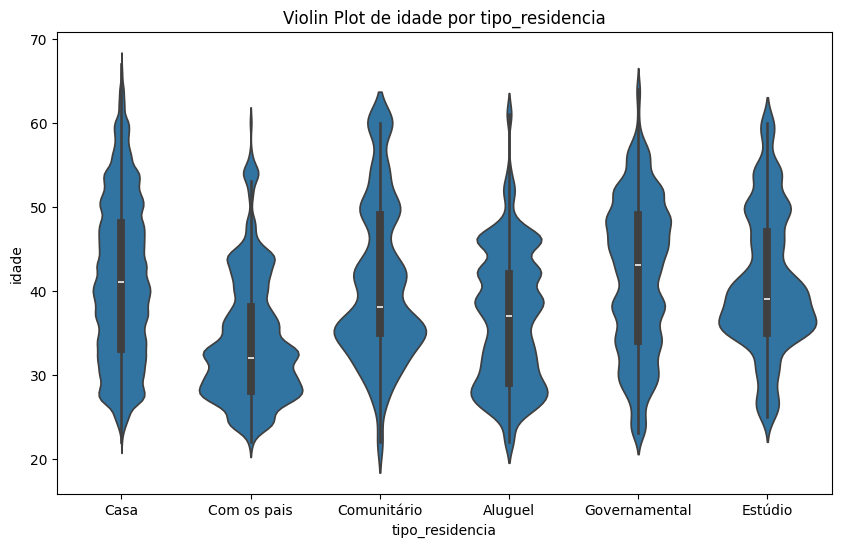


Boxplot de tempo_emprego por tipo_residencia:


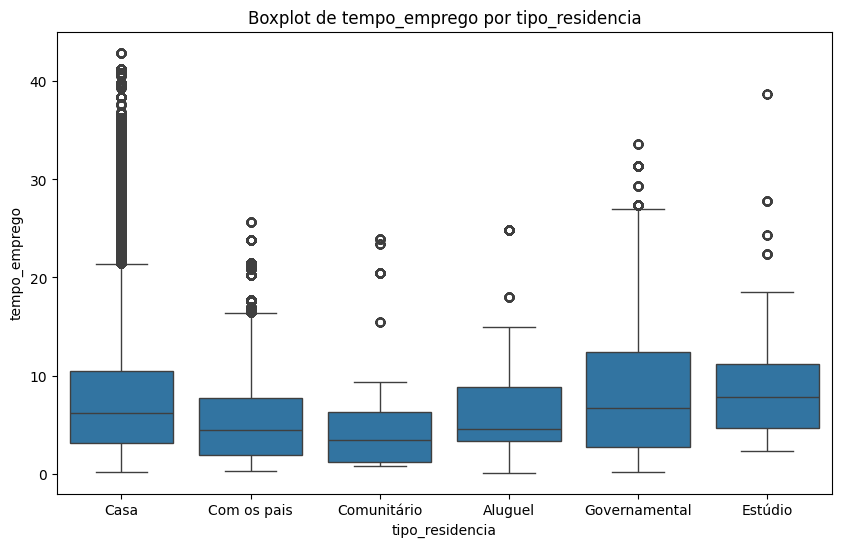


Violin Plot de tempo_emprego por tipo_residencia:


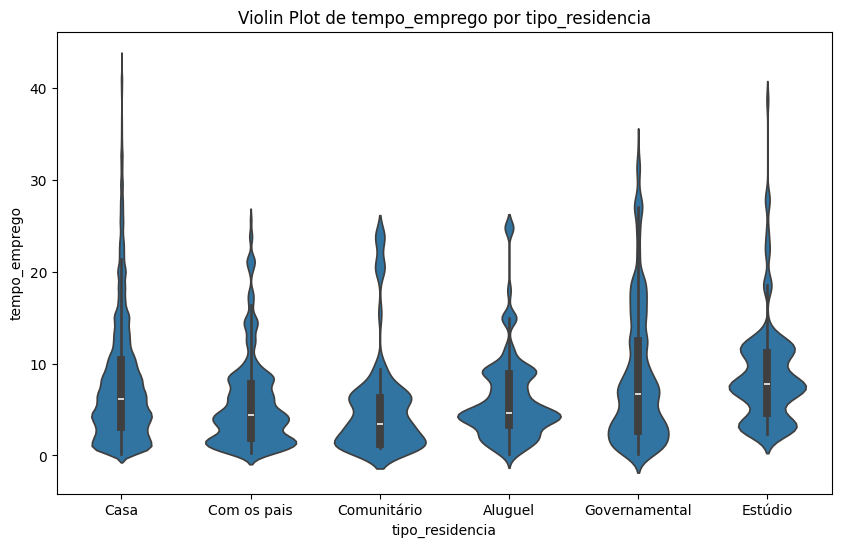


Boxplot de qt_pessoas_residencia por tipo_residencia:


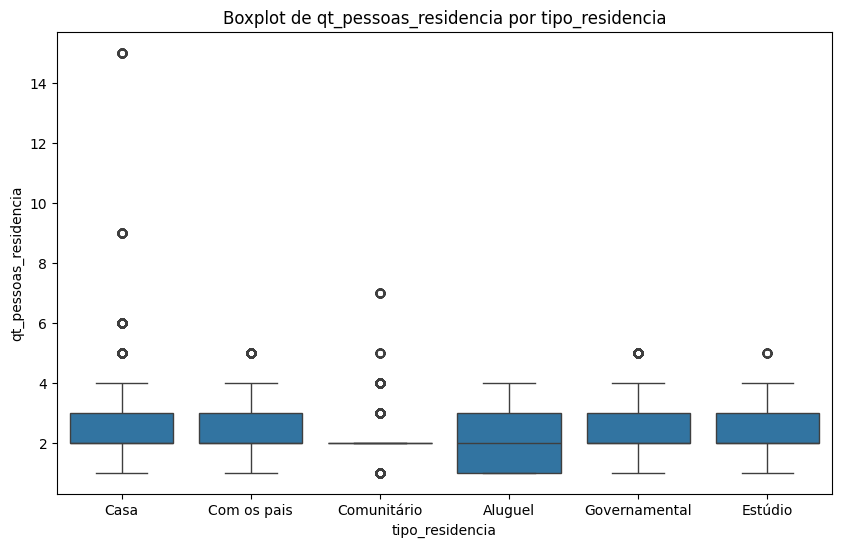


Violin Plot de qt_pessoas_residencia por tipo_residencia:


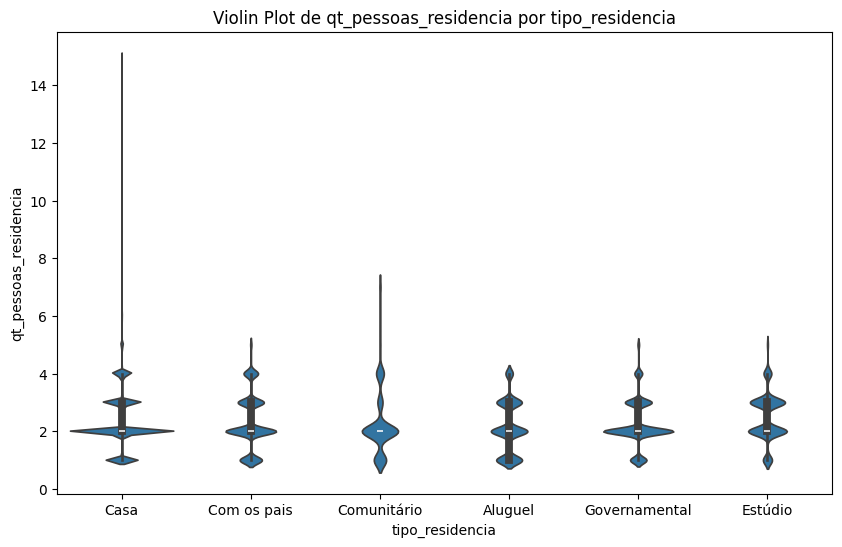


Boxplot de renda por tipo_residencia:


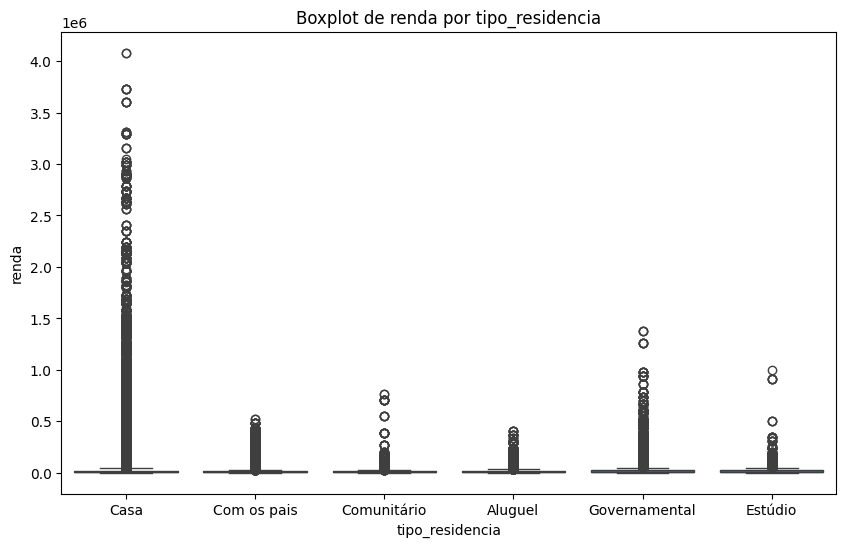


Violin Plot de renda por tipo_residencia:


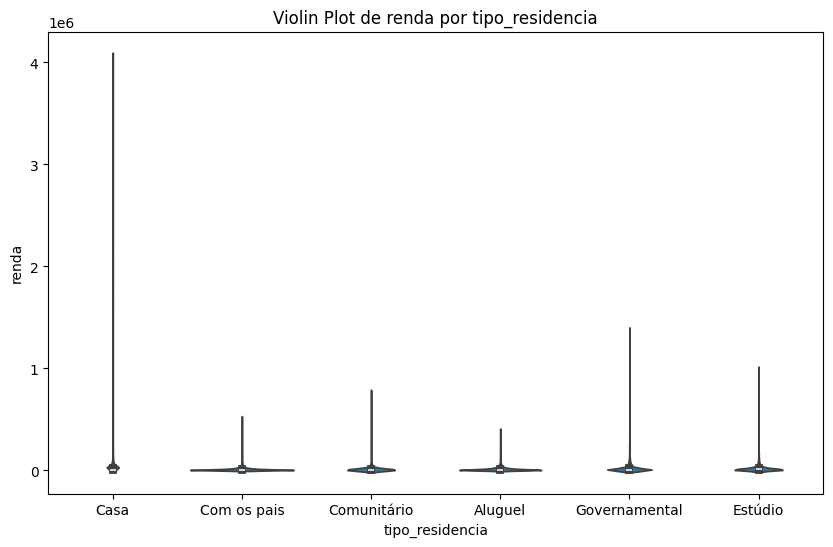

In [17]:
# Relação entre uma variável qualitativa e uma quantitativa (Boxplot e Violin Plot)
print("\nAnálise bivariada entre variáveis qualitativas e quantitativas:")
for col1 in qualitativas.columns:
    for col2 in quantitativas.columns:
        print(f"\nBoxplot de {col2} por {col1}:")
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=col1, y=col2, data=df)
        plt.title(f'Boxplot de {col2} por {col1}')
        plt.show()

        print(f"\nViolin Plot de {col2} por {col1}:")
        plt.figure(figsize=(10, 6))
        sns.violinplot(x=col1, y=col2, data=df)
        plt.title(f'Violin Plot de {col2} por {col1}')
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [18]:
df['mau'] = df.mau.astype('int64')

In [19]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [20]:
iv_sexo = IV(df.sexo, df.mau)
print(f'IV da variável SEXO: {iv_sexo:.1%}')

IV da variável SEXO: 0.2%


In [21]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

dtype  nmissing  valores_unicos       papel
level_0                         int64       0.0        624043.0  covariavel
data_ref               datetime64[ns]       0.0            15.0  covariavel
index                           int64       0.0         13857.0  covariavel
sexo                           object       0.0             2.0  covariavel
posse_de_veiculo               object       0.0             2.0  covariavel
posse_de_imovel                object       0.0             2.0  covariavel
qtd_filhos                      int64       0.0             8.0  covariavel
tipo_renda                     object       0.0             5.0  covariavel
educacao                       object       0.0             5.0  covariavel
estado_civil                   object       0.0             5.0  covariavel
tipo_residencia                object       0.0             6.0  covariavel
idade                           int64       0.0            46.0  covariavel
tempo_emprego                 float64       0.0          3004.0  covariavel
qt_pessoas_residencia         float64       0.0             9.0  covariavel
renda                         float64       0.0        119214.0  covariavel
mau                             int64       0.0             2.0    resposta
bom                               NaN       NaN             NaN    resposta

In [22]:
var='idade'
IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)

0.027295273312450293

In [23]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)


metadados

dtype  nmissing  valores_unicos       papel  \
level_0                         int64       0.0        624043.0  covariavel   
data_ref               datetime64[ns]       0.0            15.0  covariavel   
index                           int64       0.0         13857.0  covariavel   
sexo                           object       0.0             2.0  covariavel   
posse_de_veiculo               object       0.0             2.0  covariavel   
posse_de_imovel                object       0.0             2.0  covariavel   
qtd_filhos                      int64       0.0             8.0  covariavel   
tipo_renda                     object       0.0             5.0  covariavel   
educacao                       object       0.0             5.0  covariavel   
estado_civil                   object       0.0             5.0  covariavel   
tipo_residencia                object       0.0             6.0  covariavel   
idade                           int64       0.0            46.0  covariavel   
tempo_emprego                 float64       0.0          3004.0  covariavel   
qt_pessoas_residencia         float64       0.0             9.0  covariavel   
renda                         float64       0.0        119214.0  covariavel   
mau                             int64       0.0             2.0    resposta   
bom                               NaN       NaN             NaN    resposta   

                             IV  
level_0                0.342511  
data_ref               0.337036  
index                  0.002991  
sexo                   0.001766  
posse_de_veiculo       0.000030  
posse_de_imovel        0.011180  
qtd_filhos             0.000105  
tipo_renda             0.010465  
educacao               0.003511  
estado_civil           0.002194  
tipo_residencia        0.004111  
idade                  0.027295  
tempo_emprego          0.351920  
qt_pessoas_residencia  0.002184  
renda                  1.140500  
mau                         NaN  
bom                         NaN

In [24]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    ax[1] = biv.cont.plot.bar()
    return biv

0.003072636160639651

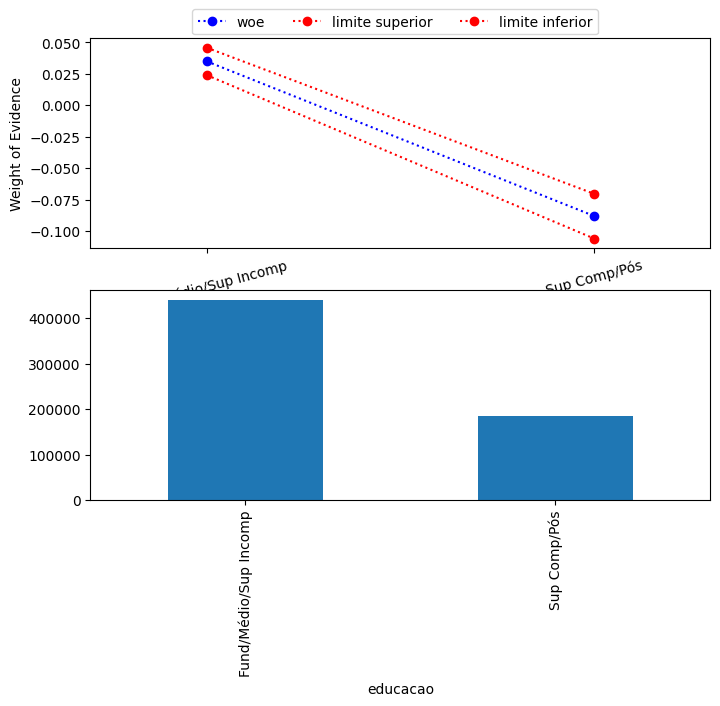

In [25]:
# Agrupando as classes: educacao

df2 = df.copy()
df2.educacao.replace({'Fundamental': 'Fund/Médio/Sup Incomp',
     'Médio': 'Fund/Médio/Sup Incomp',
     'Superior incompleto': 'Fund/Médio/Sup Incomp',
     'Superior completo': 'Sup Comp/Pós',
     'Pós graduação': 'Sup Comp/Pós'}, inplace=True)
biv_discreta('educacao', df2)
IV(df2.educacao, df2.mau)

0.010243834833227591

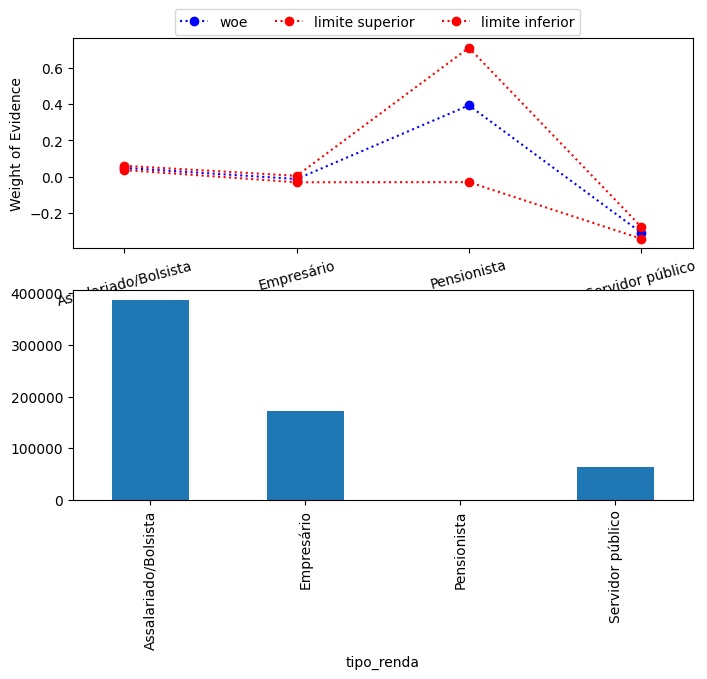

In [26]:
# Agrupando as classes: tipo_renda

df2.tipo_renda.replace(
    {'Assalariado': 'Assalariado/Bolsista',
     'Bolsista': 'Assalariado/Bolsista'}, inplace=True)

biv_discreta('tipo_renda', df2)
IV(df2.tipo_renda, df2.mau)

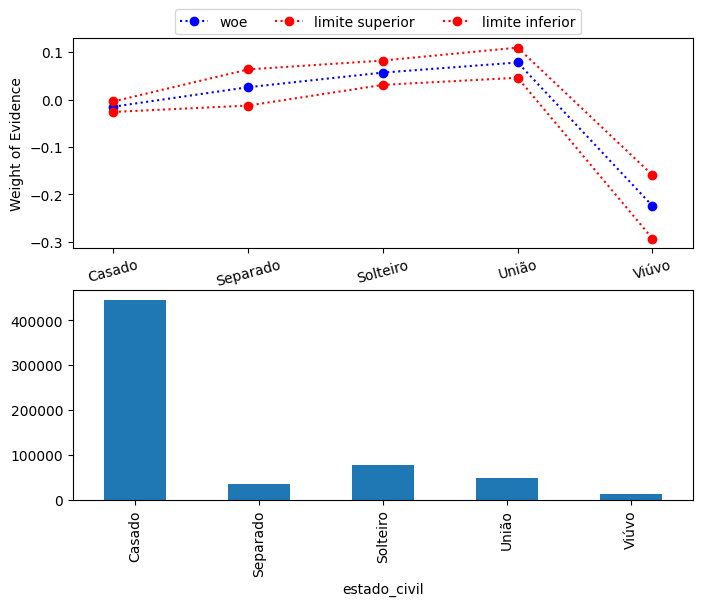

In [27]:
biv_discreta('estado_civil', df2);

qt_bom  qt_mau       mau            tipo_renda    cont  \
tipo_renda                                                                     
Assalariado/Bolsista  354873   31228  0.080880  Assalariado/Bolsista  386101   
Empresário            159508   13204  0.076451            Empresário  172712   
Pensionista              274      34  0.110390           Pensionista     308   
Servidor público       61151    3771  0.058085      Servidor público   64922   

                            ep   mau_sup   mau_inf     logit  logit_sup  \
tipo_renda                                                                
Assalariado/Bolsista  0.000439  0.081740  0.080020 -2.430445  -2.418932   
Empresário            0.000639  0.077704  0.075198 -2.491574  -2.473957   
Pensionista           0.017856  0.145526  0.075254 -2.086768  -1.770134   
Servidor público      0.000918  0.059884  0.056286 -2.786006  -2.753587   

                      logit_inf       woe   woe_sup   woe_inf  
tipo_renda                                                     
Assalariado/Bolsista  -2.442070  0.049200  0.060713  0.037574  
Empresário            -2.509458 -0.011930  0.005687 -0.029814  
Pensionista           -2.508656  0.392877  0.709510 -0.029011  
Servidor público      -2.819381 -0.306362 -0.273943 -0.339736

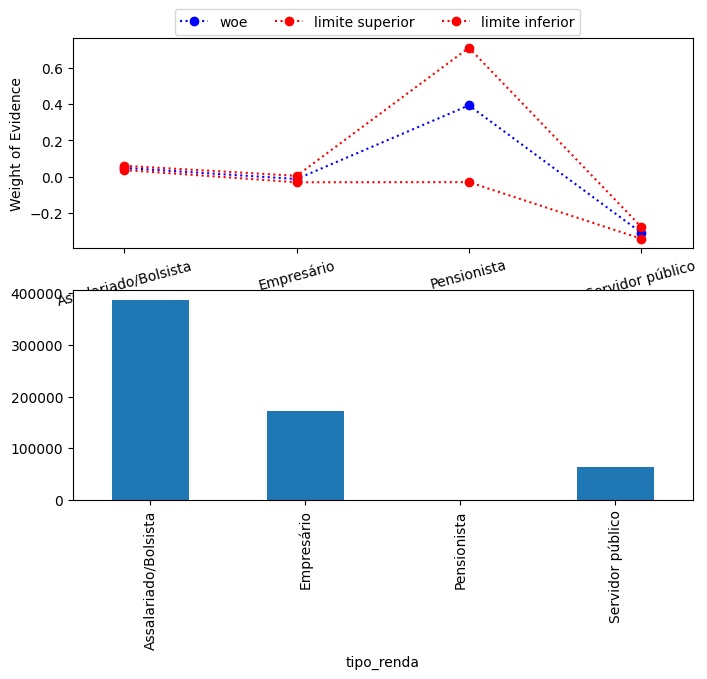

In [28]:
biv_discreta('tipo_renda', df2)

qt_bom  qt_mau       mau  qt_pessoas_residencia  \
qt_pessoas_residencia                                                    
1.0                     91244    7813  0.078874                    1.0   
2.0                    298834   23871  0.073972                    2.0   
3.0                    116197   10584  0.083483                    3.0   
4.0                     60702    5169  0.078472                    4.0   
5.0                      7593     689  0.083192                    5.0   
6.0                      1028      80  0.072202                    6.0   
7.0                        52       0  0.000000                    7.0   
9.0                        83      18  0.178218                    9.0   
15.0                       73      13  0.151163                   15.0   

                         cont        ep   mau_sup   mau_inf     logit  \
qt_pessoas_residencia                                                   
1.0                     99057  0.000856  0.080552  0.077195 -2.457748   
2.0                    322705  0.000461  0.074875  0.073069 -2.527224   
3.0                    126781  0.000777  0.085005  0.081960 -2.395944   
4.0                     65871  0.001048  0.080525  0.076418 -2.463297   
5.0                      8282  0.003035  0.089141  0.077244 -2.399741   
6.0                      1108  0.007776  0.087459  0.056946 -2.553344   
7.0                        52  0.000000  0.000000  0.000000      -inf   
9.0                       101  0.038080  0.253767  0.102669 -1.528469   
15.0                       86  0.038627  0.227963  0.074363 -1.725510   

                       logit_sup  logit_inf       woe   woe_sup   woe_inf  
qt_pessoas_residencia                                                      
1.0                    -2.434866  -2.481080  0.021896  0.044778 -0.001436  
2.0                    -2.514115  -2.540481 -0.047579 -0.034470 -0.060837  
3.0                    -2.376206  -2.416011  0.083701  0.103438  0.063634  
4.0                    -2.435233  -2.492042  0.016347  0.044412 -0.012398  
5.0                    -2.324166  -2.480399  0.079904  0.155478 -0.000755  
6.0                    -2.345067  -2.807026 -0.073699  0.134577 -0.327382  
7.0                         -inf       -inf      -inf      -inf      -inf  
9.0                    -1.078622  -2.167916  0.951176  1.401022  0.311728  
15.0                   -1.219851  -2.521524  0.754134  1.259793 -0.041880

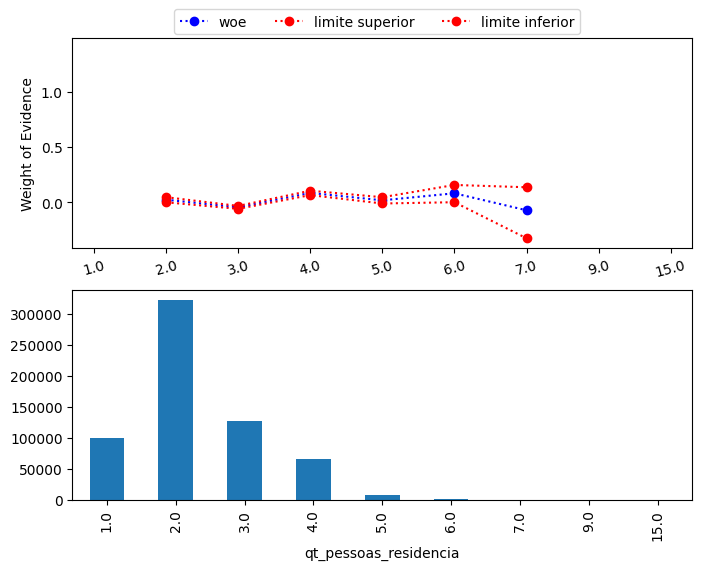

In [29]:
biv_discreta('qt_pessoas_residencia', df2)

In [30]:
# Zeros Estruturais

In [31]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'renda + tempo_emprego + level_0 + data_ref + idade + posse_de_imovel + tipo_renda + tipo_residencia + educacao + index + estado_civil + qt_pessoas_residencia + sexo + qtd_filhos + posse_de_veiculo + mau + bom'

In [32]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda +
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
'''

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               624043
Model:                            GLM   Df Residuals:                   624022
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5065e+05
Date:                Mon, 02 Sep 2024   Deviance:                   3.0111e+05
Time:                        15:59:57   Pearson chi2:                 4.12e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.05958
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.1272      0.044    -25.481      0.000      -1.214      -1.041
sexo[T.M]                           -0.1357      0.011    -12.300      0.000      -0.157      -0.114
posse_de_veiculo[T.S]                0.0222      0.011      2.082      0.037       0.001       0.043
posse_de_imovel[T.S]                -0.1022      0.010     -9.924      0.000      -0.122      -0.082
tipo_renda[T.Empresário]            -0.0530      0.011     -4.725      0.000      -0.075      -0.031
tipo_renda[T.Pensionista]            0.0648      0.186      0.349      0.727      -0.299       0.428
tipo_renda[T.Servidor público]      -0.0296      0.019     -1.593      0.111      -0.066       0.007
educacao[T.Sup Comp/Pós]            -0.0662      0.011     -5.892      0.000      -0.088      -0.044
estado_civil[T.Separado]             0.0188      0.021      0.889      0.374      -0.023       0.060
estado_civil[T.Solteiro]             0.0092      0.015      0.607      0.544      -0.021       0.039
estado_civil[T.União]                0.0154      0.018      0.865      0.387      -0.019       0.050
estado_civil[T.Viúvo]               -0.1282      0.036     -3.549      0.000      -0.199      -0.057
tipo_residencia[T.Casa]             -0.0620      0.037     -1.693      0.090      -0.134       0.010
tipo_residencia[T.Com os pais]      -0.0566      0.041     -1.382      0.167      -0.137       0.024
tipo_residencia[T.Comunitário]      -0.1689      0.074     -2.290      0.022      -0.313      -0.024
tipo_residencia[T.Estúdio]          -0.0375      0.070     -0.535      0.593      -0.175       0.100
tipo_residencia[T.Governamental]    -0.0544      0.045     -1.201      0.230      -0.143       0.034
qtd_filhos                          -0.0005      0.007     -0.080      0.936      -0.013       0.012
idade                               -0.0002      0.001     -0.347      0.729      -0.001       0.001
tempo_emprego                       -0.0290      0.001    -20.511      0.000      -0.032      -0.026
renda                               -0.0001   1.14e-06   -107.724      0.000      -0.000      -0.000
====================================================================================================
"""

In [33]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + np.log(renda)
'''

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               624043
Model:                            GLM   Df Residuals:                   624037
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4359e+05
Date:                Mon, 02 Sep 2024   Deviance:                   2.8719e+05
Time:                        16:00:07   Pearson chi2:                 6.24e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.08060
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.9560      0.042    140.742      0.000       5.873       6.039
sexo[T.M]                   -0.0075      0.011     -0.710      0.478      -0.028       0.013
posse_de_imovel[T.S]        -0.0306      0.010     -2.956      0.003      -0.051      -0.010
educacao[T.Sup Comp/Pós]    -0.0059      0.011     -0.521      0.602      -0.028       0.016
tempo_emprego               -0.0021      0.001     -1.513      0.130      -0.005       0.001
np.log(renda)               -0.9908      0.006   -175.911      0.000      -1.002      -0.980
============================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [34]:
df2['score'] = rl.predict(df2)
df2.isna().sum()
df2 = df2.dropna()

# Acurácia
acc = metrics.accuracy_score(df2.mau, df2.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df2.mau, df2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df2.loc[df2.mau == 1, 'score'], df2.loc[df2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 66.4% 
AUC: 78.9% 
GINI: 57.8%
KS: 43.1%


In [35]:
#treino e teste
df.set_index('data_ref', inplace=True)

df_train = df['2016-01-01':'2016-03-01']
df_test = df['2015-12-01':]

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

df_train['mes'] = df_train['data_ref'].dt.month

In [36]:
#Out of time
df_test['tempo_emprego'].fillna(value=df_test['tempo_emprego'].mean(), inplace=True)

In [37]:
df_test.educacao.replace(
    {'Fundamental': 'Fund/Médio/Sup Incomp',
     'Médio': 'Fund/Médio/Sup Incomp',
     'Superior incompleto': 'Fund/Médio/Sup Incomp',
     'Superior completo': 'Sup Comp/Pós',
     'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

In [38]:
df_test['score'] = rl.predict(df_test)

# Acurácia
acc = metrics.accuracy_score(df_test.mau, df_test.score > .068)

# AUC
fpr, tpr, thresholds = metrics.roc_curve(df_test.mau, df_test.score)
auc = metrics.auc(fpr, tpr)

# Gini
gini = 2*auc - 1
ks = ks_2samp(df_test.loc[df_test.mau == 1, 'score'],
              df_test.loc[df_test.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 44.7% 
AUC: 75.5% 
GINI: 50.9%
KS: 37.3%


### Análise Comparativa:

*Acurácia*:
Na base de desenvolvimento, a acurácia é significativamente maior (66,4%) comparada à base OOT (42,5%). Isso sugere que o modelo pode estar superajustado aos dados de treinamento e não generaliza bem para novos dados.

*AUC*:
A AUC diminuiu de 78,9% na base de desenvolvimento para 74,5% na base OOT. Embora a queda não seja tão drástica, ainda indica uma perda de capacidade do modelo em discriminar entre as classes na base OOT.

*GINI*:
O índice GINI caiu de 57,8% na base de desenvolvimento para 48,9% na base OOT. Isso reflete uma redução na capacidade de separação das classes, o que é consistente com a diminuição da AUC.

*KS*:
O valor do KS reduziu de 43,1% na base de desenvolvimento para 35,5% na base OOT. Uma diminuição no KS também indica uma menor capacidade do modelo em discriminar corretamente entre as classes na base OOT.

### Conclusão:
Os resultados mostram uma diminuição geral do desempenho do modelo ao passar da base de desenvolvimento para a base OOT. Essa queda em métricas como Acurácia, AUC, GINI e KS sugere que o modelo pode estar superajustado aos dados de desenvolvimento, o que resulta em uma menor generalização e capacidade discriminante ao ser aplicado em novos dados temporais. Pode ser necessário revisar o modelo, talvez simplificando-o, aplicando técnicas de regularização, ou utilizando um conjunto de dados mais diversificado durante o treinamento para melhorar a robustez do modelo em diferentes períodos.

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

In [39]:
!pip install pycaret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [1]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from pycaret.regression import create_model
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [2]:
from pycaret.classification import *

## Pré processamento

### Substituição de nulos (nans)


In [7]:
df.isnull().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [8]:
df.drop(df[df['tempo_emprego'] == 0].index)

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0      2015-01-01   5733    F                N               N           0   
1      2015-01-01    727    F                S               S           0   
2      2015-01-01   6374    F                N               N           2   
3      2015-01-01   9566    F                N               N           0   
4      2015-01-01   9502    F                S               N           0   
...           ...    ...  ...              ...             ...         ...   
749995 2016-03-01  13689    M                N               S           0   
749996 2016-03-01   7000    F                N               S           0   
749997 2016-03-01  14023    M                S               N           2   
749998 2016-03-01   2396    F                N               S           0   
749999 2016-03-01  14026    M                S               N           2   

         tipo_renda             educacao estado_civil tipo_residencia  idade  \
0        Empresário                Médio     Solteiro            Casa     43   
1       Assalariado                Médio       Casado            Casa     35   
2       Assalariado                Médio       Casado            Casa     31   
3       Assalariado                Médio       Casado            Casa     54   
4       Assalariado  Superior incompleto     Solteiro            Casa     31   
...             ...                  ...          ...             ...    ...   
749995   Empresário    Superior completo       Casado            Casa     48   
749996  Pensionista                Médio     Solteiro            Casa     65   
749997  Assalariado                Médio       Casado            Casa     43   
749998  Assalariado                Médio        Viúvo            Casa     56   
749999  Assalariado                Médio       Casado            Casa     43   

        tempo_emprego  qt_pessoas_residencia     renda    mau  
0            6.873973                    1.0   2515.39  False  
1            4.526027                    2.0   3180.19  False  
2            0.243836                    4.0   1582.29  False  
3           12.772603                    2.0  13721.17  False  
4            8.432877                    1.0   2891.08  False  
...               ...                    ...       ...    ...  
749995       3.038356                    2.0   2109.99  False  
749996            NaN                    1.0   1389.39  False  
749997      10.375342                    4.0    649.06   True  
749998      13.780822                    1.0   4216.72   True  
749999      10.375342                    4.0   4460.69  False  

[750000 rows x 15 columns]

In [9]:
df['tempo_emprego_mean'] = df['tempo_emprego'].fillna(value=df['tempo_emprego'].mean())

In [10]:
df.drop(['data_ref','index'], axis=1, inplace=True)

In [11]:
df.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
tempo_emprego_mean       float64
dtype: object

In [12]:
df.idade = df.idade.astype(float)

In [13]:
df.mau.value_counts(normalize=True)


mau
False    0.921809
True     0.078191
Name: proportion, dtype: float64

In [14]:
exp = setup(data = df, target = 'mau', experiment_name='credit_1',
                  normalize=True, normalize_method='zscore',
                  transformation=True, transformation_method = 'quantile',
                  fix_imbalance=True)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   750000 non-null  object 
 1   posse_de_veiculo       750000 non-null  object 
 2   posse_de_imovel        750000 non-null  object 
 3   qtd_filhos             750000 non-null  int64  
 4   tipo_renda             750000 non-null  object 
 5   educacao               750000 non-null  object 
 6   estado_civil           750000 non-null  object 
 7   tipo_residencia        750000 non-null  object 
 8   idade                  750000 non-null  float64
 9   tempo_emprego          624043 non-null  float64
 10  qt_pessoas_residencia  750000 non-null  float64
 11  renda                  750000 non-null  float64
 12  mau                    750000 non-null  bool   
 13  tempo_emprego_mean     750000 non-null  float64
dtypes: bool(1), float64(5), int64(1), ob

In [16]:
df.dropna(inplace=True)

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [17]:
def outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_sem_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_sem_outliers

In [18]:
for column in df.select_dtypes(include=[np.number]).columns:
    df = outliers(df, column)
df.head()

sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0    F                N               N           0   Empresário   
1    F                S               S           0  Assalariado   
2    F                N               N           2  Assalariado   
3    F                N               N           0  Assalariado   
4    F                S               N           0  Assalariado   

              educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0                Médio     Solteiro            Casa   43.0       6.873973   
1                Médio       Casado            Casa   35.0       4.526027   
2                Médio       Casado            Casa   31.0       0.243836   
3                Médio       Casado            Casa   54.0      12.772603   
4  Superior incompleto     Solteiro            Casa   31.0       8.432877   

   qt_pessoas_residencia     renda    mau  tempo_emprego_mean  
0                    1.0   2515.39  False            6.873973  
1                    2.0   3180.19  False            4.526027  
2                    4.0   1582.29  False            0.243836  
3                    2.0  13721.17  False           12.772603  
4                    1.0   2891.08  False            8.432877

### Seleção de variáveis


In [19]:
df.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau',
       'tempo_emprego_mean'],
      dtype='object')

In [20]:
df['mau'] = df.mau.astype('int64')

In [21]:
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
            'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia',
            'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda',
            'tempo_emprego_mean']

In [22]:

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()



In [23]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

dtype  nmissing  valores_unicos       papel
sexo                    object       0.0             2.0  covariavel
posse_de_veiculo        object       0.0             2.0  covariavel
posse_de_imovel         object       0.0             2.0  covariavel
qtd_filhos               int64       0.0             3.0  covariavel
tipo_renda              object       0.0             5.0  covariavel
educacao                object       0.0             5.0  covariavel
estado_civil            object       0.0             5.0  covariavel
tipo_residencia         object       0.0             6.0  covariavel
idade                  float64       0.0            45.0  covariavel
tempo_emprego          float64       0.0          2540.0  covariavel
qt_pessoas_residencia  float64       0.0             4.0  covariavel
renda                  float64       0.0         97930.0  covariavel
mau                      int64       0.0             2.0    resposta
tempo_emprego_mean     float64       0.0          2540.0  covariavel
bom                        NaN       NaN             NaN    resposta

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [24]:
X = df.drop('mau', axis=1)
y = df['mau']

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])


pca_df['mau'] = y

pca_df.head()

PC1       PC2       PC3       PC4       PC5  mau
0  1.315478 -2.279011  0.492716 -0.010196 -0.302750  0.0
1  0.105514 -0.714449 -1.108952 -0.079859 -0.275726  0.0
2 -2.454704  0.540215 -2.339091  0.659703  1.655519  0.0
3  3.078294  0.540078  0.196987  1.048163  0.412377  0.0
4  0.092055 -1.028811  2.111953 -0.827338 -1.912206  0.0

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [25]:
df_dummies = pd.get_dummies(df, columns=[
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
])

df_dummies

qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia     renda  \
0                0   43.0       6.873973                    1.0   2515.39   
1                0   35.0       4.526027                    2.0   3180.19   
2                2   31.0       0.243836                    4.0   1582.29   
3                0   54.0      12.772603                    2.0  13721.17   
4                0   31.0       8.432877                    1.0   2891.08   
...            ...    ...            ...                    ...       ...   
749993           0   51.0      13.298630                    2.0  15315.94   
749995           0   48.0       3.038356                    2.0   2109.99   
749997           2   43.0      10.375342                    4.0    649.06   
749998           0   56.0      13.780822                    1.0   4216.72   
749999           2   43.0      10.375342                    4.0   4460.69   

        mau  tempo_emprego_mean  sexo_F  sexo_M  posse_de_veiculo_N  ...  \
0         0            6.873973    True   False                True  ...   
1         0            4.526027    True   False               False  ...   
2         0            0.243836    True   False                True  ...   
3         0           12.772603    True   False                True  ...   
4         0            8.432877    True   False               False  ...   
...     ...                 ...     ...     ...                 ...  ...   
749993    0           13.298630    True   False                True  ...   
749995    0            3.038356   False    True                True  ...   
749997    1           10.375342   False    True               False  ...   
749998    1           13.780822    True   False                True  ...   
749999    0           10.375342   False    True               False  ...   

        estado_civil_Separado  estado_civil_Solteiro  estado_civil_União  \
0                       False                   True               False   
1                       False                  False               False   
2                       False                  False               False   
3                       False                  False               False   
4                       False                   True               False   
...                       ...                    ...                 ...   
749993                  False                  False               False   
749995                  False                  False               False   
749997                  False                  False               False   
749998                  False                  False               False   
749999                  False                  False               False   

        estado_civil_Viúvo  tipo_residencia_Aluguel  tipo_residencia_Casa  \
0                    False                    False                  True   
1                    False                    False                  True   
2                    False                    False                  True   
3                    False                    False                  True   
4                    False                    False                  True   
...                    ...                      ...                   ...   
749993               False                    False                  True   
749995               False                    False                  True   
749997               False                    False                  True   
749998                True                    False                  True   
749999               False                    False                  True   

        tipo_residencia_Com os pais  tipo_residencia_Comunitário  \
0                             False                        False   
1                             False                        False   
2                             False                        False   
3                             False                        F

### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [26]:
X_digits, y_digits = load_digits(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.3, random_state=10)

# Define a PCA to Linear dimensionality reduction
pca = PCA(n_components=20)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=200)

In [27]:
X_digits.head()

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0        0.0        0.0        5.0       13.0        9.0        1.0   
1        0.0        0.0        0.0       12.0       13.0        5.0   
2        0.0        0.0        0.0        4.0       15.0       12.0   
3        0.0        0.0        7.0       15.0       13.0        1.0   
4        0.0        0.0        0.0        1.0       11.0        0.0   

   pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_6  pixel_6_7  \
0        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1        0.0        0.0        0.0        0.0  ...        0.0        0.0   
2        0.0        0.0        0.0        0.0  ...        5.0        0.0   
3        0.0        0.0        0.0        8.0  ...        9.0        0.0   
4        0.0        0.0        0.0        0.0  ...        0.0        0.0   

   pixel_7_0  pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  \
0        0.0        0.0        6.0       13.0       10.0        0.0   
1        0.0        0.0        0.0       11.0       16.0       10.0   
2        0.0        0.0        0.0        3.0       11.0       16.0   
3        0.0        0.0        7.0       13.0       13.0        9.0   
4        0.0        0.0        0.0        2.0       16.0        4.0   

   pixel_7_6  pixel_7_7  
0        0.0        0.0  
1        0.0        0.0  
2        9.0        0.0  
3        0.0        0.0  
4        0.0        0.0  

[5 rows x 64 columns]

In [28]:
X_digits.shape

(1797, 64)

In [29]:
# Dataset de treino
# "Fitando" e aplicando Z score nos dados de treino
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# "Fitando" e aplicando o pca nos dados de treino
pca.fit(X_train)
X_train = pca.transform(X_train)

# "Fitando" e predizendo uma regressão logística nos dados de treino
logistic.fit(X_train, y_train)
logistic.predict(X_train)

array([0, 0, 0, ..., 2, 1, 2])

In [30]:
# Dataset de teste
# Aplicando nos dados de teste o Z score "fitado" nos dados de treino
X_test = scaler.transform(X_test)

# Aplicando nos dados de teste o PCA "fitado" nos dados de treino
X_test = pca.transform(X_test)

# Predizendo nos dados de teste o modelo "fitado" nos dados de treino
logistic.predict(X_test)

array([5, 2, 5, 4, 8, 3, 4, 3, 3, 0, 8, 7, 0, 1, 8, 6, 9, 7, 9, 7, 1, 6,
       6, 7, 8, 8, 5, 8, 9, 9, 3, 3, 7, 3, 4, 1, 9, 2, 5, 4, 2, 1, 0, 1,
       2, 9, 6, 1, 9, 4, 4, 5, 8, 4, 8, 5, 9, 7, 8, 0, 4, 5, 8, 4, 7, 9,
       0, 7, 1, 3, 9, 3, 3, 8, 0, 7, 3, 6, 5, 2, 0, 8, 8, 0, 1, 2, 2, 8,
       8, 8, 2, 6, 3, 4, 7, 9, 8, 2, 9, 2, 5, 0, 8, 0, 4, 8, 8, 0, 6, 7,
       3, 3, 9, 1, 2, 4, 6, 0, 8, 8, 1, 1, 7, 3, 9, 5, 2, 3, 3, 9, 7, 6,
       2, 5, 4, 3, 8, 7, 6, 7, 2, 7, 4, 9, 5, 1, 9, 8, 6, 1, 8, 1, 4, 0,
       9, 9, 1, 2, 3, 5, 0, 3, 4, 1, 5, 4, 9, 3, 5, 6, 4, 0, 8, 6, 7, 0,
       9, 9, 4, 7, 5, 5, 2, 0, 6, 7, 5, 3, 9, 7, 1, 3, 2, 8, 3, 3, 1, 7,
       1, 1, 1, 7, 1, 6, 7, 6, 9, 5, 2, 3, 5, 2, 9, 5, 4, 8, 2, 9, 1, 5,
       4, 2, 3, 9, 0, 2, 0, 2, 1, 0, 5, 0, 6, 4, 2, 1, 9, 0, 9, 0, 6, 9,
       4, 4, 9, 7, 5, 6, 1, 5, 7, 0, 8, 6, 2, 5, 1, 2, 3, 8, 4, 4, 3, 5,
       7, 9, 7, 2, 0, 2, 0, 9, 2, 8, 6, 3, 1, 0, 6, 6, 6, 7, 1, 6, 1, 7,
       6, 0, 6, 3, 7, 4, 6, 2, 2, 0, 8, 4, 7, 3, 3,

In [31]:
# Usando pipeline
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.3, random_state=10)

# Define a PCA to Linear dimensionality reduction
pca_pipe = PCA(n_components=15)

# Define a Standard Scaler to normalize inputs
scaler_pipe = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic_pipe = LogisticRegression(max_iter=200)

pipe = Pipeline(steps=[("scaler", scaler_pipe),
                       ("pca", pca_pipe),
                       ("logistic", logistic_pipe)])

pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=15, n_oversamples=10,
     power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
     tol=0.0, whiten=False),
 'logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=200,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [32]:

# Dados de treino
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     n_oversamples=10, power_iteration_normalizer='auto',
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=200,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [33]:
pipe.predict(X_train)

array([0, 0, 0, ..., 1, 8, 2])

In [34]:

# Dados de teste
pipe.predict(X_test)

array([5, 2, 5, 4, 8, 1, 4, 3, 3, 0, 8, 7, 0, 1, 8, 6, 9, 7, 9, 7, 1, 6,
       6, 7, 8, 8, 5, 8, 9, 9, 3, 3, 7, 3, 4, 1, 9, 2, 5, 4, 2, 1, 0, 1,
       2, 3, 6, 1, 9, 4, 4, 9, 8, 4, 8, 5, 9, 7, 1, 0, 4, 5, 8, 4, 7, 9,
       0, 7, 1, 3, 3, 3, 3, 8, 0, 7, 3, 6, 5, 2, 0, 8, 8, 0, 1, 2, 2, 8,
       8, 8, 2, 6, 3, 4, 7, 9, 8, 2, 9, 2, 5, 0, 8, 0, 4, 8, 8, 0, 6, 7,
       3, 3, 9, 1, 2, 4, 6, 0, 8, 8, 1, 1, 7, 8, 9, 5, 2, 3, 3, 9, 7, 6,
       2, 5, 4, 3, 8, 4, 6, 7, 2, 7, 4, 9, 5, 1, 9, 8, 6, 1, 8, 1, 4, 0,
       9, 9, 1, 2, 3, 5, 0, 3, 4, 1, 5, 4, 9, 3, 5, 6, 4, 0, 8, 6, 7, 0,
       9, 9, 4, 7, 9, 5, 2, 0, 6, 7, 5, 3, 9, 7, 1, 3, 2, 8, 8, 3, 1, 7,
       1, 1, 1, 7, 1, 6, 7, 6, 9, 5, 2, 3, 5, 2, 9, 5, 4, 8, 2, 0, 1, 5,
       4, 2, 3, 9, 0, 2, 0, 2, 1, 0, 5, 0, 6, 4, 2, 1, 9, 0, 9, 0, 6, 9,
       4, 4, 9, 7, 5, 6, 1, 8, 7, 0, 8, 6, 2, 5, 1, 2, 3, 8, 4, 4, 3, 5,
       7, 9, 7, 2, 0, 2, 0, 9, 2, 8, 6, 3, 1, 0, 6, 6, 6, 7, 1, 6, 1, 7,
       6, 0, 6, 3, 7, 4, 6, 2, 2, 0, 8, 4, 7, 3, 3,

In [35]:
# Analisando o objeto
pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=15, n_oversamples=10,
     power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
     tol=0.0, whiten=False),
 'logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=200,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [36]:
pipe.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('pca',
  PCA(copy=True, iterated_power='auto', n_components=15, n_oversamples=10,
      power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
      tol=0.0, whiten=False)),
 ('logistic',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=200,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False))]

In [37]:
pipe[0]

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
pipe[1]

PCA(copy=True, iterated_power='auto', n_components=15, n_oversamples=10,
    power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
    tol=0.0, whiten=False)

In [39]:
pipe[2]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
pipe[1].transform(X_train)

array([[  0.87100457, -12.61629156, -18.95615214, ...,   5.20161467,
         15.983475  ,   3.92642534],
       [  7.39000291,  -7.84633549, -16.49072643, ...,   8.53058897,
         19.99451324,   2.9867593 ],
       [  8.28997836, -10.02872134, -14.17165169, ...,   9.09284969,
         27.36016028,   4.40995716],
       ...,
       [-12.90637407, -12.77050906,  16.69164996, ...,   1.61974248,
         10.36556699,   6.68796238],
       [-12.20195857,  -2.58798186,   7.00729973, ...,   8.6854332 ,
          9.9688667 ,   2.99336998],
       [-11.21462949,   2.61274799,   2.68270039, ...,   4.03823806,
         18.79183163,  -4.4833314 ]])

In [41]:

pca_pipe.transform(X_train)

array([[  0.87100457, -12.61629156, -18.95615214, ...,   5.20161467,
         15.983475  ,   3.92642534],
       [  7.39000291,  -7.84633549, -16.49072643, ...,   8.53058897,
         19.99451324,   2.9867593 ],
       [  8.28997836, -10.02872134, -14.17165169, ...,   9.09284969,
         27.36016028,   4.40995716],
       ...,
       [-12.90637407, -12.77050906,  16.69164996, ...,   1.61974248,
         10.36556699,   6.68796238],
       [-12.20195857,  -2.58798186,   7.00729973, ...,   8.6854332 ,
          9.9688667 ,   2.99336998],
       [-11.21462949,   2.61274799,   2.68270039, ...,   4.03823806,
         18.79183163,  -4.4833314 ]])

In [42]:
# Criando o dummy da variável 'posse_de_veiculo'
df.columns = df.columns.str.strip()
categorical_features = ['posse_de_veiculo']

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'), categorical_features)],remainder='passthrough')
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


X = df.drop(columns=['mau'])
y = df['mau']


X_transformed = pipeline.fit_transform(X)
X_transformed_df = pd.DataFrame(X_transformed, columns=pipeline.named_steps['preprocessor'].get_feature_names_out())


print(X_transformed_df.head())


  cat__posse_de_veiculo_S remainder__sexo remainder__posse_de_imovel  \
0                     0.0               F                          N   
1                     1.0               F                          S   
2                     0.0               F                          N   
3                     0.0               F                          N   
4                     1.0               F                          N   

  remainder__qtd_filhos remainder__tipo_renda  remainder__educacao  \
0                     0            Empresário                Médio   
1                     0           Assalariado                Médio   
2                     2           Assalariado                Médio   
3                     0           Assalariado                Médio   
4                     0           Assalariado  Superior incompleto   

  remainder__estado_civil remainder__tipo_residencia remainder__idade  \
0                Solteiro                       Casa             43.0   


# b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [43]:
from pycaret.classification import *

In [44]:
import pandas as pd
from pycaret.classification import *
df = pd.read_feather('credit_scoring (2).ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

In [45]:
dataset = df.sample(50000)

In [46]:
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [47]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [48]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [49]:
models()

Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
xgboost         Extreme Gradient Boosting   
lightgbm  Light Gradient Boosting Machine   
dummy                    Dummy Classifier   

                                                  Reference  Turbo  
ID                                                                  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
knn       sklearn.neighbors._classification.KNeighborsCl...   True  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
svm       sklearn.linear_model._stochastic_gradient.SGDC...   True  
rbfsvm                             sklearn.svm._classes.SVC  False  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
qda       sklearn.discriminant_analysis.QuadraticDiscrim...   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lda       sklearn.discriminant_analysis.LinearDiscrimina...   True  
et            sklearn.ensemble._forest.ExtraTreesClassifier   True  
xgboost                       xgboost.sklearn.XGBClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True  
dummy                         sklearn.dummy.DummyClassifier   True

In [50]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [51]:
# Forçando a variável qnt de filhos como numérica
data.qtd_filhos = data.qtd_filhos.astype(float)

In [52]:
data.mau.value_counts(normalize=True)

mau
False    0.921937
True     0.078063
Name: proportion, dtype: float64

In [53]:
exp = setup(data = data, target = 'mau', experiment_name='credit_1',
                  normalize=True, normalize_method='zscore',
                  transformation=True, transformation_method = 'quantile',
                  fix_imbalance=True)

In [54]:
best_model = compare_models(fold=5)

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [55]:
best_model = compare_models(fold=10, sort='AUC')

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [56]:
print(best_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=319, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [57]:
models()

Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
xgboost         Extreme Gradient Boosting   
lightgbm  Light Gradient Boosting Machine   
dummy                    Dummy Classifier   

                                                  Reference  Turbo  
ID                                                                  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
knn       sklearn.neighbors._classification.KNeighborsCl...   True  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
svm       sklearn.linear_model._stochastic_gradient.SGDC...   True  
rbfsvm                             sklearn.svm._classes.SVC  False  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
qda       sklearn.discriminant_analysis.QuadraticDiscrim...   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lda       sklearn.discriminant_analysis.LinearDiscrimina...   True  
et            sklearn.ensemble._forest.ExtraTreesClassifier   True  
xgboost                       xgboost.sklearn.XGBClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True  
dummy                         sklearn.dummy.DummyClassifier   True

In [58]:
# Gradient Boosting Classifier
lightgbm = create_model('lightgbm')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [59]:
# Model tunning (Hyperparameter Tunning)
tuned_lightgbm = tune_model(lightgbm)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Analisando o resultado do modelo


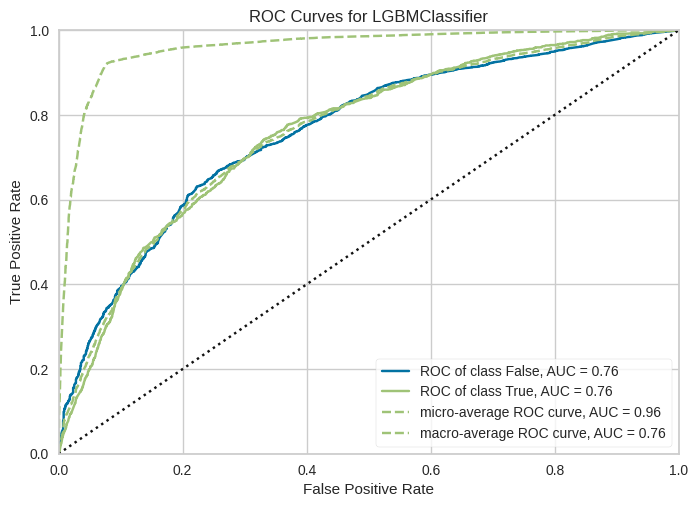

In [60]:
plot_model(tuned_lightgbm, plot="auc" )

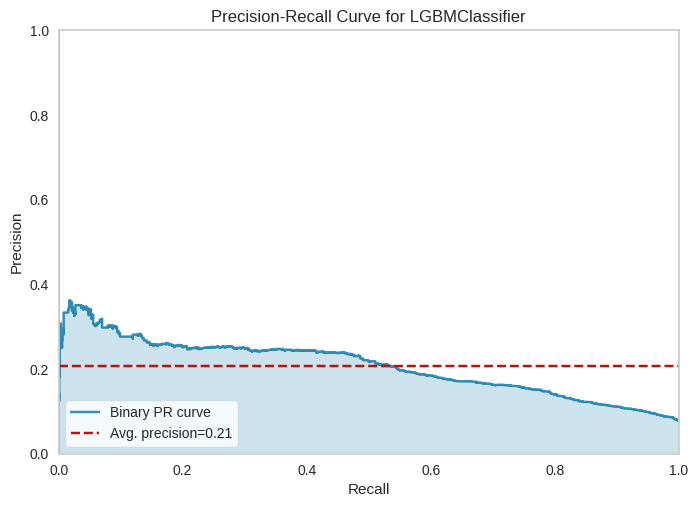

In [61]:
plot_model(tuned_lightgbm, plot='pr')

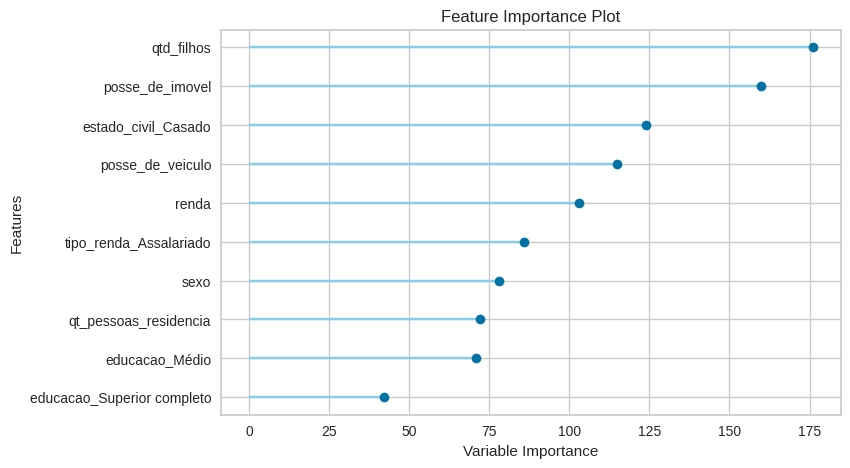

In [62]:
plot_model(tuned_lightgbm, plot='feature')

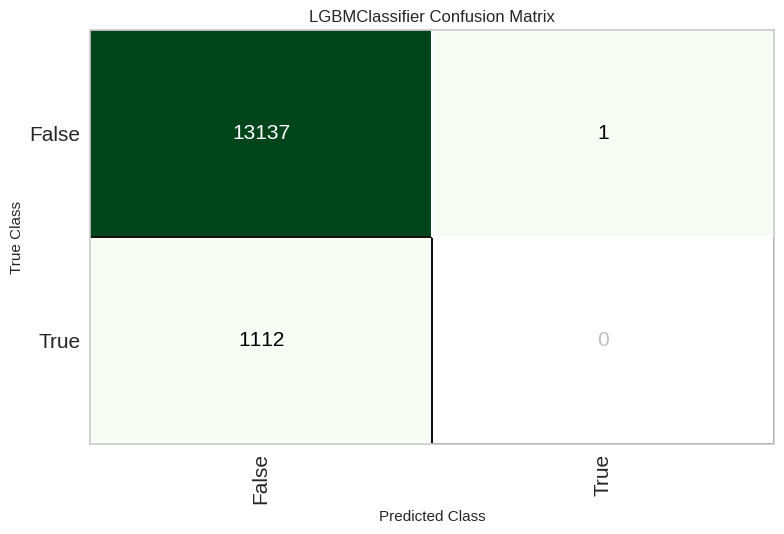

In [63]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [64]:
predict_model(tuned_lightgbm);

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


In [65]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Finalizando o modelo para deploy

In [66]:
final_model = finalize_model(tuned_lightgbm)

In [67]:
print(final_model)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight=None,
                           

In [68]:
predict_model(final_model);

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


In [69]:
save_model(final_model, 'Modelo 1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            